################################################################################
# Matthew Spitulnik ############################################################
# Natural Language Processing ##################################################
# Song Decade Classification #####################################
# Project Summary: For this project, the goal was to perform some kind of classification task using different variations of feature sets to compare the results. I continued working with song lyric data that I collected in previous projects; Comparing Corpora with Corpus Statistics (CCCS) and Sentiment and Exploratory Analysis (SEA), both of which can also be found within this project respository. I adjusted the song collection and lyric collection Python scripts to collect the song lyrics for Billboard top 100 songs, each year, going back to the 1950’s. Using different modeling techniques and feature-set-based variations, I wanted to try to build a model that could correctly identify the decade a song was written in based on its lyrics. The following NLP techniques were applied to create different feature sets that would be used to build the models: frequency distributions/document term matrices, sentiment/lexicon categorical analysis, and POS tagging/stop word differentiation. I created my prediction algorithms using cross validation with Naïve Bayes, Multinomial Naïve Bayes, Precision/Recall/F1 scores, and Support Vector Machines (SVM). I also used the “TopK” variation option in the scikit-learn Python package, which looks at the top “K” number of predictions, and if the prediction by the model is in the top K, it considers the prediction to be correct.
################################################################################

################################################################################
### Install and load required packages #########################################
################################################################################

In [ ]:
###Install the required libraries.
#%pip install spacy
#%pip install liwc
#%pip install liwc-text-analysis
#%pip install empath
#%pip install html5lib
#%pip install inflect
#%pip install contractions
#%pip install spacy_cleaner
#%pip install pandas
#%pip install re
#%pip install requests
#%pip install nltk
#%pip install lxml
#%pip install bs4
#%pip install sys
#%pip install gensim
#%pip install random
#%pip install json
#%pip install scikit-learn
#%pip install matplotlib
#%pip install numpy

In [29]:
###Import the required libraries
import spacy
#Make sure to run this below command in an outside command prompt:
#python -m spacy download en_core_web_sm
sp = spacy.load('en_core_web_sm')
all_stopwords = sp.Defaults.stop_words
import spacy_cleaner
from spacy_cleaner.processing import removers, replacers, mutators
import pandas as pd
import re
import requests
import html5lib
import nltk
import sys
#!{sys.executable} -m pip install contractions
import contractions
import inflect
wordPlur=inflect.engine()
from empath import Empath
lexicon = Empath()
import liwc
import gensim
import random
import json
import sklearn
import matplotlib.pyplot as plt
import numpy

from nltk import FreqDist
from lxml import html
from urllib.request import urlopen
from urllib import request
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
from nltk.collocations import *
from nltk import sent_tokenize
nltk.download('vader_lexicon',quiet=True)
nltk.download('stopwords',quiet=True)
stopwords=nltk.corpus.stopwords.words('english')
nltk.download('wordnet',quiet=True)
nltk.download('omw-1.4',quiet=True)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
from liwc import liwc
from collections import Counter
from nltk.tokenize import word_tokenize
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import top_k_accuracy_score
from sklearn import covariance
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

################################################################################
### Import the data sets and other files that will be used throughout the code #
################################################################################

In [ ]:
###This creates a "default_directory" variable, where the directory path to the 
# data files folder containing all of the required data sets is saved so that it 
# does not need to be constantly re-entered. Remember to use forward slashes 
# instead of back slashes in the directory path. For example, if the datafiles 
# folder is saved in "C:\home\project\datafiles", then "C:/home/project" 
# would be inserted between the quotes below.
default_directory = "<DEFAULT DIRECTORY PATH HERE>"

In [24]:
#load the data frames that were either created in CCCS, SEA, or that will be created later so that the web scraping or freq dist scripts don't need to be run and waited for
songArtDF = pd.read_csv(f'{default_directory}/datafiles/songArtDF.csv')
songArtDFOrg = pd.read_csv(f'{default_directory}/datafiles/songArtDFOrg.csv')
songArtLyrics =pd.read_csv(f'{default_directory}/datafiles/songArtLyrics.csv')
pre80_lyrics =pd.read_csv(f'{default_directory}/datafiles/pre80_lyrics.csv')
songArtDF_pre80 =pd.read_csv(f'{default_directory}/datafiles/songArtDF_pre80.csv')
FullSongDF_pre80 =pd.read_csv(f'{default_directory}/datafiles/FullSongDF_pre80.csv')
pre80ORG =pd.read_csv(f'{default_directory}/datafiles/pre80ORG.csv')
pre80Lyrics =pd.read_csv(f'{default_directory}/datafiles/pre80Lyrics.csv')
fullLyrList =pd.read_csv(f'{default_directory}/datafiles/fullLyrList.csv')
fullLyrBCU =pd.read_csv(f'{default_directory}/datafiles/fullLyrBCU.csv')
fullLyrFreqCU =pd.read_csv(f'{default_directory}/datafiles/fullLyrFreqCU.csv')
LyrFreqDF =pd.read_csv(f'{default_directory}/datafiles/LyrFreqDF.csv')
LyrFreqDF_2=pd.read_csv(f'{default_directory}/datafiles/LyrFreqDF_2.csv')
LyrSentDF=pd.read_csv(f'{default_directory}/datafiles/LyrSentDF.csv')
LyrEmpDF =pd.read_csv(f'{default_directory}/datafiles/LyrEmpDF.csv')
LyrLiwcDF=pd.read_csv(f'{default_directory}/datafiles/LyrLiwcDF.csv')
SentEmpDFLiwc=pd.read_csv(f'{default_directory}/datafiles/SentEmpDFLiwc.csv')
POScleanUp=pd.read_csv(f'{default_directory}/datafiles/POScleanUp.csv')
LyrPOSDF=pd.read_csv(f'{default_directory}/datafiles/LyrPOSDF.csv')
LyrPOSDF_NLTK=pd.read_csv(f'{default_directory}/datafiles/LyrPOSDF_NLTK.csv')
LyrPOSDF_SPC =pd.read_csv(f'{default_directory}/datafiles/LyrPOSDF_SPC.csv')
LyrPOSDF_GM =pd.read_csv(f'{default_directory}/datafiles/LyrPOSDF_GM.csv')

In [30]:
#load the liwc file that will be required for the liwc section of the analysis
liwc = liwc.Liwc(f'{default_directory}/datafiles/liwccombo2007.txt')

In [32]:
#load the first json file that will be used in the project
with open(f'{default_directory}/json_files/feature_set_freqDist.json', 'r') as file:
    feature_set_freqDist = json.load(file)
    
for i in range(0,len(feature_set_freqDist)):
    feature_set_freqDist[i]=tuple(feature_set_freqDist[i])

file.close()

In [34]:
#load the next json file that will be used in the project
with open(f'{default_directory}/json_files/feature_set_freqDist_2.json', 'r') as file:
    feature_set_freqDist_2 = json.load(file)
    
for i in range(0,len(feature_set_freqDist_2)):
    feature_set_freqDist_2[i]=tuple(feature_set_freqDist_2[i])

file.close()

In [35]:
#load the final json file that will be used in the project
with open(f'{default_directory}/json_files/feature_set_ALL.json', 'r') as file:
    feature_set_ALL = json.load(file)
    
for i in range(0,len(feature_set_ALL)):
    feature_set_ALL[i]=tuple(feature_set_ALL[i])

file.close()

################################################################################
### Collect Additional Required Data ###########################################
################################################################################

In [7]:
#original data set I worked with was from 1980 to 2019. Adding songs from the 1960's through 1979. 
# I technically could also get songs from 46-49, 20-22, but I want a full decades worth of data where possible. 
# In the 50's, top 100 songs weren't used until 1959. An additional song collection algorithm for that will be used in a second.
songArtDF_pre80=pd.DataFrame()
for i in range(1960,1980):
    songArtyear = "https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_" + str(i)
    temptables=pd.read_html(songArtyear)
    for h in range(0,len(temptables)):
        if 'Title' and 'Artist(s)' in temptables[h]:
            songArttable=temptables[h][['Title','Artist(s)']]
    songArttable['Year']=i
    
    CombDF=[songArtDF_pre80,songArttable]
    songArtDF_pre80=pd.concat(CombDF)
    
songArtDF_pre80=songArtDF_pre80.reset_index(drop=True)

In [4]:
#now create song collector for songs in the 50's, which requires some additional qualifiers.
songArtDF_50=pd.DataFrame()
for i in range(1950,1960):
    if i <= 1955:
        songArtyear = "https://en.wikipedia.org/wiki/Billboard_year-end_top_30_singles_of_" + str(i)
    elif i > 1955 and i < 1959:
        songArtyear = "https://en.wikipedia.org/wiki/Billboard_year-end_top_50_singles_of_" + str(i)
    elif i == 1959:
        songArtyear = "https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_1959"
    temptables=pd.read_html(songArtyear)
    songArttable=temptables[0][['Title','Artist(s)']]
    songArttable['Year']=i
    
    CombDF=[songArtDF_50,songArttable]
    songArtDF_50=pd.concat(CombDF)
    
songArtDF_50=songArtDF_50.reset_index(drop=True)

In [5]:
songArtDF_50

Title  \
0                                "Goodnight Irene"   
1                                      "Mona Lisa"   
2                                "Third Man Theme"   
3                                     "Sam's Song"   
4                                  "Simple Melody"   
..                                             ...   
426                       "Take a Message to Mary"   
427              "The Battle Hymn of the Republic"   
428                                   "Bongo Rock"   
429                                  "In the Mood"   
430  "Seven Little Girls Sitting in the Back Seat"   

                        Artist(s)  Year  
0    Gordon Jenkins & The Weavers  1950  
1                   Nat King Cole  1950  
2                     Anton Karas  1950  
3              Gary & Bing Crosby  1950  
4              Gary & Bing Crosby  1950  
..                            ...   ...  
426           The Everly Brothers  1959  
427       Mormon Tabernacle Choir  1959  
428                  Preston Epps  1959  
429                  Ernie Fields  1959  
430                    Paul Evans  1959  

[431 rows x 3 columns]

In [8]:
songArtDF_pre80

Title            Artist(s)  Year
0     "Theme from A Summer Place"          Percy Faith  1960
1              "He'll Have to Go"           Jim Reeves  1960
2                 "Cathy's Clown"  The Everly Brothers  1960
3                  "Running Bear"       Johnny Preston  1960
4                    "Teen Angel"         Mark Dinning  1960
...                           ...                  ...   ...
1996              "Dancin' Shoes"         Nigel Olsson  1979
1997                   "The Boss"           Diana Ross  1979
1998                    "Sail On"           Commodores  1979
1999              "I Do Love You"                   GQ  1979
2000                "Strange Way"             Firefall  1979

[2001 rows x 3 columns]

In [ ]:
songArtDF_pre80.to_csv(f'{default_directory}/datafiles/songArtDF_pre80.csv',index=False)

In [ ]:
#1960-1979 should have 2000 songs, but has 2001, figuring out where the issue is
pre80_pivot=songArtDF_pre80.pivot_table(columns=['Year'], aggfunc ='size')
pre80_pivot #output shows that the year 1969 has 101 songs instead of 100
#####It turns out two songs tied for 100th place in 1969, so both songs will be used.

Year
1960    100
1961    100
1962    100
1963    100
1964    100
1965    100
1966    100
1967    100
1968    100
1969    101
1970    100
1971    100
1972    100
1973    100
1974    100
1975    100
1976    100
1977    100
1978    100
1979    100
dtype: int64

In [12]:
#the 50's decade should have 430 songs: 6 years with 30 songs, 3 years with 50 songs, 1 year with 100 songs, for a total of 430. Seeing why there is 431 instead.
dec50_pivot=songArtDF_50.pivot_table(columns=['Year'], aggfunc ='size')
dec50_pivot #output shows that the year 1958 has 51 songs instead of 50
#####It turns out two songs tied for 50th place in 1958, so both songs will be used.

Year
1950     30
1951     30
1952     30
1953     30
1954     30
1955     30
1956     50
1957     50
1958     51
1959    100
dtype: int64

In [13]:
#combine all of the data into one dataframe for list of songs before 1980
CombDF=[songArtDF_50,songArtDF_pre80]
FullSongDF_pre80=pd.concat(CombDF)
    
FullSongDF_pre80=FullSongDF_pre80.reset_index(drop=True)
FullSongDF_pre80

Title                     Artist(s)  Year
0     "Goodnight Irene"  Gordon Jenkins & The Weavers  1950
1           "Mona Lisa"                 Nat King Cole  1950
2     "Third Man Theme"                   Anton Karas  1950
3          "Sam's Song"            Gary & Bing Crosby  1950
4       "Simple Melody"            Gary & Bing Crosby  1950
...                 ...                           ...   ...
2427    "Dancin' Shoes"                  Nigel Olsson  1979
2428         "The Boss"                    Diana Ross  1979
2429          "Sail On"                    Commodores  1979
2430    "I Do Love You"                            GQ  1979
2431      "Strange Way"                      Firefall  1979

[2432 rows x 3 columns]

In [14]:
FullSongDF_pre80.to_csv(f'{default_directory}/datafiles/FullSongDF_pre80.csv',index=False)

In [15]:
#create copy of the DF with artists before adding to it
pre80_lyrics=FullSongDF_pre80.copy(deep=True)

In [22]:
#now add the lyrics for the songs before the 1980s
for i in pre80_lyrics.index:
    theremoval=re.sub('^The ','',pre80_lyrics.loc[i,'Artist(s)'])
    firstletter=theremoval[0].lower()
    artnospace= re.sub('[\W]','',theremoval)
    titlenospace= re.sub('[\W]','',pre80_lyrics.loc[i,'Title'])
    templyricURL='https://www.lyricsondemand.com/' + firstletter + '/' + artnospace + 'lyrics/' + titlenospace + 'lyrics.html'
    templyricURL=templyricURL.lower()
    
    linktest = requests.get(templyricURL)
    if linktest.status_code == 200:
        templyrichtml=requests.get(templyricURL)
        templyriccontent=html.fromstring(templyrichtml.content)
        templyric=str(templyriccontent.xpath('//*[@id="ldata"]/div[3]/text()'))
        pre80_lyrics.loc[i,'Lyrics']=templyric
    else:
        thetest = re.match('^The ', pre80_lyrics.loc[i,'Artist(s)'])
        if thetest:
            artnospace= re.sub('[\W]','',pre80_lyrics.loc[i,'Artist(s)'])
            templyricURL='https://www.lyricsondemand.com/' + firstletter + '/' + artnospace + 'lyrics/' + titlenospace + 'lyrics.html'
            templyricURL=templyricURL.lower()
    
            linktest = requests.get(templyricURL)
            if linktest.status_code == 200:
                templyrichtml=requests.get(templyricURL)
                templyriccontent=html.fromstring(templyrichtml.content)
                templyric=str(templyriccontent.xpath('//*[@id="ldata"]/div[3]/text()'))
                pre80_lyrics.loc[i,'Lyrics']=templyric
            else:
                if ' and ' in pre80_lyrics.loc[i,'Artist(s)']:
                    andsubremoval=re.sub(' and (?<= and ).*$','',pre80_lyrics.loc[i,'Artist(s)'])
                else:
                    andsubremoval=pre80_lyrics.loc[i,'Artist(s)']
                if ' & ' in andsubremoval:
                    ampsubremoval=re.sub(' & (?<= & ).*$','',andsubremoval)
                else:
                    ampsubremoval=andsubremoval
                if ' featuring ' in ampsubremoval:
                    featsubremoval=re.sub(' featuring (?<= featuring ).*$','',ampsubremoval)
                else:
                    featsubremoval=ampsubremoval
                    artnospace= re.sub('[\W]','',featsubremoval)
        else:
            if ' and ' in pre80_lyrics.loc[i,'Artist(s)']:
                andsubremoval=re.sub(' and (?<= and ).*$','',pre80_lyrics.loc[i,'Artist(s)'])
            else:
                andsubremoval=pre80_lyrics.loc[i,'Artist(s)']
            if ' & ' in andsubremoval:
                ampsubremoval=re.sub(' & (?<= & ).*$','',andsubremoval)
            else:
                ampsubremoval=andsubremoval
            if ' featuring ' in ampsubremoval:
                featsubremoval=re.sub(' featuring (?<= featuring ).*$','',ampsubremoval)
            else:
                featsubremoval=ampsubremoval
                artnospace= re.sub('[\W]','',featsubremoval)
        templyricURL='https://www.lyricsondemand.com/' + firstletter + '/' + artnospace + 'lyrics/' + titlenospace + 'lyrics.html'
        templyricURL=templyricURL.lower()
        templyrichtml=requests.get(templyricURL)
        templyriccontent=html.fromstring(templyrichtml.content)
        templyric=str(templyriccontent.xpath('//*[@id="ldata"]/div[3]/text()'))
        pre80_lyrics.loc[i,'Lyrics']=templyric

In [23]:
#a large number of songs didn't work, the xpath to the song lyric text appears to be different for many of those songs, adjusting script to fill in the lyrics that didn't work
for i in pre80_lyrics.index:
    if pre80_lyrics.loc[i,'Lyrics']=='[\'\\n\', \'\\n\\n\']' or pre80_lyrics.loc[i,'Lyrics']=='[\'\\n\', \'\\n\']' or pre80_lyrics.loc[i,'Lyrics']=='[\'\\n\', \'\\n\']':
        theremoval=re.sub('^The ','',pre80_lyrics.loc[i,'Artist(s)'])
        firstletter=theremoval[0].lower()
        artnospace= re.sub('[\W]','',theremoval)
        titlenospace= re.sub('[\W]','',pre80_lyrics.loc[i,'Title'])
        templyricURL='https://www.lyricsondemand.com/' + firstletter + '/' + artnospace + 'lyrics/' + titlenospace + 'lyrics.html'
        templyricURL=templyricURL.lower()
    
        linktest = requests.get(templyricURL)
        if linktest.status_code == 200:
            templyrichtml=requests.get(templyricURL)
            templyriccontent=html.fromstring(templyrichtml.content)
            templyric=str(templyriccontent.xpath('//*[@id="sbmtlyr"]/text()'))
            pre80_lyrics.loc[i,'Lyrics']=templyric
        else:
            thetest = re.match('^The ', pre80_lyrics.loc[i,'Artist(s)'])
            if thetest:
                artnospace= re.sub('[\W]','',pre80_lyrics.loc[i,'Artist(s)'])
                templyricURL='https://www.lyricsondemand.com/' + firstletter + '/' + artnospace + 'lyrics/' + titlenospace + 'lyrics.html'
                templyricURL=templyricURL.lower()
    
                linktest = requests.get(templyricURL)
                if linktest.status_code == 200:
                    templyrichtml=requests.get(templyricURL)
                    templyriccontent=html.fromstring(templyrichtml.content)
                    templyric=str(templyriccontent.xpath('//*[@id="sbmtlyr"]/text()'))
                    pre80_lyrics.loc[i,'Lyrics']=templyric
                else:
                    if ' and ' in pre80_lyrics.loc[i,'Artist(s)']:
                        andsubremoval=re.sub(' and (?<= and ).*$','',pre80_lyrics.loc[i,'Artist(s)'])
                    else:
                        andsubremoval=pre80_lyrics.loc[i,'Artist(s)']
                    if ' & ' in andsubremoval:
                        ampsubremoval=re.sub(' & (?<= & ).*$','',andsubremoval)
                    else:
                        ampsubremoval=andsubremoval
                    if ' featuring ' in ampsubremoval:
                        featsubremoval=re.sub(' featuring (?<= featuring ).*$','',ampsubremoval)
                    else:
                        featsubremoval=ampsubremoval
                    artnospace= re.sub('[\W]','',featsubremoval)
            else:
                if ' and ' in pre80_lyrics.loc[i,'Artist(s)']:
                    andsubremoval=re.sub(' and (?<= and ).*$','',pre80_lyrics.loc[i,'Artist(s)'])
                else:
                    andsubremoval=pre80_lyrics.loc[i,'Artist(s)']
                if ' & ' in andsubremoval:
                    ampsubremoval=re.sub(' & (?<= & ).*$','',andsubremoval)
                else:
                    ampsubremoval=andsubremoval
                if ' featuring ' in ampsubremoval:
                    featsubremoval=re.sub(' featuring (?<= featuring ).*$','',ampsubremoval)
                else:
                    featsubremoval=ampsubremoval
                artnospace= re.sub('[\W]','',featsubremoval)
            templyricURL='https://www.lyricsondemand.com/' + firstletter + '/' + artnospace + 'lyrics/' + titlenospace + 'lyrics.html'
            templyricURL=templyricURL.lower()
            templyrichtml=requests.get(templyricURL)
            templyriccontent=html.fromstring(templyrichtml.content)
            templyric=str(templyriccontent.xpath('//*[@id="sbmtlyr"]/text()'))
            pre80_lyrics.loc[i,'Lyrics']=templyric
    else:
        if pre80_lyrics.loc[i,'Lyrics']=='[]':
            theremoval=re.sub('^The ','',pre80_lyrics.loc[i,'Artist(s)'])
            firstletter=theremoval[0].lower()
            artnospace= re.sub('[\W]','',theremoval)
            titlenospace= re.sub('[\W]','',pre80_lyrics.loc[i,'Title'])
            templyricURL='https://www.lyricsondemand.com/' + firstletter + '/' + artnospace + 'lyrics/' + titlenospace + 'lyrics.html'
            templyricURL=templyricURL.lower()
    
            linktest = requests.get(templyricURL)
            if linktest.status_code == 200:
                templyrichtml=requests.get(templyricURL)
                templyriccontent=html.fromstring(templyrichtml.content)
                templyric=str(templyriccontent.xpath('//*[@id="ldata"]/div[4]/text()'))
                pre80_lyrics.loc[i,'Lyrics']=templyric
            else:
                thetest = re.match('^The ', pre80_lyrics.loc[i,'Artist(s)'])
                if thetest:
                    artnospace= re.sub('[\W]','',pre80_lyrics.loc[i,'Artist(s)'])
                    templyricURL='https://www.lyricsondemand.com/' + firstletter + '/' + artnospace + 'lyrics/' + titlenospace + 'lyrics.html'
                    templyricURL=templyricURL.lower()
    
                    linktest = requests.get(templyricURL)
                    if linktest.status_code == 200:
                        templyrichtml=requests.get(templyricURL)
                        templyriccontent=html.fromstring(templyrichtml.content)
                        templyric=str(templyriccontent.xpath('//*[@id="ldata"]/div[4]/text()'))
                        pre80_lyrics.loc[i,'Lyrics']=templyric
                    else:
                        if ' and ' in pre80_lyrics.loc[i,'Artist(s)']:
                            andsubremoval=re.sub(' and (?<= and ).*$','',pre80_lyrics.loc[i,'Artist(s)'])
                        else:
                            andsubremoval=pre80_lyrics.loc[i,'Artist(s)']
                        if ' & ' in andsubremoval:
                            ampsubremoval=re.sub(' & (?<= & ).*$','',andsubremoval)
                        else:
                            ampsubremoval=andsubremoval
                        if ' featuring ' in ampsubremoval:
                            featsubremoval=re.sub(' featuring (?<= featuring ).*$','',ampsubremoval)
                        else:
                            featsubremoval=ampsubremoval
                        artnospace= re.sub('[\W]','',featsubremoval)
                else:
                    if ' and ' in pre80_lyrics.loc[i,'Artist(s)']:
                        andsubremoval=re.sub(' and (?<= and ).*$','',pre80_lyrics.loc[i,'Artist(s)'])
                    else:
                        andsubremoval=pre80_lyrics.loc[i,'Artist(s)']
                    if ' & ' in andsubremoval:
                        ampsubremoval=re.sub(' & (?<= & ).*$','',andsubremoval)
                    else:
                        ampsubremoval=andsubremoval
                    if ' featuring ' in ampsubremoval:
                        featsubremoval=re.sub(' featuring (?<= featuring ).*$','',ampsubremoval)
                    else:
                        featsubremoval=ampsubremoval
                    artnospace= re.sub('[\W]','',featsubremoval)
                templyricURL='https://www.lyricsondemand.com/' + firstletter + '/' + artnospace + 'lyrics/' + titlenospace + 'lyrics.html'
                templyricURL=templyricURL.lower()
                templyrichtml=requests.get(templyricURL)
                templyriccontent=html.fromstring(templyrichtml.content)
                templyric=str(templyriccontent.xpath('//*[@id="ldata"]/div[4]/text()'))
                pre80_lyrics.loc[i,'Lyrics']=templyric

In [ ]:
#still didn't get a bunch of songs, realized the syntax for some of the if statements were incorrect, corrected those
for i in range(0,len(pre80_lyrics)):
    if pre80_lyrics.loc[i,'Lyrics']=='[\'\\n\', \'\\n\\n\']' or pre80_lyrics.loc[i,'Lyrics']=='[\'\\n\', \'\\n\']' or pre80_lyrics.loc[i,'Lyrics']=='[\'\\n\', \'\\n\']':
        theremoval=re.sub('^The ','',pre80_lyrics.loc[i,'Artist(s)'])
        firstletter=theremoval[0].lower()
        artnospace= re.sub('[\W]','',theremoval)
        titlenospace= re.sub('[\W]','',pre80_lyrics.loc[i,'Title'])
        templyricURL='https://www.lyricsondemand.com/' + firstletter + '/' + artnospace + 'lyrics/' + titlenospace + 'lyrics.html'
        templyricURL=templyricURL.lower()
    
        linktest = requests.get(templyricURL)
        if linktest.status_code == 200:
            templyrichtml=requests.get(templyricURL)
            templyriccontent=html.fromstring(templyrichtml.content)
            templyric=str(templyriccontent.xpath('//*[@id="sbmtlyr"]/text()'))
            pre80_lyrics.loc[i,'Lyrics']=templyric
            print(1)
        else:
            thetest = re.match('^The ', pre80_lyrics.loc[i,'Artist(s)'])
            if thetest:
                artnospace= re.sub('[\W]','',pre80_lyrics.loc[i,'Artist(s)'])
                templyricURL='https://www.lyricsondemand.com/' + firstletter + '/' + artnospace + 'lyrics/' + titlenospace + 'lyrics.html'
                templyricURL=templyricURL.lower()
    
                linktest = requests.get(templyricURL)
                if linktest.status_code == 200:
                    templyrichtml=requests.get(templyricURL)
                    templyriccontent=html.fromstring(templyrichtml.content)
                    templyric=str(templyriccontent.xpath('//*[@id="sbmtlyr"]/text()'))
                    pre80_lyrics.loc[i,'Lyrics']=templyric
                    print(2)
                else:
                    if ' and ' in pre80_lyrics.loc[i,'Artist(s)']:
                        andsubremoval=re.sub(' and (?<= and ).*$','',pre80_lyrics.loc[i,'Artist(s)'])
                    else:
                        andsubremoval=pre80_lyrics.loc[i,'Artist(s)']
                    if ' & ' in andsubremoval:
                        ampsubremoval=re.sub(' & (?<= & ).*$','',andsubremoval)
                    else:
                        ampsubremoval=andsubremoval
                    if ' featuring ' in ampsubremoval:
                        featsubremoval=re.sub(' featuring (?<= featuring ).*$','',ampsubremoval)
                    else:
                        featsubremoval=ampsubremoval
                    artnospace= re.sub('[\W]','',featsubremoval)
            else:
                if ' and ' in pre80_lyrics.loc[i,'Artist(s)']:
                    andsubremoval=re.sub(' and (?<= and ).*$','',pre80_lyrics.loc[i,'Artist(s)'])
                else:
                    andsubremoval=pre80_lyrics.loc[i,'Artist(s)']
                if ' & ' in andsubremoval:
                    ampsubremoval=re.sub(' & (?<= & ).*$','',andsubremoval)
                else:
                    ampsubremoval=andsubremoval
                if ' featuring ' in ampsubremoval:
                    featsubremoval=re.sub(' featuring (?<= featuring ).*$','',ampsubremoval)
                else:
                    featsubremoval=ampsubremoval
                artnospace= re.sub('[\W]','',featsubremoval)
            templyricURL='https://www.lyricsondemand.com/' + firstletter + '/' + artnospace + 'lyrics/' + titlenospace + 'lyrics.html'
            templyricURL=templyricURL.lower()
            templyrichtml=requests.get(templyricURL)
            templyriccontent=html.fromstring(templyrichtml.content)
            #templyric=str(templyriccontent.xpath('//*[@id="sbmtlyr"]/text()'))
            templyric=str(templyriccontent.xpath('//*[@id="ldata"]/div[4]/text()'))
            pre80_lyrics.loc[i,'Lyrics']=templyric
            print(3)
    else:
        if pre80_lyrics.loc[i,'Lyrics']=='[]':
            theremoval=re.sub('^The ','',pre80_lyrics.loc[i,'Artist(s)'])
            firstletter=theremoval[0].lower()
            artnospace= re.sub('[\W]','',theremoval)
            titlenospace= re.sub('[\W]','',pre80_lyrics.loc[i,'Title'])
            templyricURL='https://www.lyricsondemand.com/' + firstletter + '/' + artnospace + 'lyrics/' + titlenospace + 'lyrics.html'
            templyricURL=templyricURL.lower()
    
            linktest = requests.get(templyricURL)
            if linktest.status_code == 200:
                templyrichtml=requests.get(templyricURL)
                templyriccontent=html.fromstring(templyrichtml.content)
                templyric=str(templyriccontent.xpath('//*[@id="ldata"]/div[4]/text()'))
                pre80_lyrics.loc[i,'Lyrics']=templyric
                print(4)
            else:
                thetest = re.match('^The ', pre80_lyrics.loc[i,'Artist(s)'])
                if thetest:
                    artnospace= re.sub('[\W]','',pre80_lyrics.loc[i,'Artist(s)'])
                    templyricURL='https://www.lyricsondemand.com/' + firstletter + '/' + artnospace + 'lyrics/' + titlenospace + 'lyrics.html'
                    templyricURL=templyricURL.lower()
    
                    linktest = requests.get(templyricURL)
                    if linktest.status_code == 200:
                        templyrichtml=requests.get(templyricURL)
                        templyriccontent=html.fromstring(templyrichtml.content)
                        templyric=str(templyriccontent.xpath('//*[@id="ldata"]/div[5]/text()'))
                        pre80_lyrics.loc[i,'Lyrics']=templyric
                        print(5)
                    else:
                        if ' and ' in pre80_lyrics.loc[i,'Artist(s)']:
                            andsubremoval=re.sub(' and (?<= and ).*$','',pre80_lyrics.loc[i,'Artist(s)'])
                        else:
                            andsubremoval=pre80_lyrics.loc[i,'Artist(s)']
                        if ' & ' in andsubremoval:
                            ampsubremoval=re.sub(' & (?<= & ).*$','',andsubremoval)
                        else:
                            ampsubremoval=andsubremoval
                        if ' featuring ' in ampsubremoval:
                            featsubremoval=re.sub(' featuring (?<= featuring ).*$','',ampsubremoval)
                        else:
                            featsubremoval=ampsubremoval
                        artnospace= re.sub('[\W]','',featsubremoval)
                else:
                    if ' and ' in pre80_lyrics.loc[i,'Artist(s)']:
                        andsubremoval=re.sub(' and (?<= and ).*$','',pre80_lyrics.loc[i,'Artist(s)'])
                    else:
                        andsubremoval=pre80_lyrics.loc[i,'Artist(s)']
                    if ' & ' in andsubremoval:
                        ampsubremoval=re.sub(' & (?<= & ).*$','',andsubremoval)
                    else:
                        ampsubremoval=andsubremoval
                    if ' featuring ' in ampsubremoval:
                        featsubremoval=re.sub(' featuring (?<= featuring ).*$','',ampsubremoval)
                    else:
                        featsubremoval=ampsubremoval
                    artnospace= re.sub('[\W]','',featsubremoval)
                templyricURL='https://www.lyricsondemand.com/' + firstletter + '/' + artnospace + 'lyrics/' + titlenospace + 'lyrics.html'
                templyricURL=templyricURL.lower()
                templyrichtml=requests.get(templyricURL)
                templyriccontent=html.fromstring(templyrichtml.content)
                templyric=str(templyriccontent.xpath('//*[@id="ldata"]/div[4]/text()'))
                pre80_lyrics.loc[i,'Lyrics']=templyric
                print(6)

In [40]:
print(pre80_lyrics['Lyrics'].value_counts()['[\'\\n\', \'\\n\']'])

44


In [ ]:
#print(pre80_lyrics['Lyrics'].value_counts()['[\'\\n\', \'\\n\\n\']'])

In [39]:
print(pre80_lyrics['Lyrics'].value_counts()['[]'])

71


In [41]:
print(pre80_lyrics['Lyrics'].value_counts()['[\'\\n\']'])

1


In [44]:
#figure out which songs still have issues
count=0
for i in pre80_lyrics.index:
    if pre80_lyrics.loc[i,'Lyrics']=='[\'\\n\', \'\\n\']' or pre80_lyrics.loc[i,'Lyrics']=='[\'\\n\']':
        count=count+1
        print(i, ' || ', pre80_lyrics.loc[i,'Lyrics'])

count

38  ||  ['\n', '\n']
180  ||  ['\n', '\n']
181  ||  ['\n', '\n']
185  ||  ['\n', '\n']
194  ||  ['\n', '\n']
230  ||  ['\n', '\n']
238  ||  ['\n', '\n']
245  ||  ['\n', '\n']
360  ||  ['\n', '\n']
364  ||  ['\n', '\n']
437  ||  ['\n', '\n']
439  ||  ['\n', '\n']
581  ||  ['\n', '\n']
626  ||  ['\n', '\n']
650  ||  ['\n', '\n']
687  ||  ['\n', '\n']
799  ||  ['\n', '\n']
933  ||  ['\n', '\n']
939  ||  ['\n', '\n']
1126  ||  ['\n', '\n']
1280  ||  ['\n', '\n']
1334  ||  ['\n', '\n']
1348  ||  ['\n', '\n']
1349  ||  ['\n', '\n']
1354  ||  ['\n', '\n']
1361  ||  ['\n', '\n']
1365  ||  ['\n', '\n']
1408  ||  ['\n']
1503  ||  ['\n', '\n']
1504  ||  ['\n', '\n']
1520  ||  ['\n', '\n']
1547  ||  ['\n', '\n']
1562  ||  ['\n', '\n']
1679  ||  ['\n', '\n']
1816  ||  ['\n', '\n']
1941  ||  ['\n', '\n']
2056  ||  ['\n', '\n']
2109  ||  ['\n', '\n']
2150  ||  ['\n', '\n']
2174  ||  ['\n', '\n']
2190  ||  ['\n', '\n']
2195  ||  ['\n', '\n']
2247  ||  ['\n', '\n']
2378  ||  ['\n', '\n']
2393  ||  ['\n

45

In [25]:
#turn lyrics that are just those line breaks into blanks
for i in pre80_lyrics.index:
    if pre80_lyrics.loc[i,'Lyrics']=='[\'\\n\', \'\\n\']' or pre80_lyrics.loc[i,'Lyrics']=='[\'\\n\']':
        pre80_lyrics.loc[i,'Lyrics']='[]'

In [51]:
for i in pre80_lyrics.index:
#for i in range(3925,3926):
    if pre80_lyrics.loc[i,'Lyrics']=='[]':
        if ' and ' in pre80_lyrics.loc[i,'Artist(s)']:
            featart=re.findall('(?<= and ).*$', pre80_lyrics.loc[i,'Artist(s)'])
            featart=str(featart[0])
            andsubremoval=re.sub(' and (?<= and ).*$','',pre80_lyrics.loc[i,'Artist(s)'])
            featadd=andsubremoval+'-feat-'+featart
        elif ' & ' in pre80_lyrics.loc[i,'Artist(s)']:
            featart=re.findall('(?<= & ).*$', pre80_lyrics.loc[i,'Artist(s)'])
            featart=str(featart[0])
            ampsubremoval=re.sub(' & (?<= & ).*$','',pre80_lyrics.loc[i,'Artist(s)'])
            featadd=ampsubremoval+'-feat-'+featart
        elif ' featuring ' in pre80_lyrics.loc[i,'Artist(s)']:
            featart=re.findall('(?<= featuring ).*$', pre80_lyrics.loc[i,'Artist(s)'])
            featart=str(featart[0])
            featsubremoval=re.sub(' featuring (?<= featuring ).*$','',pre80_lyrics.loc[i,'Artist(s)'])
            featadd=featsubremoval+'-feat-'+featart
        else:
            featadd=pre80_lyrics.loc[i,'Artist(s)']
        artnospace=featadd.replace(',','')
        artnospace= re.sub('[\W]','-',artnospace)
        titlenospace=re.sub('^"','',pre80_lyrics.loc[i,'Title'])
        titlenospace=titlenospace.replace(',','')
        titlenospace= re.sub('[\W]','-',titlenospace)
        templyricURL='https://www.songlyrics.com/' + artnospace + '/' + titlenospace + 'lyrics/'
        templyricURL=templyricURL.lower()
        
        linktest = requests.get(templyricURL)
        if linktest.status_code == 200:
            templyrichtml=requests.get(templyricURL)
            templyriccontent=html.fromstring(templyrichtml.content)
            templyric=str(templyriccontent.xpath('//*[@id="songLyricsDiv"]/text()'))
            pre80_lyrics.loc[i,'Lyrics']=templyric

In [ ]:
#print(pre80_lyrics['Lyrics'].value_counts()['[\'\\n\', \'\\n\']'])

In [ ]:
#print(pre80_lyrics['Lyrics'].value_counts()['[\'\\n\', \'\\n\\n\']'])

In [ ]:
print(pre80_lyrics['Lyrics'].value_counts()['[]'])

In [ ]:
print(pre80_lyrics['Lyrics'].value_counts()['[\'\\n\', \'\\n\', \'\\n\\n\']'])

In [9]:
pre80_lyrics.loc[784,'Lyrics']

"['\\n', '\\n', '\\n\\n']"

In [4]:
for i in pre80_lyrics.index:
    if pre80_lyrics.loc[i,'Lyrics']=='[\'\\n\', \'\\n\', \'\\n\\n\']':
        print(i, ' || ', pre80_lyrics.loc[i,'Lyrics'])

In [26]:
for i in pre80_lyrics.index:
    if pre80_lyrics.loc[i,'Lyrics']=='[\'\\n\', \'\\n\', \'\\n\\n\']':
        pre80_lyrics.loc[i,'Lyrics']='[]'

In [7]:
for i in pre80_lyrics.index:
    if pre80_lyrics.loc[i,'Lyrics']=='[\'\\n\', \'\\n\', \'\\n\\n\']':
        print(i, ' || ', pre80_lyrics.loc[i,'Lyrics'])

In [ ]:
#print(pre80_lyrics['Lyrics'].value_counts()['[\'\\n\']'])

In [ ]:
#print(pre80_lyrics['Lyrics'].value_counts()['[\'We do not have the lyrics for\']'])

In [ ]:
#82 songs with no lyrics, definitely good enough to continue.

In [8]:
pre80_lyrics.to_csv(f'{default_directory}/datafiles/pre80_lyrics.csv',index=False)

In [18]:
pre80_lyrics.loc[1905,'Lyrics']

'[\\\'\\\\nOne, two, three, four!\\\', \\\'\\\\n\\\\n\\\', \\\'\\\\n\\\', \\\'\\\\n\\\', \\\'\\\\n\\\', \\\'\\\\n\\\', \\\'\\\\n\\\', \\\'\\\\n\\\', \\\'\\\\n\\\']["I phoned up my doctor to see what\\\'s the matter,", \\\'\\\\nHe said, "come on over."\\\', \\\'\\\\nI said, "do i have to?"\\\', "\\\\nMy knees started shakin\\\', my wrist started achin\\\'", \\\'\\\\nWhen my doctor said to me:\\\', \\\'\\\\n\\\', \\\'"oh my my, oh my my, can you boogie, can you slide?\\\', \\\'\\\\nOh my my, oh my my, you can boogie if you try.\\\', \\\'\\\\nOh my my, oh my my, it\\\\\\\'s guaranteed to keep you alive."\\\', \\\'\\\\n\\\', \\\'The head nurse she blew in, just like a tornado,\\\', "\\\\nWhen they started dancin\\\', i jumped off the table.", "\\\\nI felt myself healin\\\' and as i was leavin\\\',", \\\'\\\\nThis is what they said to me:\\\', \\\'\\\\n\\\', \\\'"oh my my, oh my my, can you boogie, can you slide?\\\', \\\'\\\\nOh my my, oh my my, you can boogie if you try.\\\', \\\'\\\\nOh 

In [27]:
#check breakdown of how many songs are in each
pre80_pivot=pre80_lyrics.pivot_table(columns=['Year'], aggfunc ='size')
pre80_pivot

Year
1950     30
1951     30
1952     30
1953     30
1954     30
1955     30
1956     50
1957     50
1958     51
1959    100
1960    100
1961    100
1962    100
1963    100
1964    100
1965    100
1966    100
1967    100
1968    100
1969    101
1970    100
1971    100
1972    100
1973    100
1974    100
1975    100
1976    100
1977    100
1978    100
1979    100
dtype: int64

In [28]:
#make a copy of song list as is before editting
pre80ORG=pre80_lyrics.copy(deep=True)
pre80ORG.to_csv(f'{default_directory}/datafiles/pre80ORG.csv',index=False)

In [29]:
pre80Lyrics=pre80ORG[pre80ORG['Lyrics'] != '[]']
pre80Lyrics=pre80Lyrics.reset_index(drop=True)

In [30]:
pre80Lyrics.to_csv(f'{default_directory}/datafiles/pre80Lyrics.csv',index=False)

In [31]:
#check breakdown again of how many songs are in each
pre80_pivot=pre80Lyrics.pivot_table(columns=['Year'], aggfunc ='size')
pre80_pivot

Year
1950     27
1951     27
1952     28
1953     28
1954     30
1955     29
1956     49
1957     50
1958     40
1959     93
1960     97
1961     97
1962     95
1963     97
1964     99
1965     98
1966     94
1967    100
1968    100
1969    100
1970    100
1971     95
1972     96
1973     95
1974     95
1975     97
1976     97
1977     98
1978     99
1979    100
dtype: int64

In [4]:
pre80Lyrics

Title                     Artist(s)  Year  \
0         "Goodnight Irene"  Gordon Jenkins & The Weavers  1950   
1               "Mona Lisa"                 Nat King Cole  1950   
2         "Third Man Theme"                   Anton Karas  1950   
3           "Simple Melody"            Gary & Bing Crosby  1950   
4     "Music, Music, Music"                 Teresa Brewer  1950   
...                     ...                           ...   ...   
2345        "Dancin' Shoes"                  Nigel Olsson  1979   
2346             "The Boss"                    Diana Ross  1979   
2347              "Sail On"                    Commodores  1979   
2348        "I Do Love You"                            GQ  1979   
2349          "Strange Way"                      Firefall  1979   

                                                 Lyrics  
0     ['\nGoodnight, Irene ', '\nGordon Jenkins & hi...  
1     ['\nMona Lisa, Mona Lisa', '\nMen have named y...  
2     ['\nWhen a zither starts to play', "\nYou'll r...  
3     ["Won't you play some simple melody", '\nLike ...  
4     ['\nMUSIC, MUSIC MUSIC', '\n', '\nPUT ANOTHER ...  
...                                                 ...  
2345  ['\nToo many long conversations ', '\nAnd no o...  
2346  ['\n(Nickolas Ashford and Valerie Simpson)', '...  
2347  ['\nSail on, down the line', '\nAbout half a m...  
2348  ['\nI do love you, ooooh', "\nBut it's alright...  
2349  ["\nDidn't I hear you cry this mornin'", "\nDi...  

[2350 rows x 4 columns]

In [22]:
songArtDF

Title                       Artist(s)  \
0                                "Call Me"                         Blondie   
1     "Another Brick in the Wall, Part II"                      Pink Floyd   
2                                  "Magic"              Olivia Newton-John   
3                          "Rock with You"                 Michael Jackson   
4            "Do That to Me One More Time"              Captain & Tennille   
...                                    ...                             ...   
3995                         "Eyes on You"                      Chase Rice   
3996                       "All to Myself"                      Dan + Shay   
3997                           "Boyfriend"  Ariana Grande and Social House   
3998                        "Walk Me Home"                            Pink   
3999                             "Robbery"                      Juice Wrld   

      Year Before2000                                             Lyrics  
0     1980        Yes  ['\nColour me your colour, baby', 'Colour me y...  
1     1980        Yes  ["\nWe don't need no education ", "We don't ne...  
2     1980        Yes  ['\nCome take my hand', '\nYou should know me'...  
3     1980        Yes  ['\n[1st Verse]', '\nGirl, Close Your Eyes', '...  
4     1980        Yes  ['\nDo that to me one more time', '\nOnce is n...  
...    ...        ...                                                ...  
3995  2019         No  ["We've been to both Carolina's", '\nSeen a bi...  
3996  2019         No  ["I'm jealous of the blue jeans that you're we...  
3997  2019         No  ['\n(Feat. Social House)', '\n', '\n[Ariana Gr...  
3998  2019         No                                                 []  
3999  2019         No                                                 []  

[4000 rows x 5 columns]

In [29]:
#remove songs from post 1980 list of songs that had no lyrics
post1980CleanUp=songArtDF.copy(deep=True)
post1980CleanUp=post1980CleanUp[post1980CleanUp['Lyrics'] != '[]']
post1980CleanUp=post1980CleanUp.reset_index(drop=True)
post1980CleanUp

Title  \
0                                "Call Me"   
1     "Another Brick in the Wall, Part II"   
2                                  "Magic"   
3                          "Rock with You"   
4            "Do That to Me One More Time"   
...                                    ...   
3795                     "Hot Girl Summer"   
3796                  "Talk You Out of It"   
3797                         "Eyes on You"   
3798                       "All to Myself"   
3799                           "Boyfriend"   

                                              Artist(s)  Year Before2000  \
0                                               Blondie  1980        Yes   
1                                            Pink Floyd  1980        Yes   
2                                    Olivia Newton-John  1980        Yes   
3                                       Michael Jackson  1980        Yes   
4                                    Captain & Tennille  1980        Yes   
...                                                 ...   ...        ...   
3795  Megan Thee Stallion featuring Nicki Minaj and ...  2019         No   
3796                               Florida Georgia Line  2019         No   
3797                                         Chase Rice  2019         No   
3798                                         Dan + Shay  2019         No   
3799                     Ariana Grande and Social House  2019         No   

                                                 Lyrics  
0     ['\nColour me your colour, baby', 'Colour me y...  
1     ["\nWe don't need no education ", "We don't ne...  
2     ['\nCome take my hand', '\nYou should know me'...  
3     ['\n[1st Verse]', '\nGirl, Close Your Eyes', '...  
4     ['\nDo that to me one more time', '\nOnce is n...  
...                                                 ...  
3795  ['\n(Feat. Nicki Minaj & Ty Dolla $ign)', '\n'...  
3796  ['\nGirl I know you had a long day', "\nYou ai...  
3797  ["We've been to both Carolina's", '\nSeen a bi...  
3798  ["I'm jealous of the blue jeans that you're we...  
3799  ['\n(Feat. Social House)', '\n', '\n[Ariana Gr...  

[3800 rows x 5 columns]

In [30]:
#remove the 'Before2000' column since this excersize is not going to look at that classification.
post1980CleanUp=post1980CleanUp.drop(columns=['Before2000'])
post1980CleanUp

Title  \
0                                "Call Me"   
1     "Another Brick in the Wall, Part II"   
2                                  "Magic"   
3                          "Rock with You"   
4            "Do That to Me One More Time"   
...                                    ...   
3795                     "Hot Girl Summer"   
3796                  "Talk You Out of It"   
3797                         "Eyes on You"   
3798                       "All to Myself"   
3799                           "Boyfriend"   

                                              Artist(s)  Year  \
0                                               Blondie  1980   
1                                            Pink Floyd  1980   
2                                    Olivia Newton-John  1980   
3                                       Michael Jackson  1980   
4                                    Captain & Tennille  1980   
...                                                 ...   ...   
3795  Megan Thee Stallion featuring Nicki Minaj and ...  2019   
3796                               Florida Georgia Line  2019   
3797                                         Chase Rice  2019   
3798                                         Dan + Shay  2019   
3799                     Ariana Grande and Social House  2019   

                                                 Lyrics  
0     ['\nColour me your colour, baby', 'Colour me y...  
1     ["\nWe don't need no education ", "We don't ne...  
2     ['\nCome take my hand', '\nYou should know me'...  
3     ['\n[1st Verse]', '\nGirl, Close Your Eyes', '...  
4     ['\nDo that to me one more time', '\nOnce is n...  
...                                                 ...  
3795  ['\n(Feat. Nicki Minaj & Ty Dolla $ign)', '\n'...  
3796  ['\nGirl I know you had a long day', "\nYou ai...  
3797  ["We've been to both Carolina's", '\nSeen a bi...  
3798  ["I'm jealous of the blue jeans that you're we...  
3799  ['\n(Feat. Social House)', '\n', '\n[Ariana Gr...  

[3800 rows x 4 columns]

In [31]:
#now combine pre and post 1980 lyrics into one dataframe
tempDF=[pre80Lyrics, post1980CleanUp]
fullLyrList=pd.concat(tempDF)
fullLyrList=fullLyrList.reset_index(drop=True)
fullLyrList

Title  \
0         "Goodnight Irene"   
1               "Mona Lisa"   
2         "Third Man Theme"   
3           "Simple Melody"   
4     "Music, Music, Music"   
...                     ...   
6145      "Hot Girl Summer"   
6146   "Talk You Out of It"   
6147          "Eyes on You"   
6148        "All to Myself"   
6149            "Boyfriend"   

                                              Artist(s)  Year  \
0                          Gordon Jenkins & The Weavers  1950   
1                                         Nat King Cole  1950   
2                                           Anton Karas  1950   
3                                    Gary & Bing Crosby  1950   
4                                         Teresa Brewer  1950   
...                                                 ...   ...   
6145  Megan Thee Stallion featuring Nicki Minaj and ...  2019   
6146                               Florida Georgia Line  2019   
6147                                         Chase Rice  2019   
6148                                         Dan + Shay  2019   
6149                     Ariana Grande and Social House  2019   

                                                 Lyrics  
0     ['\nGoodnight, Irene ', '\nGordon Jenkins & hi...  
1     ['\nMona Lisa, Mona Lisa', '\nMen have named y...  
2     ['\nWhen a zither starts to play', "\nYou'll r...  
3     ["Won't you play some simple melody", '\nLike ...  
4     ['\nMUSIC, MUSIC MUSIC', '\n', '\nPUT ANOTHER ...  
...                                                 ...  
6145  ['\n(Feat. Nicki Minaj & Ty Dolla $ign)', '\n'...  
6146  ['\nGirl I know you had a long day', "\nYou ai...  
6147  ["We've been to both Carolina's", '\nSeen a bi...  
6148  ["I'm jealous of the blue jeans that you're we...  
6149  ['\n(Feat. Social House)', '\n', '\n[Ariana Gr...  

[6150 rows x 4 columns]

In [32]:
#now create a column that categorizes what decade it is from
for i in fullLyrList.index:
    if fullLyrList.loc[i,'Year'] >= 1950 and fullLyrList.loc[i,'Year'] < 1960:
        fullLyrList.loc[i,'Decade']='1950s'
    elif fullLyrList.loc[i,'Year'] >= 1960 and fullLyrList.loc[i,'Year'] < 1970:
        fullLyrList.loc[i,'Decade']='1960s'
    elif fullLyrList.loc[i,'Year'] >= 1970 and fullLyrList.loc[i,'Year'] < 1980:
        fullLyrList.loc[i,'Decade']='1970s'
    elif fullLyrList.loc[i,'Year'] >= 1980 and fullLyrList.loc[i,'Year'] < 1990:
        fullLyrList.loc[i,'Decade']='1980s'
    elif fullLyrList.loc[i,'Year'] >= 1990 and fullLyrList.loc[i,'Year'] < 2000:
        fullLyrList.loc[i,'Decade']='1990s'
    elif fullLyrList.loc[i,'Year'] >= 2000 and fullLyrList.loc[i,'Year'] < 2010:
        fullLyrList.loc[i,'Decade']='2000s'
    elif fullLyrList.loc[i,'Year'] >= 2010 and fullLyrList.loc[i,'Year'] < 2020:
        fullLyrList.loc[i,'Decade']='2010s'

In [10]:
fullLyrList

Title  \
0         "Goodnight Irene"   
1               "Mona Lisa"   
2         "Third Man Theme"   
3           "Simple Melody"   
4     "Music, Music, Music"   
...                     ...   
6145      "Hot Girl Summer"   
6146   "Talk You Out of It"   
6147          "Eyes on You"   
6148        "All to Myself"   
6149            "Boyfriend"   

                                              Artist(s)  Year  \
0                          Gordon Jenkins & The Weavers  1950   
1                                         Nat King Cole  1950   
2                                           Anton Karas  1950   
3                                    Gary & Bing Crosby  1950   
4                                         Teresa Brewer  1950   
...                                                 ...   ...   
6145  Megan Thee Stallion featuring Nicki Minaj and ...  2019   
6146                               Florida Georgia Line  2019   
6147                                         Chase Rice  2019   
6148                                         Dan + Shay  2019   
6149                     Ariana Grande and Social House  2019   

                                                 Lyrics Decade  
0     ['\nGoodnight, Irene ', '\nGordon Jenkins & hi...  1950s  
1     ['\nMona Lisa, Mona Lisa', '\nMen have named y...  1950s  
2     ['\nWhen a zither starts to play', "\nYou'll r...  1950s  
3     ["Won't you play some simple melody", '\nLike ...  1950s  
4     ['\nMUSIC, MUSIC MUSIC', '\n', '\nPUT ANOTHER ...  1950s  
...                                                 ...    ...  
6145  ['\n(Feat. Nicki Minaj & Ty Dolla $ign)', '\n'...  2010s  
6146  ['\nGirl I know you had a long day', "\nYou ai...  2010s  
6147  ["We've been to both Carolina's", '\nSeen a bi...  2010s  
6148  ["I'm jealous of the blue jeans that you're we...  2010s  
6149  ['\n(Feat. Social House)', '\n', '\n[Ariana Gr...  2010s  

[6150 rows x 5 columns]

In [33]:
decade_pivot=fullLyrList.pivot_table(columns=['Decade'], aggfunc ='size')
decade_pivot

Decade
1950s     401
1960s     977
1970s     972
1980s    1000
1990s     951
2000s     950
2010s     899
dtype: int64

In [34]:
fullLyrList.to_csv(f'{default_directory}/datafiles/fullLyrList.csv',index=False)

################################################################################
### Initial Data Cleanup #######################################################
################################################################################

In [35]:
#now perform Basic data CleanUp that isn't specific to any type of feature analysis
fullLyrBCU=fullLyrList.copy(deep=True)

In [36]:
#remove line breaks
for i in fullLyrBCU.index:
    fullLyrBCU.loc[i,'Lyrics']=fullLyrBCU.loc[i,'Lyrics'].replace('\\n','')
    fullLyrBCU.loc[i,'Lyrics']=fullLyrBCU.loc[i,'Lyrics'].replace('\\r','')
    fullLyrBCU.loc[i,'Lyrics']=fullLyrBCU.loc[i,'Lyrics'].replace('\\','')

fullLyrBCU

Title  \
0         "Goodnight Irene"   
1               "Mona Lisa"   
2         "Third Man Theme"   
3           "Simple Melody"   
4     "Music, Music, Music"   
...                     ...   
6145      "Hot Girl Summer"   
6146   "Talk You Out of It"   
6147          "Eyes on You"   
6148        "All to Myself"   
6149            "Boyfriend"   

                                              Artist(s)  Year  \
0                          Gordon Jenkins & The Weavers  1950   
1                                         Nat King Cole  1950   
2                                           Anton Karas  1950   
3                                    Gary & Bing Crosby  1950   
4                                         Teresa Brewer  1950   
...                                                 ...   ...   
6145  Megan Thee Stallion featuring Nicki Minaj and ...  2019   
6146                               Florida Georgia Line  2019   
6147                                         Chase Rice  2019   
6148                                         Dan + Shay  2019   
6149                     Ariana Grande and Social House  2019   

                                                 Lyrics Decade  
0     ['Goodnight, Irene ', 'Gordon Jenkins & his or...  1950s  
1     ['Mona Lisa, Mona Lisa', 'Men have named you',...  1950s  
2     ['When a zither starts to play', "You'll remem...  1950s  
3     ["Won't you play some simple melody", 'Like my...  1950s  
4     ['MUSIC, MUSIC MUSIC', '', 'PUT ANOTHER NICKEL...  1950s  
...                                                 ...    ...  
6145  ['(Feat. Nicki Minaj & Ty Dolla $ign)', '', '[...  2010s  
6146  ['Girl I know you had a long day', "You ain't ...  2010s  
6147  ["We've been to both Carolina's", 'Seen a big ...  2010s  
6148  ["I'm jealous of the blue jeans that you're we...  2010s  
6149  ['(Feat. Social House)', '', '[Ariana Grande]'...  2010s  

[6150 rows x 5 columns]

In [37]:
#remove contractions
for i in fullLyrBCU.index:
    fullLyrBCU.loc[i,'Lyrics']=contractions.fix(fullLyrBCU.loc[i,'Lyrics'])
    
fullLyrBCU

Title  \
0         "Goodnight Irene"   
1               "Mona Lisa"   
2         "Third Man Theme"   
3           "Simple Melody"   
4     "Music, Music, Music"   
...                     ...   
6145      "Hot Girl Summer"   
6146   "Talk You Out of It"   
6147          "Eyes on You"   
6148        "All to Myself"   
6149            "Boyfriend"   

                                              Artist(s)  Year  \
0                          Gordon Jenkins & The Weavers  1950   
1                                         Nat King Cole  1950   
2                                           Anton Karas  1950   
3                                    Gary & Bing Crosby  1950   
4                                         Teresa Brewer  1950   
...                                                 ...   ...   
6145  Megan Thee Stallion featuring Nicki Minaj and ...  2019   
6146                               Florida Georgia Line  2019   
6147                                         Chase Rice  2019   
6148                                         Dan + Shay  2019   
6149                     Ariana Grande and Social House  2019   

                                                 Lyrics Decade  
0     ['Goodnight, Irene ', 'Gordon Jenkins & his or...  1950s  
1     ['Mona Lisa, Mona Lisa', 'Men have named you',...  1950s  
2     ['When a zither starts to play', "You will rem...  1950s  
3     ["Will not you play some simple melody", 'Like...  1950s  
4     ['MUSIC, MUSIC MUSIC', '', 'PUT ANOTHER NICKEL...  1950s  
...                                                 ...    ...  
6145  ['(Feat. Nicki Minaj & Ty Dolla $ign)', '', '[...  2010s  
6146  ['Girl I know you had a long day', "You are no...  2010s  
6147  ["We have been to both Carolina's", 'Seen a bi...  2010s  
6148  ["I am jealous of the blue jeans that you are ...  2010s  
6149  ['(Feat. Social House)', '', '[Ariana Grande]'...  2010s  

[6150 rows x 5 columns]

In [38]:
#now create a song ID that is just it's current index, which can then be easily used later to merge together different features to perform Naive Bayes
for i in fullLyrBCU.index:
    fullLyrBCU.loc[i,'SongID']='S_'+str(i)

In [17]:
fullLyrBCU

Title  \
0         "Goodnight Irene"   
1               "Mona Lisa"   
2         "Third Man Theme"   
3           "Simple Melody"   
4     "Music, Music, Music"   
...                     ...   
6145      "Hot Girl Summer"   
6146   "Talk You Out of It"   
6147          "Eyes on You"   
6148        "All to Myself"   
6149            "Boyfriend"   

                                              Artist(s)  Year  \
0                          Gordon Jenkins & The Weavers  1950   
1                                         Nat King Cole  1950   
2                                           Anton Karas  1950   
3                                    Gary & Bing Crosby  1950   
4                                         Teresa Brewer  1950   
...                                                 ...   ...   
6145  Megan Thee Stallion featuring Nicki Minaj and ...  2019   
6146                               Florida Georgia Line  2019   
6147                                         Chase Rice  2019   
6148                                         Dan + Shay  2019   
6149                     Ariana Grande and Social House  2019   

                                                 Lyrics Decade  SongID  
0     ['Goodnight, Irene ', 'Gordon Jenkins & his or...  1950s     S_0  
1     ['Mona Lisa, Mona Lisa', 'Men have named you',...  1950s     S_1  
2     ['When a zither starts to play', "You will rem...  1950s     S_2  
3     ["Will not you play some simple melody", 'Like...  1950s     S_3  
4     ['MUSIC, MUSIC MUSIC', '', 'PUT ANOTHER NICKEL...  1950s     S_4  
...                                                 ...    ...     ...  
6145  ['(Feat. Nicki Minaj & Ty Dolla $ign)', '', '[...  2010s  S_6145  
6146  ['Girl I know you had a long day', "You are no...  2010s  S_6146  
6147  ["We have been to both Carolina's", 'Seen a bi...  2010s  S_6147  
6148  ["I am jealous of the blue jeans that you are ...  2010s  S_6148  
6149  ['(Feat. Social House)', '', '[Ariana Grande]'...  2010s  S_6149  

[6150 rows x 6 columns]

In [39]:
fullLyrBCU.to_csv(f'{default_directory}/datafiles/fullLyrBCU.csv',index=False)

################################################################################
### Pre-Freq Distribution Cleanup Section ######################################
################################################################################

In [40]:
#now perform cleanup needed to eventually do frequency distributions
fullLyrFreqCU=fullLyrBCU.copy(deep=True)

In [41]:
#everything lowercase:
for i in fullLyrFreqCU.index:
    fullLyrFreqCU.loc[i,'Lyrics']=fullLyrFreqCU.loc[i,'Lyrics'].lower()

In [42]:
#remove punctuation
for i in  fullLyrFreqCU.index:
    fullLyrFreqCU.loc[i,'Lyrics']=re.sub(r'[^\w\s]','',fullLyrFreqCU.loc[i,'Lyrics'])

In [24]:
fullLyrFreqCU

Title  \
0         "Goodnight Irene"   
1               "Mona Lisa"   
2         "Third Man Theme"   
3           "Simple Melody"   
4     "Music, Music, Music"   
...                     ...   
6145      "Hot Girl Summer"   
6146   "Talk You Out of It"   
6147          "Eyes on You"   
6148        "All to Myself"   
6149            "Boyfriend"   

                                              Artist(s)  Year  \
0                          Gordon Jenkins & The Weavers  1950   
1                                         Nat King Cole  1950   
2                                           Anton Karas  1950   
3                                    Gary & Bing Crosby  1950   
4                                         Teresa Brewer  1950   
...                                                 ...   ...   
6145  Megan Thee Stallion featuring Nicki Minaj and ...  2019   
6146                               Florida Georgia Line  2019   
6147                                         Chase Rice  2019   
6148                                         Dan + Shay  2019   
6149                     Ariana Grande and Social House  2019   

                                                 Lyrics Decade  SongID  
0     goodnight irene  gordon jenkins  his orchestra...  1950s     S_0  
1     mona lisa mona lisa men have named you you are...  1950s     S_1  
2     when a zither starts to play you will remember...  1950s     S_2  
3     will not you play some simple melody like my m...  1950s     S_3  
4     music music music  put another nickel in in th...  1950s     S_4  
...                                                 ...    ...     ...  
6145  feat nicki minaj  ty dolla ign  megan thee sta...  2010s  S_6145  
6146  girl i know you had a long day you are not fee...  2010s  S_6146  
6147  we have been to both carolinas seen a big mont...  2010s  S_6147  
6148  i am jealous of the blue jeans that you are we...  2010s  S_6148  
6149  feat social house  ariana grande i am a mother...  2010s  S_6149  

[6150 rows x 6 columns]

In [25]:
fullLyrFreqCU.iloc[2458]

Title                                                 "9 To 5"
Artist(s)                                         Dolly Parton
Year                                                      1981
Lyrics       tumble outta bed and i stumble to the kitchen ...
Decade                                                   1980s
SongID                                                  S_2458
Name: 2458, dtype: object

In [43]:
fullLyrFreqCU.to_csv(f'{default_directory}/datafiles/fullLyrFreqCU.csv',index=False)

In [26]:
fullLyrFreqCU.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6150 entries, 0 to 6149
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      6150 non-null   object
 1   Artist(s)  6150 non-null   object
 2   Year       6150 non-null   int64 
 3   Lyrics     6150 non-null   object
 4   Decade     6150 non-null   object
 5   SongID     6150 non-null   object
dtypes: int64(1), object(5)
memory usage: 288.4+ KB


################################################################################
### Frequency Distribution Collection Section ##################################
################################################################################

In [76]:
#now create a dataframe that is going to go through the full list of lyrics, 
# and for each song tokenize the lyrics, make a frequency distribution, 
# then attach the frequency distribution to the songID and the decade for classification

#first some testing

#create code that will take the lyrics from each song and make it into a frequency distribution
for i in range(0,1):
    #tokenize the current song lyrics
    tempWordTok=nltk.word_tokenize(fullLyrFreqCU.loc[i,'Lyrics'])
    #remove stop words
    tempTokStop=[w for w in tempWordTok if not w in stopwords]
    #create the frequency distribution
    tempDist=FreqDist(tempTokStop)

tempDist    

FreqDist({'goodnight': 5, 'irene': 5, 'chorus': 3, 'sometimes': 3, 'wife': 2, 'town': 2, 'repeat': 2, 'live': 2, 'gordon': 1, 'jenkins': 1, ...})

In [72]:
tempDist['goodnight']

5

In [75]:
for h in tempDist:
    print(h, tempDist[h])

goodnight 5
irene 5
chorus 3
sometimes 3
wife 2
town 2
repeat 2
live 2
gordon 1
jenkins 1
orchestra 1
weavers 1
see 1
dreams 1
last 1
saturday 1
night 1
got 1
married 1
settle 1
parted 1
going 1
take 1
another 1
stroll 1
country 1
great 1
notion 1
jump 1
river 1
drown 1
end 1
song 1


In [78]:
#now the code that will turn the frequency distribution into a data frame
LyrFreqDF=pd.DataFrame()
SongID=fullLyrFreqCU.loc[i,'SongID']
freqVals=[l for l in tempDist.values()]
freqCols=[l for l in tempDist.keys()]
TimeForDF=[SongID]
TimeForDF.extend(freqVals)
TempFreqInfo = pd.DataFrame([TimeForDF])
TempFreqInfo=TempFreqInfo.rename(columns={0:'SongID'})
for c in range(0,len(freqCols)):
    TempFreqInfo=TempFreqInfo.rename(columns={c+1:freqCols[c]})
CombFreqInfo=[LyrFreqDF,TempFreqInfo]
LyrFreqDF=pd.concat(CombFreqInfo)

In [79]:
LyrFreqDF

SongID  goodnight  irene  gordon  jenkins  orchestra  weavers  chorus  see  \
0    S_0          5      5       1        1          1        1       3    1   

   dreams  ...  sometimes  live  country  great  notion  jump  river  drown  \
0       1  ...          3     2        1      1       1     1      1      1   

   end  song  
0    1     1  

[1 rows x 34 columns]

In [87]:
#now combine and test

LyrFreqDF=pd.DataFrame()
for i in range(0,5):
    #grab the song ID
    SongID=fullLyrFreqCU.loc[i,'SongID']
    Decade=fullLyrFreqCU.loc[i,'Decade']
    #tokenize the current song lyrics
    tempWordTok=nltk.word_tokenize(fullLyrFreqCU.loc[i,'Lyrics'])
    #remove stop words
    tempTokStop=[w for w in tempWordTok if not w in stopwords]
    #create the frequency distribution
    tempDist=FreqDist(tempTokStop)
    
    freqVals=[l for l in tempDist.values()]
    freqCols=[l for l in tempDist.keys()]
    TimeForDF=[SongID,Decade]
    TimeForDF.extend(freqVals)
    TempFreqInfo = pd.DataFrame([TimeForDF])
    TempFreqInfo=TempFreqInfo.rename(columns={0:'SongID'})
    TempFreqInfo=TempFreqInfo.rename(columns={1:'Decade'})
    for c in range(0,len(freqCols)):
        TempFreqInfo=TempFreqInfo.rename(columns={c+2:freqCols[c]})
    CombFreqInfo=[LyrFreqDF,TempFreqInfo]
    LyrFreqDF=pd.concat(CombFreqInfo)

In [88]:
TempFreqInfo

SongID Decade  music  put  another  nickel  nickelodeon  want  loving  id  \
0    S_4  1950s     12    2        2       2            2     4       2   1   

   ...  would  kissing  closer  dear  come  nicest  part  melody  dancing  \
0  ...      1        1       2     1     1       1     1       1        1   

   close  
0      1  

[1 rows x 21 columns]

In [89]:
LyrFreqDF

SongID Decade  goodnight  irene  gordon  jenkins  orchestra  weavers  \
0    S_0  1950s        5.0    5.0     1.0      1.0        1.0      1.0   
0    S_1  1950s        NaN    NaN     NaN      NaN        NaN      NaN   
0    S_2  1950s        NaN    NaN     NaN      NaN        NaN      NaN   
0    S_3  1950s        NaN    NaN     NaN      NaN        NaN      NaN   
0    S_4  1950s        NaN    NaN     NaN      NaN        NaN      NaN   

   chorus  see  ...  loving   id  anything  would  kissing  closer  dear  \
0     3.0  1.0  ...     NaN  NaN       NaN    NaN      NaN     NaN   NaN   
0     NaN  NaN  ...     NaN  NaN       NaN    NaN      NaN     NaN   NaN   
0     NaN  NaN  ...     NaN  NaN       NaN    NaN      NaN     NaN   NaN   
0     NaN  NaN  ...     NaN  NaN       NaN    NaN      NaN     NaN   NaN   
0     NaN  NaN  ...     2.0  1.0       2.0    1.0      1.0     2.0   1.0   

   come  nicest  close  
0   NaN     NaN    NaN  
0   NaN     NaN    NaN  
0   NaN     NaN    NaN  
0   NaN     NaN    NaN  
0   1.0     1.0    1.0  

[5 rows x 197 columns]

In [ ]:
######IMPORTANT NOTE# This code took over 6 hours to run, so once it finished I 
# exported the CSV file so that it can just be imported going forward. 
# There is code to import it at the top of the page already, the file is LyrFreqDF.

#now run the real thing
'''
LyrFreqDF=pd.DataFrame()
for i in fullLyrFreqCU.index:
    #grab the song ID
    SongID=fullLyrFreqCU.loc[i,'SongID']
    Decade=fullLyrFreqCU.loc[i,'Decade']
    #tokenize the current song lyrics
    tempWordTok=nltk.word_tokenize(fullLyrFreqCU.loc[i,'Lyrics'])
    #remove stop words
    tempTokStop=[w for w in tempWordTok if not w in stopwords]
    #create the frequency distribution
    tempDist=FreqDist(tempTokStop)
    
    #take the frequency distribution and turn it into a row of a dataframe, then add it back to the original data frame
    freqVals=[l for l in tempDist.values()]
    freqCols=[l for l in tempDist.keys()]
    TimeForDF=[SongID,Decade]
    TimeForDF.extend(freqVals)
    TempFreqInfo = pd.DataFrame([TimeForDF])
    TempFreqInfo=TempFreqInfo.rename(columns={0:'SongID'})
    TempFreqInfo=TempFreqInfo.rename(columns={1:'Decade'})
    for c in range(0,len(freqCols)):
        TempFreqInfo=TempFreqInfo.rename(columns={c+2:freqCols[c]})
    CombFreqInfo=[LyrFreqDF,TempFreqInfo]
    LyrFreqDF=pd.concat(CombFreqInfo)
'''

In [92]:
#make sure to output this when done so that it can just be loaded going forward
#LyrFreqDF=LyrFreqDF.reset_index(drop=True)
#LyrFreqDF=LyrFreqDF.fillna(0)
#LyrFreqDF.to_csv(f'{default_directory}/datafiles/LyrFreqDF.csv',index=False)

In [ ]:
######IMPORTANT NOTE# This code also took a long time to run, so once it finished I 
# exported the CSV file so that it can just be imported going forward. 
# There is code to import it at the top of the page already, the file is LyrFreqDF_2

#Now try a frequency distribution where words are changed to be the same tense, and plural is changed to singular

'''
LyrFreqDF_2=pd.DataFrame()
for i in fullLyrFreqCU.index:
    #grab the song ID
    SongID=fullLyrFreqCU.loc[i,'SongID']
    Decade=fullLyrFreqCU.loc[i,'Decade']
    #tokenize the current song lyrics
    tempWordTok=nltk.word_tokenize(fullLyrFreqCU.loc[i,'Lyrics'])
    #remove stop words
    tempTokStop=[w for w in tempWordTok if not w in stopwords]
    
    ####change the tense of words:
    tokTenseTags = nltk.pos_tag(tempTokStop)
    tokTenseNew=[]
    for ct in tokTenseTags:
        tagList=re.match(r'V',ct[1]) or re.match(r'JJ',ct[1])
        if tagList:
            tokTenseNew.append(lem.lemmatize(ct[0],'v'))
        else:
            tokTenseNew.append(ct[0])
            
    #change plural to singular
    for p in range(0,len(tokTenseNew)):
        if wordPlur.singular_noun(tokTenseNew[p]) == False:
            continue
        else:
            tokTenseNew[p]=wordPlur.singular_noun(tokTenseNew[p])
    
    #create the frequency distribution
    tempDist=FreqDist(tokTenseNew)
    
    #take the frequency distribution and turn it into a row of a dataframe, then add it back to the original data frame
    freqVals=[l for l in tempDist.values()]
    freqCols=[l for l in tempDist.keys()]
    TimeForDF=[SongID,Decade]
    TimeForDF.extend(freqVals)
    TempFreqInfo = pd.DataFrame([TimeForDF])
    TempFreqInfo=TempFreqInfo.rename(columns={0:'SongID'})
    TempFreqInfo=TempFreqInfo.rename(columns={1:'Decade'})
    for c in range(0,len(freqCols)):
        TempFreqInfo=TempFreqInfo.rename(columns={c+2:freqCols[c]})
    CombFreqInfo=[LyrFreqDF_2,TempFreqInfo]
    LyrFreqDF_2=pd.concat(CombFreqInfo)
'''

In [ ]:
#LyrFreqDF_2=LyrFreqDF_2.reset_index(drop=True)
#LyrFreqDF_2=LyrFreqDF_2.fillna(0)
#LyrFreqDF_2.to_csv(f'{default_directory}/datafiles/LyrFreqDF_2.csv',index=False)

################################################################################
### Sentiment Analysis Collection Section ######################################
################################################################################

In [ ]:
#first create a sent analysis data frame
LyrSentDF=pd.DataFrame()
for i in fullLyrFreqCU.index:
    #grab the song ID
    SongID=fullLyrFreqCU.loc[i,'SongID']
    Decade=fullLyrFreqCU.loc[i,'Decade']
    #tokenize the current song lyrics
    tempWordTok=nltk.word_tokenize(fullLyrFreqCU.loc[i,'Lyrics'])
    #remove stop words
    tempTokStop=[w for w in tempWordTok if not w in stopwords]
    #sent analysis needs to be peformed against string, not a list, so reverting the words back to a single string
    tempSTR=''
    for h in tempTokStop:
        tempSTR=tempSTR + ' ' + h
    #perform sent analysis on the lyrics
    tempSent=sid.polarity_scores(tempSTR)
    
    #take the sent analysis and turn it into a row of a dataframe, then add it back to the original data frame
    Neg=tempSent['neg']
    Pos=tempSent['pos']
    Neu=tempSent['neu']
    Comp=tempSent['compound']
    TimeForDF=[SongID, Decade, Neg, Pos, Neu, Comp]
    TempSentInfo = pd.DataFrame([TimeForDF],columns=('SongID','Decade','Negative', 'Positive','Neutral','Compound'))
    CombSentInfo=[LyrSentDF,TempSentInfo]
    LyrSentDF=pd.concat(CombSentInfo)

In [31]:
LyrSentDF=LyrSentDF.reset_index(drop=True)
LyrSentDF=LyrSentDF.fillna(0)

In [32]:
LyrSentDF.to_csv(f'{default_directory}/datafiles/LyrSentDF.csv',index=False)

In [50]:
LyrSentDF

SongID Decade  Negative  Positive  Neutral  Compound
0        S_0  1950s     0.065     0.120    0.814    0.4767
1        S_1  1950s     0.255     0.336    0.409    0.8360
2        S_2  1950s     0.061     0.291    0.648    0.9961
3        S_3  1950s     0.094     0.474    0.433    0.9934
4        S_4  1950s     0.000     0.421    0.579    0.9612
...      ...    ...       ...       ...      ...       ...
6145  S_6145  2010s     0.310     0.159    0.531   -0.9992
6146  S_6146  2010s     0.074     0.327    0.599    0.9932
6147  S_6147  2010s     0.049     0.305    0.646    0.9774
6148  S_6148  2010s     0.182     0.223    0.596   -0.5764
6149  S_6149  2010s     0.107     0.308    0.584    0.9913

[6150 rows x 6 columns]

In [7]:
sent_pivot=LyrSentDF.pivot_table(columns=['Decade'], aggfunc ='mean')
sent_pivot

Decade       1950s     1960s     1970s     1980s     1990s     2000s     2010s
Compound  0.611712  0.586020  0.595257  0.542616  0.560935  0.518575  0.429961
Negative  0.090060  0.095160  0.099460  0.109001  0.116773  0.124765  0.140929
Neutral   0.622594  0.626255  0.621765  0.618466  0.613053  0.633398  0.613525
Positive  0.287354  0.278615  0.278785  0.272522  0.270165  0.241853  0.245543

################################################################################
### Empath Analysis Section ####################################################
################################################################################

In [43]:
#now explore the empath analysis, first test it to see what the output is like
#for i in fullLyrFreqCU.index:
for i in range(0,1):
    #grab the song ID
    SongID=fullLyrFreqCU.loc[i,'SongID']
    Decade=fullLyrFreqCU.loc[i,'Decade']
    #tokenize the current song lyrics
    tempWordTok=nltk.word_tokenize(fullLyrFreqCU.loc[i,'Lyrics'])
    #remove stop words
    tempTokStop=[w for w in tempWordTok if not w in stopwords]
    #perform emp analysis
    tempWordEmp=lexicon.analyze(tempTokStop,normalize=True)

In [ ]:
print(len(tempWordEmp))
tempWordEmp

In [45]:
tempWordEmp.values()

dict_values([0.0, 0.0, 0.08163265306122448, 0.0, 0.061224489795918366, 0.0, 0.02040816326530612, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.061224489795918366, 0.02040816326530612, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02040816326530612, 0.0, 0.0, 0.02040816326530612, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04081632653061224, 0.04081632653061224, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04081632653061224, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04081632653061224, 0.0, 0.04081632653061224, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02040816326530612, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04081632653061224, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10204081632653061, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04081632653061224, 0.02040816326530612, 0.0, 0.04081632653061224, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04081632653061224, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [46]:
tempWordEmp.keys()

dict_keys(['help', 'office', 'dance', 'money', 'wedding', 'domestic_work', 'sleep', 'medical_emergency', 'cold', 'hate', 'cheerfulness', 'aggression', 'occupation', 'envy', 'anticipation', 'family', 'vacation', 'crime', 'attractive', 'masculine', 'prison', 'health', 'pride', 'dispute', 'nervousness', 'government', 'weakness', 'horror', 'swearing_terms', 'leisure', 'suffering', 'royalty', 'wealthy', 'tourism', 'furniture', 'school', 'magic', 'beach', 'journalism', 'morning', 'banking', 'social_media', 'exercise', 'night', 'kill', 'blue_collar_job', 'art', 'ridicule', 'play', 'computer', 'college', 'optimism', 'stealing', 'real_estate', 'home', 'divine', 'sexual', 'fear', 'irritability', 'superhero', 'business', 'driving', 'pet', 'childish', 'cooking', 'exasperation', 'religion', 'hipster', 'internet', 'surprise', 'reading', 'worship', 'leader', 'independence', 'movement', 'body', 'noise', 'eating', 'medieval', 'zest', 'confusion', 'water', 'sports', 'death', 'healing', 'legend', 'heroic

In [48]:
print(lexicon.cats.keys())
len(lexicon.cats.keys())

dict_keys(['help', 'office', 'dance', 'money', 'wedding', 'domestic_work', 'sleep', 'medical_emergency', 'cold', 'hate', 'cheerfulness', 'aggression', 'occupation', 'envy', 'anticipation', 'family', 'vacation', 'crime', 'attractive', 'masculine', 'prison', 'health', 'pride', 'dispute', 'nervousness', 'government', 'weakness', 'horror', 'swearing_terms', 'leisure', 'suffering', 'royalty', 'wealthy', 'tourism', 'furniture', 'school', 'magic', 'beach', 'journalism', 'morning', 'banking', 'social_media', 'exercise', 'night', 'kill', 'blue_collar_job', 'art', 'ridicule', 'play', 'computer', 'college', 'optimism', 'stealing', 'real_estate', 'home', 'divine', 'sexual', 'fear', 'irritability', 'superhero', 'business', 'driving', 'pet', 'childish', 'cooking', 'exasperation', 'religion', 'hipster', 'internet', 'surprise', 'reading', 'worship', 'leader', 'independence', 'movement', 'body', 'noise', 'eating', 'medieval', 'zest', 'confusion', 'water', 'sports', 'death', 'healing', 'legend', 'heroic

194

In [ ]:
freqCols=[l for l in lexicon.cats.keys()]
freqCols

In [50]:
#now test adding in the data frame creation
LyrEmpDF=pd.DataFrame()
#for i in fullLyrFreqCU.index:
for i in range(0,1):
    #grab the song ID
    SongID=fullLyrFreqCU.loc[i,'SongID']
    Decade=fullLyrFreqCU.loc[i,'Decade']
    #tokenize the current song lyrics
    tempWordTok=nltk.word_tokenize(fullLyrFreqCU.loc[i,'Lyrics'])
    #remove stop words
    tempTokStop=[w for w in tempWordTok if not w in stopwords]
    #perform emp analysis
    tempWordEmp=lexicon.analyze(tempTokStop,normalize=True)
    
    #take the Emp scores and turn them into a row of a dataframe, then add it back to the original data frame
    freqVals=[l for l in tempWordEmp.values()]
    TimeForDF=[SongID,Decade]
    TimeForDF.extend(freqVals)
    TempFreqInfo = pd.DataFrame([TimeForDF])
    TempFreqInfo=TempFreqInfo.rename(columns={0:'SongID'})
    TempFreqInfo=TempFreqInfo.rename(columns={1:'Decade'})
    for c in range(0,len(freqCols)):
        TempFreqInfo=TempFreqInfo.rename(columns={c+2:freqCols[c]})
    CombFreqInfo=[LyrEmpDF,TempFreqInfo]
    LyrEmpDF=pd.concat(CombFreqInfo)

In [51]:
LyrEmpDF

SongID Decade  help  office     dance  money   wedding  domestic_work  \
0    S_0  1950s   0.0     0.0  0.081633    0.0  0.061224            0.0   

      sleep  medical_emergency  ...  weapon  children  monster     ocean  \
0  0.020408                0.0  ...     0.0  0.020408      0.0  0.020408   

   giving  contentment  writing     rural  positive_emotion   musical  
0     0.0          0.0      0.0  0.040816          0.020408  0.102041  

[1 rows x 196 columns]

In [ ]:
#now performing the full analysis

In [33]:
freqCols=[l for l in lexicon.cats.keys()]

In [34]:
LyrEmpDF=pd.DataFrame()
for i in fullLyrFreqCU.index:
     #grab the song ID
    SongID=fullLyrFreqCU.loc[i,'SongID']
    Decade=fullLyrFreqCU.loc[i,'Decade']
    #tokenize the current song lyrics
    tempWordTok=nltk.word_tokenize(fullLyrFreqCU.loc[i,'Lyrics'])
    #remove stop words
    tempTokStop=[w for w in tempWordTok if not w in stopwords]
    #perform emp analysis
    tempWordEmp=lexicon.analyze(tempTokStop,normalize=True)
    
    #take the Emp scores and turn them into a row of a dataframe, then add it back to the original data frame
    freqVals=[l for l in tempWordEmp.values()]
    TimeForDF=[SongID,Decade]
    TimeForDF.extend(freqVals)
    TempFreqInfo = pd.DataFrame([TimeForDF])
    TempFreqInfo=TempFreqInfo.rename(columns={0:'SongID'})
    TempFreqInfo=TempFreqInfo.rename(columns={1:'Decade'})
    for c in range(0,len(freqCols)):
        TempFreqInfo=TempFreqInfo.rename(columns={c+2:freqCols[c]})
    CombFreqInfo=[LyrEmpDF,TempFreqInfo]
    LyrEmpDF=pd.concat(CombFreqInfo)

In [35]:
LyrEmpDF=LyrEmpDF.reset_index(drop=True)
LyrEmpDF=LyrEmpDF.fillna(0)

In [10]:
len(fullLyrFreqCU)

6150

In [36]:
LyrEmpDF.to_csv(f'{default_directory}/datafiles/LyrEmpDF.csv',index=False)

In [3]:
LyrEmpDF

SongID Decade      help    office     dance     money   wedding  \
0        S_0  1950s  0.000000  0.000000  0.081633  0.000000  0.061224   
1        S_1  1950s  0.000000  0.000000  0.000000  0.000000  0.000000   
2        S_2  1950s  0.000000  0.000000  0.018349  0.000000  0.009174   
3        S_3  1950s  0.000000  0.000000  0.107527  0.032258  0.000000   
4        S_4  1950s  0.000000  0.000000  0.325000  0.050000  0.000000   
...      ...    ...       ...       ...       ...       ...       ...   
6145  S_6145  2010s  0.001905  0.000000  0.000000  0.000000  0.000000   
6146  S_6146  2010s  0.000000  0.000000  0.018293  0.000000  0.000000   
6147  S_6147  2010s  0.008475  0.016949  0.000000  0.000000  0.008475   
6148  S_6148  2010s  0.000000  0.000000  0.008333  0.000000  0.000000   
6149  S_6149  2010s  0.004386  0.000000  0.000000  0.000000  0.166667   

      domestic_work     sleep  medical_emergency  ...  weapon  children  \
0          0.000000  0.020408           0.000000  ...     0.0  0.020408   
1          0.000000  0.000000           0.029412  ...     0.0  0.000000   
2          0.009174  0.032110           0.000000  ...     0.0  0.000000   
3          0.000000  0.000000           0.000000  ...     0.0  0.010753   
4          0.000000  0.000000           0.000000  ...     0.0  0.050000   
...             ...       ...                ...  ...     ...       ...   
6145       0.000000  0.000000           0.000000  ...     0.0  0.040000   
6146       0.000000  0.006098           0.000000  ...     0.0  0.079268   
6147       0.000000  0.000000           0.000000  ...     0.0  0.050847   
6148       0.000000  0.000000           0.000000  ...     0.0  0.008333   
6149       0.004386  0.000000           0.000000  ...     0.0  0.035088   

       monster     ocean    giving  contentment   writing     rural  \
0     0.000000  0.020408  0.000000     0.000000  0.000000  0.040816   
1     0.000000  0.000000  0.000000     0.000000  0.000000  0.000000   
2     0.000000  0.000000  0.000000     0.000000  0.000000  0.009174   
3     0.032258  0.000000  0.000000     0.000000  0.043011  0.000000   
4     0.000000  0.000000  0.000000     0.000000  0.000000  0.000000   
...        ...       ...       ...          ...       ...       ...   
6145  0.000000  0.003810  0.015238     0.000000  0.003810  0.000000   
6146  0.000000  0.000000  0.000000     0.000000  0.000000  0.000000   
6147  0.000000  0.033898  0.000000     0.000000  0.000000  0.000000   
6148  0.000000  0.008333  0.033333     0.000000  0.000000  0.000000   
6149  0.000000  0.000000  0.004386     0.004386  0.004386  0.000000   

      positive_emotion   musical  
0             0.020408  0.102041  
1             0.000000  0.000000  
2             0.018349  0.064220  
3             0.000000  0.247312  
4             0.000000  0.350000  
...                ...       ...  
6145          0.015238  0.000000  
6146          0.030488  0.036585  
6147          0.042373  0.000000  
6148          0.000000  0.016667  
6149          0.030702  0.000000  

[6150 rows x 196 columns]

In [25]:
####Remove any columns that have a sum of 0, meaning none of the lyrics had a word that fell under that columns category
for i in LyrEmpDF.columns:
    if i != 'SongID' and i != 'Decade':
        if sum(LyrEmpDF[i])==0:
            print(i)

In [37]:
empSumCheck=[]
for i in LyrEmpDF.columns:
    if i != 'SongID' and i != 'Decade':
        empSumCheck.append(sum(LyrEmpDF[i]))

In [ ]:
print(len(empSumCheck))
empSumCheck

################################################################################
### LIWC Analysis Section ######################################################
################################################################################

In [15]:
print(liwc.search('happy'))

['affect@Affective processes', 'posemo@Positive emotion']


In [ ]:
liwc.categories

In [ ]:
liwc.lexicon

In [237]:
liwc.parse('this is a test of how this works.')

Counter({'funct@Total function words': 4,
         'pronoun@Total pronouns': 3,
         'ppron@Personal pronouns': 3,
         'i@1st person singular': 3,
         'article@Articles': 1})

In [238]:
liwc.parse('this is a test of how this works.'.split(' '))

Counter({'funct@Total function words': 6,
         'pronoun@Total pronouns': 2,
         'ipron@Impersonal pronouns': 2,
         'verb@Common verbs': 1,
         'auxverb@Auxiliary verbs': 1,
         'present@Present tense': 1,
         'article@Articles': 1,
         'work@Work': 1,
         'preps@Prepositions': 1,
         'adverb@Adverbs': 1,
         'conj@Conjunctions': 1,
         'cogmech@Cognitive processes': 1,
         'cause@Causation': 1})

In [239]:
testSentliwc='this is a test of how this works.'
tempWordTok=nltk.word_tokenize(testSentliwc)
for i in tempWordTok:
    print(i, ' || ', liwc.parse(i))

this  ||  Counter({'funct@Total function words': 1, 'pronoun@Total pronouns': 1, 'ppron@Personal pronouns': 1, 'i@1st person singular': 1})
is  ||  Counter({'funct@Total function words': 1, 'pronoun@Total pronouns': 1, 'ppron@Personal pronouns': 1, 'i@1st person singular': 1})
a  ||  Counter({'funct@Total function words': 1, 'article@Articles': 1})
test  ||  Counter()
of  ||  Counter()
how  ||  Counter()
this  ||  Counter({'funct@Total function words': 1, 'pronoun@Total pronouns': 1, 'ppron@Personal pronouns': 1, 'i@1st person singular': 1})
works  ||  Counter()
.  ||  Counter()


In [240]:
testSentliwc='this is a test of how this works.'
tempWordTok=nltk.word_tokenize(testSentliwc)
for i in tempWordTok:
    print(i, ' || ', liwc.parse(i.split(' ')))

this  ||  Counter({'funct@Total function words': 1, 'pronoun@Total pronouns': 1, 'ipron@Impersonal pronouns': 1})
is  ||  Counter({'verb@Common verbs': 1, 'funct@Total function words': 1, 'auxverb@Auxiliary verbs': 1, 'present@Present tense': 1})
a  ||  Counter({'funct@Total function words': 1, 'article@Articles': 1})
test  ||  Counter({'work@Work': 1})
of  ||  Counter({'funct@Total function words': 1, 'preps@Prepositions': 1})
how  ||  Counter({'funct@Total function words': 1, 'adverb@Adverbs': 1, 'conj@Conjunctions': 1, 'cogmech@Cognitive processes': 1, 'cause@Causation': 1})
this  ||  Counter({'funct@Total function words': 1, 'pronoun@Total pronouns': 1, 'ipron@Impersonal pronouns': 1})
works  ||  Counter({'work@Work': 1, 'achieve@Achievement': 1})
.  ||  Counter()


In [245]:
###It appears that when the words are tokenized AND .split() is added to the end, we get the most rebust results
testSentliwc='this is a test of how this works'
tempWordTok=nltk.word_tokenize(testSentliwc)
for i in tempWordTok:
    print(i, ' || ', liwc.parse(i.split()))
    testLiwcList=liwc.parse(i.split())

this  ||  Counter({'funct@Total function words': 1, 'pronoun@Total pronouns': 1, 'ipron@Impersonal pronouns': 1})
is  ||  Counter({'verb@Common verbs': 1, 'funct@Total function words': 1, 'auxverb@Auxiliary verbs': 1, 'present@Present tense': 1})
a  ||  Counter({'funct@Total function words': 1, 'article@Articles': 1})
test  ||  Counter({'work@Work': 1})
of  ||  Counter({'funct@Total function words': 1, 'preps@Prepositions': 1})
how  ||  Counter({'funct@Total function words': 1, 'adverb@Adverbs': 1, 'conj@Conjunctions': 1, 'cogmech@Cognitive processes': 1, 'cause@Causation': 1})
this  ||  Counter({'funct@Total function words': 1, 'pronoun@Total pronouns': 1, 'ipron@Impersonal pronouns': 1})
works  ||  Counter({'work@Work': 1, 'achieve@Achievement': 1})


In [264]:
print(testLiwcList.keys())
print(testLiwcList.values())
print(testLiwcList['work@Work'])
for i in testLiwcList:
    print(i)

dict_keys(['work@Work', 'achieve@Achievement'])
dict_values([1, 1])
1
work@Work
achieve@Achievement


In [28]:
###now test how it will run against the data
LyrLiwcDF=pd.DataFrame()
for i in fullLyrFreqCU.index:
#for i in range(0,1):
     #grab the song ID
    SongID=fullLyrFreqCU.loc[i,'SongID']
    Decade=fullLyrFreqCU.loc[i,'Decade']
    #tokenize the current song lyrics
    tempWordTok=nltk.word_tokenize(fullLyrFreqCU.loc[i,'Lyrics'])
    #remove stop words
    tempTokStop=[w for w in tempWordTok if not w in stopwords]
    #perform liwc analysis
    tempLiwcDict={}
    for h in tempTokStop:
        tempLiwc=liwc.parse(h.split())
        for d in tempLiwc:
            if d in tempLiwcDict:
                tempLiwcDict[d]=tempLiwcDict[d]+1
            else:
                tempLiwcDict[d]=1 
            
    #take the liwc scores and turn them into a row of a dataframe, then add it back to the original data frame
    liwcVals=[l for l in tempLiwcDict.values()]
    liwcCols=[l for l in tempLiwcDict.keys()]
    TimeForDF=[SongID,Decade]
    TimeForDF.extend(liwcVals)
    TempLiwcInfo = pd.DataFrame([TimeForDF])
    TempLiwcInfo=TempLiwcInfo.rename(columns={0:'SongID'})
    TempLiwcInfo=TempLiwcInfo.rename(columns={1:'Decade'})
    for c in range(0,len(liwcCols)):
        TempLiwcInfo=TempLiwcInfo.rename(columns={c+2:liwcCols[c]})
    CombLiwcInfo=[LyrLiwcDF,TempLiwcInfo]
    LyrLiwcDF=pd.concat(CombLiwcInfo)

In [39]:
LyrLiwcDF=LyrLiwcDF.reset_index(drop=True)
LyrLiwcDF=LyrLiwcDF.fillna(0)

In [32]:
LyrLiwcDF.to_csv(f'{default_directory}/datafiles/LyrLiwcDF.csv',index=False)

In [4]:
LyrLiwcDF

SongID Decade  leisure@Leisure  verb@Common verbs  \
0        S_0  1950s              6.0                3.0   
1        S_1  1950s              4.0                2.0   
2        S_2  1950s             12.0               31.0   
3        S_3  1950s             13.0               11.0   
4        S_4  1950s             13.0                7.0   
...      ...    ...              ...                ...   
6145  S_6145  2010s              6.0               95.0   
6146  S_6146  2010s             12.0               38.0   
6147  S_6147  2010s              2.0               21.0   
6148  S_6148  2010s              2.0               31.0   
6149  S_6149  2010s              2.0               57.0   

      present@Present tense  percept@Perceptual processes  see@Seeing  \
0                       2.0                           2.0         1.0   
1                       0.0                           4.0         0.0   
2                      22.0                          22.0         8.0   
3                      11.0                          17.0         3.0   
4                       5.0                          12.0         0.0   
...                     ...                           ...         ...   
6145                   59.0                          56.0        27.0   
6146                   25.0                          17.0         8.0   
6147                    8.0                          26.0        25.0   
6148                   21.0                          10.0         2.0   
6149                   50.0                          16.0         9.0   

      time@Time  relativ@Relativity  past@Past tense  ...  incl@Inclusion  \
0           9.0                14.0              1.0  ...             0.0   
1           0.0                 4.0              2.0  ...             0.0   
2          36.0                50.0              5.0  ...             0.0   
3           1.0                 7.0              0.0  ...             0.0   
4           0.0                 7.0              0.0  ...             2.0   
...         ...                 ...              ...  ...             ...   
6145       27.0                44.0             35.0  ...             0.0   
6146       13.0                25.0             11.0  ...             1.0   
6147        7.0                23.0             10.0  ...             2.0   
6148        7.0                23.0              0.0  ...             0.0   
6149        3.0                14.0              5.0  ...             2.0   

      article@Articles  conj@Conjunctions  work@Work  health@Health  \
0                  0.0                0.0        0.0            0.0   
1                  0.0                0.0        0.0            0.0   
2                  0.0                0.0        0.0            0.0   
3                  0.0                0.0        0.0            0.0   
4                  0.0                0.0        0.0            0.0   
...                ...                ...        ...            ...   
6145               4.0                0.0        4.0            0.0   
6146               0.0                0.0        0.0            0.0   
6147               0.0                0.0        0.0            0.0   
6148               0.0                0.0        0.0            0.0   
6149               0.0                1.0        1.0            0.0   

      we@1st person plural  you@Total 2nd person  swear@Swear words  \
0                      0.0                   0.0                0.0   
1                      0.0                   0.0                0.0   
2                      0.0                   0.0                0.0   
3                      0.0                   0.0                0.0   
4                      0.0                   0.0                0.0   
...                    ...                   ...                ...   
6145                   0.0                   4.0               61.0   
6146                   1.0                   0.0                2.0   
614

################################################################################
### POS Tagging Data Collection Section ########################################
################################################################################

In [325]:
fullLyrBCU

Title  \
0         "Goodnight Irene"   
1               "Mona Lisa"   
2         "Third Man Theme"   
3           "Simple Melody"   
4     "Music, Music, Music"   
...                     ...   
6145      "Hot Girl Summer"   
6146   "Talk You Out of It"   
6147          "Eyes on You"   
6148        "All to Myself"   
6149            "Boyfriend"   

                                              Artist(s)  Year  \
0                          Gordon Jenkins & The Weavers  1950   
1                                         Nat King Cole  1950   
2                                           Anton Karas  1950   
3                                    Gary & Bing Crosby  1950   
4                                         Teresa Brewer  1950   
...                                                 ...   ...   
6145  Megan Thee Stallion featuring Nicki Minaj and ...  2019   
6146                               Florida Georgia Line  2019   
6147                                         Chase Rice  2019   
6148                                         Dan + Shay  2019   
6149                     Ariana Grande and Social House  2019   

                                                 Lyrics Decade  SongID  
0     ['Goodnight, Irene ', 'Gordon Jenkins & his or...  1950s     S_0  
1     ['Mona Lisa, Mona Lisa', 'Men have named you',...  1950s     S_1  
2     ['When a zither starts to play', "You will rem...  1950s     S_2  
3     ["Will not you play some simple melody", 'Like...  1950s     S_3  
4     ['MUSIC, MUSIC MUSIC', '', 'PUT ANOTHER NICKEL...  1950s     S_4  
...                                                 ...    ...     ...  
6145  ['(Feat. Nicki Minaj & Ty Dolla $ign)', '', '[...  2010s  S_6145  
6146  ['Girl I know you had a long day', "You are no...  2010s  S_6146  
6147  ["We have been to both Carolina's", 'Seen a bi...  2010s  S_6147  
6148  ["I am jealous of the blue jeans that you are ...  2010s  S_6148  
6149  ['(Feat. Social House)', '', '[Ariana Grande]'...  2010s  S_6149  

[6150 rows x 6 columns]

In [4]:
POScleanUp=fullLyrBCU.copy(deep=True)

In [403]:
POScleanUp.loc[2235,'Lyrics']

'[\'WHERE DID YOU GO?\', \'\', \'\', \'\', \'\', \'\', \'\', \'\', \'\', \'\', \'\', \'\']["I was searchin\' SEARCHIN\' on a one-way street,", "I was hopin\' HOPIN\' for a chance to meet.", "I was waitin\' for the operator on the line.", \'\', "SHE IS GONE SO LONG What can I do?", \'WHERE COULD SHE BE? No no no,\', "do not know what I am going to do,", \'I got to get back to you.\', \'\', "You got to slow down SLOW DOWN sweet talkin\' woman SLOW DOWN", "You got me runnin\' RUN RUN you got me searchin\'.", "Hold on HOLD ON sweet talkin\' lover HOLD ON", "It is so sad if that is the way it is over.", \'\', "I was WALKIN\' many days go by,", "I was thinkin\' THINKIN\' \'bout the lonely nights.", \'Communication breakdown all around.\', \'\', "SHE IS GONE SO LONG What can I do?", \'WHERE COULD SHE BE? No no no,\', "do not know what I am going to do,", \'I got to get back to you.\', \'\', "You got to slow down SLOW DOWN sweet talkin\' woman SLOW DOWN", "You got me runnin\' RUN RUN you got m

In [5]:
####To get this split into sentences, need to replace commas in the current lyric states with a period. Accomplish this with a series of sub regex statements.
for i in POScleanUp.index:
    POScleanUp.loc[i,'Lyrics']=re.sub('\',','.',POScleanUp.loc[i,'Lyrics'])

for i in POScleanUp.index:
    POScleanUp.loc[i,'Lyrics']=re.sub('\",','.',POScleanUp.loc[i,'Lyrics'])

for i in POScleanUp.index:
    POScleanUp.loc[i,'Lyrics']=re.sub('\']','.',POScleanUp.loc[i,'Lyrics'])

for i in POScleanUp.index:
    POScleanUp.loc[i,'Lyrics']=re.sub('\"]','.',POScleanUp.loc[i,'Lyrics'])

In [405]:
POScleanUp.to_csv(f'{default_directory}/datafiles/POScleanUp.csv',index=False)

In [294]:
POScleanUp

Title  \
0         "Goodnight Irene"   
1               "Mona Lisa"   
2         "Third Man Theme"   
3           "Simple Melody"   
4     "Music, Music, Music"   
...                     ...   
6145      "Hot Girl Summer"   
6146   "Talk You Out of It"   
6147          "Eyes on You"   
6148        "All to Myself"   
6149            "Boyfriend"   

                                              Artist(s)  Year  \
0                          Gordon Jenkins & The Weavers  1950   
1                                         Nat King Cole  1950   
2                                           Anton Karas  1950   
3                                    Gary & Bing Crosby  1950   
4                                         Teresa Brewer  1950   
...                                                 ...   ...   
6145  Megan Thee Stallion featuring Nicki Minaj and ...  2019   
6146                               Florida Georgia Line  2019   
6147                                         Chase Rice  2019   
6148                                         Dan + Shay  2019   
6149                     Ariana Grande and Social House  2019   

                                                 Lyrics Decade  SongID  
0     ['Goodnight, Irene . 'Gordon Jenkins & his orc...  1950s     S_0  
1     ['Mona Lisa, Mona Lisa. 'Men have named you. "...  1950s     S_1  
2     ['When a zither starts to play. "You will reme...  1950s     S_2  
3     ["Will not you play some simple melody. 'Like ...  1950s     S_3  
4     ['MUSIC, MUSIC MUSIC. '. 'PUT ANOTHER NICKEL I...  1950s     S_4  
...                                                 ...    ...     ...  
6145  ['(Feat. Nicki Minaj & Ty Dolla $ign). '. '[Me...  2010s  S_6145  
6146  ['Girl I know you had a long day. "You are not...  2010s  S_6146  
6147  ["We have been to both Carolina's. 'Seen a big...  2010s  S_6147  
6148  ["I am jealous of the blue jeans that you are ...  2010s  S_6148  
6149  ['(Feat. Social House). '. '[Ariana Grande]. "...  2010s  S_6149  

[6150 rows x 6 columns]

In [406]:
#now build a data frame that contains the number of lines per song, number of words per line, and number of characters per line in each song
LyrPOSDF=pd.DataFrame()
for i in POScleanUp.index:
    #grab the song ID and decade
    SongID=POScleanUp.loc[i,'SongID']
    Decade=POScleanUp.loc[i,'Decade']
    #split the lyrics into sentences
    tempSplitLyr=nltk.sent_tokenize(POScleanUp.loc[i,'Lyrics'])
    #remove punctuation
    tempSplitLyr=[re.sub(r'[^\w\s]','',p) for p in tempSplitLyr]
    #remove lines that only contained punctuation and are now empty
    tempSplitList=[h for h in tempSplitLyr if h != '']
    #calculate lines per song
    LinePerSong=len(tempSplitList)
    #calculate characters per line
    CharTotal = sum(len(s) for s in tempSplitList)
    CharPerLine=CharTotal/len(tempSplitList)
    #calc words per line
    WordTotal = sum([len(w) for w in [nltk.word_tokenize(s) for s in tempSplitList]])
    WordPerLine=WordTotal/len(tempSplitList)
    #get the pos tags
    tempPOSDict={}
    for t in tempSplitList:
        t=t.lower()
        POSToks = nltk.word_tokenize(t)
        POSTags = nltk.pos_tag(POSToks)
        tempPOSCt=Counter(tag for _, tag in POSTags)
        for d in tempPOSCt:
            if d in tempPOSDict:
                tempPOSDict[d]=tempPOSDict[d]+tempPOSCt[d]
            else:
                tempPOSDict[d]=tempPOSCt[d] 
   
    #now build the row in the DF
    POSVals=[l for l in tempPOSDict.values()]
    POSCols=[l for l in tempPOSDict.keys()]
    TimeForDF=[SongID, Decade,LinePerSong, CharPerLine, WordPerLine]
    TimeForDF.extend(POSVals)
    TempPOSInfo = pd.DataFrame([TimeForDF])
    TempPOSInfo=TempPOSInfo.rename(columns={0:'SongID'})
    TempPOSInfo=TempPOSInfo.rename(columns={1:'Decade'})
    TempPOSInfo=TempPOSInfo.rename(columns={2:'LinePerSong'})
    TempPOSInfo=TempPOSInfo.rename(columns={3:'CharPerLine'})
    TempPOSInfo=TempPOSInfo.rename(columns={4:'WordPerLine'})
    for c in range(0,len(POSCols)):
        TempPOSInfo=TempPOSInfo.rename(columns={c+5:POSCols[c]})
    CombPOSInfo=[LyrPOSDF,TempPOSInfo]
    LyrPOSDF=pd.concat(CombPOSInfo)

In [407]:
LyrPOSDF=LyrPOSDF.reset_index(drop=True)

In [4]:
LyrPOSDF=LyrPOSDF.fillna(0)

In [6]:
LyrPOSDF.to_csv(f'{default_directory}/datafiles/LyrPOSDF.csv',index=False)

In [8]:
LyrPOSDF

SongID Decade  LinePerSong  CharPerLine  WordPerLine     NN   VBZ  PRP$  \
0        S_0  1950s           18    25.333333     4.611111   31.0   1.0   4.0   
1        S_1  1950s           19    36.157895     7.736842   29.0   4.0   5.0   
2        S_2  1950s           66    31.378788     6.151515   80.0  16.0   8.0   
3        S_3  1950s           25    40.000000     8.320000   41.0   7.0   8.0   
4        S_4  1950s           16    22.687500     4.625000   24.0   4.0   1.0   
...      ...    ...          ...          ...          ...    ...   ...   ...   
6145  S_6145  2010s          104    38.721154     9.115385  249.0  24.0  11.0   
6146  S_6146  2010s           43    41.046512     9.186047   74.0   5.0  11.0   
6147  S_6147  2010s           53    30.283019     6.962264   45.0   1.0  22.0   
6148  S_6148  2010s           39    32.846154     7.487179   53.0   2.0  19.0   
6149  S_6149  2010s           75    36.093333     7.826667  119.0   5.0  23.0   

        JJ    DT  ...   UH    WP   FW  RBS  NNPS  WP$    $  SYM   ''   LS  
0      7.0   5.0  ...  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  
1     13.0  11.0  ...  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  
2     31.0  42.0  ...  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  
3     20.0  24.0  ...  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  
4      1.0   6.0  ...  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  
...    ...   ...  ...  ...   ...  ...  ...   ...  ...  ...  ...  ...  ...  
6145  76.0  83.0  ...  0.0  13.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  
6146  26.0  26.0  ...  0.0   1.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  
6147   8.0  30.0  ...  0.0   3.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  
6148  10.0  32.0  ...  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  
6149  19.0  12.0  ...  1.0   3.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  

[6150 rows x 42 columns]

In [409]:
#now repeat but use nltk stop words before taking any counts
LyrPOSDF_NLTK=pd.DataFrame()
ErrorRecord=[]
for i in POScleanUp.index:
    #grab the song ID and decade
    SongID=POScleanUp.loc[i,'SongID']
    Decade=POScleanUp.loc[i,'Decade']
    #split the lyrics into sentences
    tempSplitLyr=nltk.sent_tokenize(POScleanUp.loc[i,'Lyrics'])
    #remove punctuation
    tempSplitLyr=[re.sub(r'[^\w\s]','',p) for p in tempSplitLyr]
    #remove lines that only contained punctuation and are now empty
    tempSplitList=[h for h in tempSplitLyr if h != '']
    #tokenize the words in the lines
    tokSplitList=[]
    for s in tempSplitList:
        tokSplitList.append(nltk.word_tokenize(s))
    #remove the stop words
    StSplitList=[]
    for sw in tokSplitList:
        StSplitList.append([w.lower() for w in sw if not w in stopwords])
    #remove lines that may have only contained stop words and are now empty
    StSplitList=[h for h in StSplitList if h != '']
    #calculate lines per song
    LinePerSong=len(StSplitList)
    if LinePerSong==0:
        CharPerLine=0
        WordPerLine=0
        print('Index with error:',i,' || Before Lyrics:', POScleanUp.loc[i,'Lyrics'], ' || Edited Lyrics:',  StSplitList)
        ErrorRecord.append(i)
    else:
    #calculate characters per line
        tempStString=''
        for c in StSplitList:
            for w in range(0,len(c)):
                tempStString=tempStString+' '+c[w]
        CharPerLine=len(tempStString)/len(StSplitList)
    #calc words per line
        WordTotal = sum([len(w) for w in StSplitList])
        WordPerLine=WordTotal/len(StSplitList)
    #get the pos tags
        tempPOSDict={}
        for t in StSplitList:
            POSTags = nltk.pos_tag(t)
            tempPOSCt=Counter(tag for _, tag in POSTags)
            for d in tempPOSCt:
                if d in tempPOSDict:
                    tempPOSDict[d]=tempPOSDict[d]+tempPOSCt[d]
                else:
                    tempPOSDict[d]=tempPOSCt[d] 
   
    #now build the row in the DF
    POSVals=[l for l in tempPOSDict.values()]
    POSCols=[l for l in tempPOSDict.keys()]
    TimeForDF=[SongID, Decade,LinePerSong, CharPerLine, WordPerLine]
    TimeForDF.extend(POSVals)
    TempPOSInfo = pd.DataFrame([TimeForDF])
    TempPOSInfo=TempPOSInfo.rename(columns={0:'SongID'})
    TempPOSInfo=TempPOSInfo.rename(columns={1:'Decade'})
    TempPOSInfo=TempPOSInfo.rename(columns={2:'LinePerSong'})
    TempPOSInfo=TempPOSInfo.rename(columns={3:'CharPerLine'})
    TempPOSInfo=TempPOSInfo.rename(columns={4:'WordPerLine'})
    for c in range(0,len(POSCols)):
        TempPOSInfo=TempPOSInfo.rename(columns={c+5:POSCols[c]})
    CombPOSInfo=[LyrPOSDF_NLTK,TempPOSInfo]
    LyrPOSDF_NLTK=pd.concat(CombPOSInfo)

In [410]:
LyrPOSDF_NLTK=LyrPOSDF_NLTK.reset_index(drop=True)

In [421]:
LyrPOSDF_NLTK=LyrPOSDF_NLTK.fillna(0)

In [422]:
LyrPOSDF_NLTK.to_csv(f'{default_directory}/datafiles/LyrPOSDF_NLTK.csv',index=False)

In [9]:
LyrPOSDF_NLTK

SongID Decade  LinePerSong  CharPerLine  WordPerLine     NN   NNS   VBP  \
0        S_0  1950s           18    20.222222     3.277778   31.0   3.0   4.0   
1        S_1  1950s           19    23.000000     4.315789   27.0   3.0   7.0   
2        S_2  1950s           66    24.045455     4.000000   84.0  26.0  20.0   
3        S_3  1950s           25    26.040000     4.560000   44.0   0.0   8.0   
4        S_4  1950s           16    23.500000     4.625000   24.0   1.0   5.0   
...      ...    ...          ...          ...          ...    ...   ...   ...   
6145  S_6145  2010s          104    27.701923     5.740385  271.0  18.0  51.0   
6146  S_6146  2010s           43    25.581395     4.744186   72.0  11.0  17.0   
6147  S_6147  2010s           53    16.415094     3.207547   49.0  27.0  12.0   
6148  S_6148  2010s           39    18.743590     3.769231   55.0  13.0  19.0   
6149  S_6149  2010s           75    23.293333     4.120000  117.0   9.0  54.0   

        DT     JJ  ...   EX  WDT  NNP  RBS  WP$    $  SYM  NNPS   ''  POS  
0      2.0    7.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  
1      0.0   20.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  
2     14.0   31.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  
3      0.0   25.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  
4      6.0    1.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  
...    ...    ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...  ...  
6145   1.0  114.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  
6146   0.0   29.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  
6147  12.0    5.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  
6148   1.0    9.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  
6149   3.0   21.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  

[6150 rows x 42 columns]

In [412]:
#now use spacey tokenization and spacey stop words
LyrPOSDF_SPC=pd.DataFrame()
ErrorRecord=[]
for i in POScleanUp.index:
    #grab the song ID and decade
    SongID=POScleanUp.loc[i,'SongID']
    Decade=POScleanUp.loc[i,'Decade']
    #split the lyrics into sentences, which in this spacey technique requires word tokens first
    tempSplitLyr=[sent for sent in sp(POScleanUp.loc[i,'Lyrics']).sents]
    #remove punctuation
    tempSplitLyr=[re.sub(r'[^\w\s]','',str(p)) for p in tempSplitLyr]
    #remove lines that only contained punctuation and are now empty
    tempSplitList=[h for h in tempSplitLyr if h != '']
    #tokenize the words in the lines
    tokSplitList=[]
    for s in tempSplitList:
        tokSplitList.append(sp(s))
    #remove the stop words
    StSplitList=[]
    for sw in tokSplitList:
        StSplitList.append([str(w).lower() for w in sw if not str(w).lower() in all_stopwords])
    #remove empty entries:
    for q in range(0,len(StSplitList)):
        StSplitList[q]=' '.join(StSplitList[q]).split()
    #remove lines that may have only contained stop words and are now empty
    StSplitList=[h for h in StSplitList if h != '']
    #remove words that may just be blank brackets now
    StSplitList=[h for h in StSplitList if h != []]
    #calculate lines per song
    LinePerSong=len(StSplitList)
    if LinePerSong==0:
        CharPerLine=0
        WordPerLine=0
        print('Index with error:',i,' || Before Lyrics:', POScleanUp.loc[i,'Lyrics'], ' || Edited Lyrics:',  StSplitList)
        ErrorRecord.append(i)
    else:
    #calculate characters per line
        tempStString=''
        for c in StSplitList:
            for w in range(0,len(c)):
                tempStString=tempStString+' '+c[w]
        CharPerLine=len(tempStString)/len(StSplitList)
    #calc words per line
        WordTotal = sum([len(w) for w in StSplitList])
        WordPerLine=WordTotal/len(StSplitList)
    #get the pos tags
        tempPOSDict={}
        for t in StSplitList:
            POSTags = nltk.pos_tag(t)
            tempPOSCt=Counter(tag for _, tag in POSTags)
            for d in tempPOSCt:
                if d in tempPOSDict:
                    tempPOSDict[d]=tempPOSDict[d]+tempPOSCt[d]
                else:
                    tempPOSDict[d]=tempPOSCt[d] 
   
    #now build the row in the DF
    POSVals=[l for l in tempPOSDict.values()]
    POSCols=[l for l in tempPOSDict.keys()]
    TimeForDF=[SongID, Decade,LinePerSong, CharPerLine, WordPerLine]
    TimeForDF.extend(POSVals)
    TempPOSInfo = pd.DataFrame([TimeForDF])
    TempPOSInfo=TempPOSInfo.rename(columns={0:'SongID'})
    TempPOSInfo=TempPOSInfo.rename(columns={1:'Decade'})
    TempPOSInfo=TempPOSInfo.rename(columns={2:'LinePerSong'})
    TempPOSInfo=TempPOSInfo.rename(columns={3:'CharPerLine'})
    TempPOSInfo=TempPOSInfo.rename(columns={4:'WordPerLine'})
    for c in range(0,len(POSCols)):
        TempPOSInfo=TempPOSInfo.rename(columns={c+5:POSCols[c]})
    CombPOSInfo=[LyrPOSDF_SPC,TempPOSInfo]
    LyrPOSDF_SPC=pd.concat(CombPOSInfo)

In [326]:
i

2235

In [324]:
POScleanUp.loc[2235,'Title']

'"Sweet Talkin\' Woman"'

In [329]:
LinePerSong

0

In [413]:
LyrPOSDF_SPC=LyrPOSDF_SPC.reset_index(drop=True)

In [424]:
LyrPOSDF_SPC=LyrPOSDF_SPC.fillna(0)

In [425]:
LyrPOSDF_SPC.to_csv(f'{default_directory}/datafiles/LyrPOSDF_SPC.csv',index=False)

In [10]:
LyrPOSDF_SPC

SongID Decade  LinePerSong  CharPerLine  WordPerLine     NN   NNS    JJ  \
0        S_0  1950s           18    15.888889     2.333333   29.0   3.0   6.0   
1        S_1  1950s           19    19.736842     3.473684   39.0   3.0  14.0   
2        S_2  1950s           66    17.454545     2.681818   89.0  28.0  19.0   
3        S_3  1950s           25    22.040000     3.520000   52.0   3.0  22.0   
4        S_4  1950s           16    12.937500     2.000000   26.0   0.0   2.0   
...      ...    ...          ...          ...          ...    ...   ...   ...   
6145  S_6145  2010s          108    22.583333     4.444444  262.0  15.0  99.0   
6146  S_6146  2010s           43    21.488372     3.558140   72.0  13.0  28.0   
6147  S_6147  2010s           51    12.235294     2.058824   49.0  29.0   4.0   
6148  S_6148  2010s           39    14.948718     2.692308   55.0  12.0  10.0   
6149  S_6149  2010s           72    15.930556     2.361111  103.0  11.0  20.0   

       VBD    VB  ...   CC  NNP  WDT  PDT    $  SYM   EX   LS  PRP$   ''  
0      2.0   1.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
1      3.0   2.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
2      2.0   2.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
3      0.0   0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
4      0.0   0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
...    ...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...  
6145  15.0   8.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
6146   5.0   2.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
6147   8.0   3.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
6148   0.0  12.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
6149   7.0  10.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  

[6150 rows x 40 columns]

In [415]:
#now finally use gensim and regex
LyrPOSDF_GM=pd.DataFrame()
ErrorRecord=[]
for i in POScleanUp.index:
    #grab the song ID and decade
    SongID=POScleanUp.loc[i,'SongID']
    Decade=POScleanUp.loc[i,'Decade']
    #split the lyrics into sentences using regex split this time
    tempSplitLyr=re.compile('[.!?] ').split(POScleanUp.loc[i,'Lyrics'])
    #remove punctuation
    tempSplitLyr=[re.sub(r'[^\w\s]','',p) for p in tempSplitLyr]
    #remove lines that only contained punctuation and are now empty
    tempSplitList=[h for h in tempSplitLyr if h != '']
    #tokenize the words in the lines
    tokSplitList=[]
    for s in tempSplitList:
        tokSplitList.append(list(tokenize(s)))
    #remove the stop words
    StSplitList=[]
    for sw in tokSplitList:
        StSplitList.append([remove_stopwords(w.lower()) for w in sw])
    #remove empty entries:
    for q in range(0,len(StSplitList)):
        StSplitList[q]=' '.join(StSplitList[q]).split()
    #remove lines that may have only contained stop words and are now empty
    StSplitList=[h for h in StSplitList if h != '']
    #remove words that may just be blank brackets now
    StSplitList=[h for h in StSplitList if h != []]
    #calculate lines per song
    LinePerSong=len(StSplitList)
    if LinePerSong==0:
        CharPerLine=0
        WordPerLine=0
        print('Index with error:',i,' || Before Lyrics:', POScleanUp.loc[i,'Lyrics'], ' || Edited Lyrics:',  StSplitList)
        ErrorRecord.append(i)
    else:
    #calculate characters per line
        tempStString=''
        for c in StSplitList:
            for w in range(0,len(c)):
                tempStString=tempStString+' '+c[w]
        CharPerLine=len(tempStString)/len(StSplitList)
    #calc words per line
        WordTotal = sum([len(w) for w in StSplitList])
        WordPerLine=WordTotal/len(StSplitList)
    #get the pos tags
        tempPOSDict={}
        for t in StSplitList:
            POSTags = nltk.pos_tag(t)
            tempPOSCt=Counter(tag for _, tag in POSTags)
            for d in tempPOSCt:
                if d in tempPOSDict:
                    tempPOSDict[d]=tempPOSDict[d]+tempPOSCt[d]
                else:
                    tempPOSDict[d]=tempPOSCt[d] 
   
    #now build the row in the DF
    POSVals=[l for l in tempPOSDict.values()]
    POSCols=[l for l in tempPOSDict.keys()]
    TimeForDF=[SongID, Decade,LinePerSong, CharPerLine, WordPerLine]
    TimeForDF.extend(POSVals)
    TempPOSInfo = pd.DataFrame([TimeForDF])
    TempPOSInfo=TempPOSInfo.rename(columns={0:'SongID'})
    TempPOSInfo=TempPOSInfo.rename(columns={1:'Decade'})
    TempPOSInfo=TempPOSInfo.rename(columns={2:'LinePerSong'})
    TempPOSInfo=TempPOSInfo.rename(columns={3:'CharPerLine'})
    TempPOSInfo=TempPOSInfo.rename(columns={4:'WordPerLine'})
    for c in range(0,len(POSCols)):
        TempPOSInfo=TempPOSInfo.rename(columns={c+5:POSCols[c]})
    CombPOSInfo=[LyrPOSDF_GM,TempPOSInfo]
    LyrPOSDF_GM=pd.concat(CombPOSInfo)

In [416]:
LyrPOSDF_GM=LyrPOSDF_GM.reset_index(drop=True)

In [21]:
LyrPOSDF_GM=LyrPOSDF_GM.fillna(0)

In [22]:
LyrPOSDF_GM.to_csv(f'{default_directory}/datafiles/LyrPOSDF_GM.csv',index=False)

In [11]:
LyrPOSDF_GM

SongID Decade  LinePerSong  CharPerLine  WordPerLine     NN   NNS    JJ  \
0        S_0  1950s           18    15.888889     2.333333   29.0   3.0   6.0   
1        S_1  1950s           19    19.736842     3.473684   39.0   3.0  14.0   
2        S_2  1950s           66    17.303030     2.651515   87.0  28.0  19.0   
3        S_3  1950s           25    22.040000     3.520000   52.0   3.0  22.0   
4        S_4  1950s           16    12.937500     2.000000   26.0   0.0   2.0   
...      ...    ...          ...          ...          ...    ...   ...   ...   
6145  S_6145  2010s          103    23.631068     4.650485  264.0  16.0  96.0   
6146  S_6146  2010s           43    21.488372     3.558140   72.0  13.0  28.0   
6147  S_6147  2010s           55    11.109091     1.890909   49.0  29.0   4.0   
6148  S_6148  2010s           39    14.948718     2.692308   55.0  12.0  10.0   
6149  S_6149  2010s           73    15.712329     2.328767  103.0  11.0  20.0   

       VBD    VB  ...   CC  RBS   TO  NNP  WDT  PDT  SYM   EX  PRP$   ''  
0      2.0   1.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
1      3.0   2.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
2      2.0   2.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
3      0.0   0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
4      0.0   0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
...    ...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...  
6145  16.0   5.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
6146   5.0   2.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
6147   8.0   3.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
6148   0.0  12.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
6149   7.0  10.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  

[6150 rows x 38 columns]

################################################################################
### Begin Feature Set and Modeling Work : Freq Dist ############################
################################################################################

#LyrFreqDF || original freq dist DF

#LyrFreqDF_2 || freq dist with words changed to same tense and singularized

In [16]:
#IMPORTANT NOTE# This code once again took a while to run, so once it finished I 
# exported the JSON so that it can just be imported going forward. 
# There is code to import it at the top of the page already, the file is feature_set_freqDist

'''
#collect feature set from original freq dist
feature_set_freqDist=[]
for i in LyrFreqDF.index:
    features_dict={}
    features_item=()
    for h in range(2,len(LyrFreqDF.columns)):
        features_dict[LyrFreqDF.columns[h]]=LyrFreqDF.loc[i,LyrFreqDF.columns[h]]
    features_item=(features_dict,LyrFreqDF.loc[i,'Decade'])
    feature_set_freqDist.append(features_item)
    '''

In [17]:
'''Exporting it also took a while.
#since it takes so long to create this feature set, export it and then import it
with open(f'{default_directory}/json_files/feature_set_freqDist.json', 'w') as file:
    json.dump(feature_set_freqDist, file)
    '''

In [ ]:
#now create the test and train set
random.shuffle(feature_set_freqDist)
cutoff=.80
split=round(len(feature_set_freqDist)*cutoff)
train_set=feature_set_freqDist[:split]
test_set=feature_set_freqDist[split:]

In [ ]:
#create the model
freqDist_train_model=nltk.NaiveBayesClassifier.train(train_set)

In [22]:
#test for accuracy
nltk.classify.accuracy(freqDist_train_model, test_set)

0.3617886178861789

In [23]:
#IMPORTANT NOTE# This code once again took a while to run, so once it finished I 
# exported the JSON so that it can just be imported going forward. 
# There is code to import it at the top of the page already, the file is feature_set_freqDist_2
'''
#collect feature set from original freq dist with tense changed and singularized
feature_set_freqDist_2=[]
for i in LyrFreqDF_2.index:
    features_dict={}
    features_item=()
    for h in range(2,len(LyrFreqDF_2.columns)):
        features_dict[LyrFreqDF_2.columns[h]]=LyrFreqDF_2.loc[i,LyrFreqDF_2.columns[h]]
    features_item=(features_dict,LyrFreqDF_2.loc[i,'Decade'])
    feature_set_freqDist_2.append(features_item)
    '''

In [24]:
'''Exporting it also took a while.
#since it takes so long to create this feature set, export it and then import it
with open(f'{default_directory}/json_files/feature_set_freqDist_2.json', 'w') as file:
    json.dump(feature_set_freqDist_2, file)
    '''

In [ ]:
#now create the test and train set
random.shuffle(feature_set_freqDist_2)
cutoff=.80
split=round(len(feature_set_freqDist_2)*cutoff)
train_set=feature_set_freqDist_2[:split]
test_set=feature_set_freqDist_2[split:]

In [32]:
#create the model
freqDist_2_train_model=nltk.NaiveBayesClassifier.train(train_set)

In [32]:
#test for accuracy
nltk.classify.accuracy(freqDist_2_train_model, test_set)

0.3463414634146341

In [ ]:
## cross-validation ##
# this function takes the number of folds, the feature sets
# it iterates over the folds, using different sections for training and testing in turn
#   it prints the accuracy for each fold and the average accuracy at the end
def cross_validation_accuracy(num_folds, featuresets):
    subset_size = int(len(featuresets)/num_folds)
    print('Each fold size:', subset_size)
    accuracy_list = []
    # iterate over the folds
    for i in range(num_folds):
        test_this_round = featuresets[(i*subset_size):][:subset_size]
        train_this_round = featuresets[:(i*subset_size)] + featuresets[((i+1)*subset_size):]
        # train using train_this_round
        classifier = nltk.NaiveBayesClassifier.train(train_this_round)
        # evaluate against test_this_round and save accuracy
        accuracy_this_round = nltk.classify.accuracy(classifier, test_this_round)
        print (i, accuracy_this_round)
        accuracy_list.append(accuracy_this_round)
    # find mean accuracy over all rounds
    print ('mean accuracy', sum(accuracy_list) / num_folds)

In [8]:
cross_validation_accuracy(10,feature_set_freqDist_2)

Each fold size: 615
0 0.07154471544715447
1 0.0065040650406504065
2 0.08292682926829269
3 0.08455284552845528
4 0.0065040650406504065
5 0.12845528455284552
6 0.013008130081300813
7 0.18536585365853658
8 0.22764227642276422
9 0.04390243902439024
mean accuracy 0.08504065040650408


In [9]:
cross_validation_accuracy(10,feature_set_freqDist)

Each fold size: 615
0 0.06504065040650407
1 0.008130081300813009
2 0.08780487804878048
3 0.07479674796747968
4 0.0032520325203252032
5 0.11707317073170732
6 0.01788617886178862
7 0.17073170731707318
8 0.22113821138211381
9 0.04227642276422764
mean accuracy 0.0808130081300813


################################################################################
### Now look at confusion matrix, precision, recall, F1 ########################
################################################################################

In [33]:
#####first looking at original freq distribution#####
#now create the test and train set
random.shuffle(feature_set_freqDist)
cutoff=.80
split=round(len(feature_set_freqDist)*cutoff)
train_set=feature_set_freqDist[:split]
test_set=feature_set_freqDist[split:]

goldlist = []
predictedlist = []
for (features, label) in test_set:
    	goldlist.append(label)
    	predictedlist.append(freqDist_train_model.classify(features))

# look at the first 30 examples
print(goldlist[:30])
print(predictedlist[:30])

cm = nltk.ConfusionMatrix(goldlist, predictedlist)
print(cm.pretty_format(sort_by_count=True, truncate=9))

# or show the results as percentages
print(cm.pretty_format(sort_by_count=True, show_percents=True, truncate=9))

# Function to compute precision, recall and F1 for each label
#  and for any number of labels
# Input: list of gold labels, list of predicted labels (in same order)
# Output:  prints precision, recall and F1 for each label
def eval_measures(gold, predicted):
    # get a list of labels
    labels = list(set(gold))
    # these lists have values for each label 
    recall_list = []
    precision_list = []
    F1_list = []
    for lab in labels:
        # for each label, compare gold and predicted lists and compute values
        TP = FP = FN = TN = 0
        for i, val in enumerate(gold):
            if val == lab and predicted[i] == lab:  TP += 1
            if val == lab and predicted[i] != lab:  FN += 1
            if val != lab and predicted[i] == lab:  FP += 1
            if val != lab and predicted[i] != lab:  TN += 1
        # use these to compute recall, precision, F1
        recall = TP / (TP + FP)
        precision = TP / (TP + FN)
        recall_list.append(recall)
        precision_list.append(precision)
        F1_list.append( 2 * (recall * precision) / (recall + precision))

    # the evaluation measures in a table with one row per label
    print('\tPrecision\tRecall\t\tF1')
    # print measures for each label
    for i, lab in enumerate(labels):
        print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
          "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(F1_list[i]))

# call the function with our data
eval_measures(goldlist, predictedlist)

['2010s', '1960s', '1970s', '1990s', '2000s', '1970s', '2000s', '1960s', '2000s', '1990s', '2010s', '1960s', '2000s', '1990s', '1970s', '1980s', '2010s', '1950s', '2010s', '1970s', '2010s', '1990s', '2010s', '1990s', '1980s', '2010s', '1960s', '1980s', '1990s', '1990s']
['2010s', '1960s', '1970s', '1990s', '2000s', '1970s', '1980s', '1960s', '2000s', '1980s', '2000s', '1960s', '2000s', '1960s', '1970s', '1980s', '2010s', '1960s', '2010s', '1980s', '2010s', '1990s', '2010s', '1980s', '1970s', '2010s', '1960s', '1980s', '1980s', '1990s']
      |   1   1   1   2   2   1   1 |
      |   9   9   9   0   0   9   9 |
      |   8   7   6   1   0   9   5 |
      |   0   0   0   0   0   0   0 |
      |   s   s   s   s   s   s   s |
------+-----------------------------+
1980s |<164> 16  22   1   .   1   . |
1970s |  22<153> 18   .   1   1   . |
1960s |   1  11<180>  .   .   1   . |
2010s |  46  10   6<126>  5   .   . |
2000s |  50  16   6   3<111>  5   . |
1990s |  48  18  21   .   5 <86>  . |
19

In [34]:
#####now looking at 2nd, reduced, freq dist#####
#now create the test and train set
#now create the test and train set
random.shuffle(feature_set_freqDist_2)
cutoff=.80
split=round(len(feature_set_freqDist_2)*cutoff)
train_set=feature_set_freqDist_2[:split]
test_set=feature_set_freqDist_2[split:]

goldlist = []
predictedlist = []
for (features, label) in test_set:
    	goldlist.append(label)
    	predictedlist.append(freqDist_2_train_model.classify(features))

# look at the first 30 examples
print(goldlist[:30])
print(predictedlist[:30])

cm = nltk.ConfusionMatrix(goldlist, predictedlist)
print(cm.pretty_format(sort_by_count=True, truncate=9))

# or show the results as percentages
print(cm.pretty_format(sort_by_count=True, show_percents=True, truncate=9))

# Function to compute precision, recall and F1 for each label
#  and for any number of labels
# Input: list of gold labels, list of predicted labels (in same order)
# Output:  prints precision, recall and F1 for each label
def eval_measures(gold, predicted):
    # get a list of labels
    labels = list(set(gold))
    # these lists have values for each label 
    recall_list = []
    precision_list = []
    F1_list = []
    for lab in labels:
        # for each label, compare gold and predicted lists and compute values
        TP = FP = FN = TN = 0
        for i, val in enumerate(gold):
            if val == lab and predicted[i] == lab:  TP += 1
            if val == lab and predicted[i] != lab:  FN += 1
            if val != lab and predicted[i] == lab:  FP += 1
            if val != lab and predicted[i] != lab:  TN += 1
        # use these to compute recall, precision, F1
        recall = TP / (TP + FP)
        precision = TP / (TP + FN)
        recall_list.append(recall)
        precision_list.append(precision)
        F1_list.append( 2 * (recall * precision) / (recall + precision))

    # the evaluation measures in a table with one row per label
    print('\tPrecision\tRecall\t\tF1')
    # print measures for each label
    for i, lab in enumerate(labels):
        print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
          "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(F1_list[i]))

# call the function with our data
eval_measures(goldlist, predictedlist)

['2010s', '1990s', '1990s', '1990s', '1960s', '2000s', '2010s', '2010s', '1970s', '2010s', '1970s', '1970s', '1950s', '1950s', '2010s', '2000s', '1980s', '1970s', '2010s', '1980s', '2000s', '1950s', '1950s', '1970s', '1970s', '1970s', '1980s', '1990s', '1990s', '1990s']
['2010s', '1970s', '1960s', '1970s', '1960s', '2000s', '2010s', '2010s', '1960s', '2010s', '1970s', '1970s', '1970s', '1960s', '2010s', '2000s', '1960s', '1970s', '2010s', '1980s', '2000s', '1960s', '1960s', '1970s', '1970s', '1970s', '1980s', '1980s', '1980s', '1970s']
      |   1   1   1   2   1   2   1 |
      |   9   9   9   0   9   0   9 |
      |   8   7   6   0   9   1   5 |
      |   0   0   0   0   0   0   0 |
      |   s   s   s   s   s   s   s |
------+-----------------------------+
1980s |<159> 14  38   .   2   .   . |
1970s |  13<156> 33   .   2   .   . |
1960s |   5   9<172>  .   .   .   . |
2000s |  39  13   9<113>  8   2   . |
1990s |  48  21  23   3 <85>  .   2 |
2010s |  31   9   7   5   2<124>  1 |
19

################################################################################
### Use sklearn and top n predictors instead ###################################
################################################################################

In [7]:
X_train, X_test, y_train, y_test = train_test_split(LyrFreqDF_2.iloc[:,2:], LyrFreqDF_2['Decade'])

In [41]:
SKNB_FreqDF_2=MultinomialNB()
SKNB_FreqDF_2.fit(X_train,y_train)

MultinomialNB()

In [42]:
SKNB_FreqDF_Score=SKNB_FreqDF_2.score(X_test,y_test)
SKNB_FreqDF_Score

0.3953185955786736

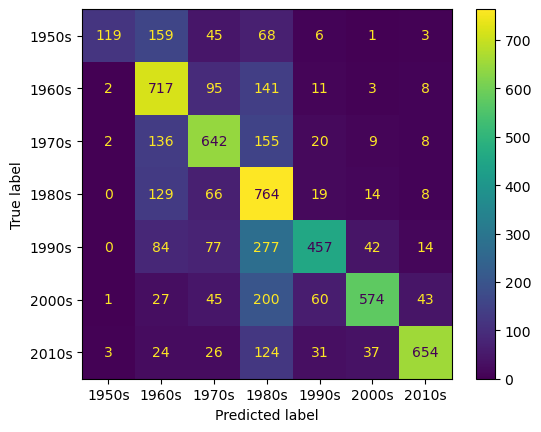

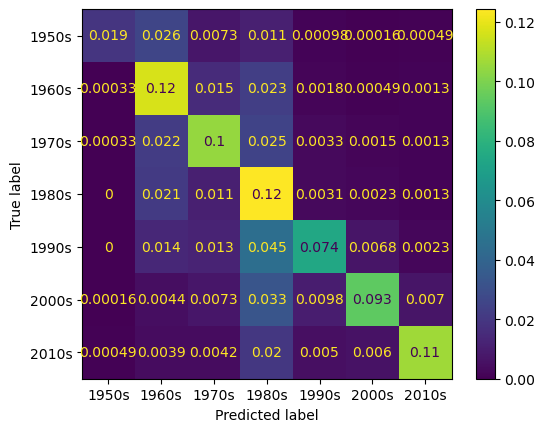

In [61]:
cm_sk=confusion_matrix(LyrFreqDF_2['Decade'],SKNB_FreqDF_2.predict(LyrFreqDF_2.iloc[:,2:]))
cm_sk_dsp=ConfusionMatrixDisplay(confusion_matrix=cm_sk,display_labels=SKNB_FreqDF_2.classes_)
cm_sk_dsp.plot()
plt.show()

cm_sk_n=confusion_matrix(LyrFreqDF_2['Decade'],SKNB_FreqDF_2.predict(LyrFreqDF_2.iloc[:,2:]),normalize='all')
cm_sk_dsp_n=ConfusionMatrixDisplay(confusion_matrix=cm_sk_n,display_labels=SKNB_FreqDF_2.classes_)
cm_sk_dsp_n.plot()
plt.show()

In [9]:
SKNB_estimatorFreqDF_2=SKNB_FreqDF_2.predict_proba(X_test)
SKNB_estimatorFreqDF_2[0]

array([1.08285875e-12, 9.17202303e-01, 2.90136500e-02, 5.37840466e-02,
       6.63236842e-10, 3.49641362e-19, 1.78781294e-17])

In [10]:
SKNB_topK=top_k_accuracy_score(y_test,SKNB_estimatorFreqDF_2,k=3)

In [11]:
SKNB_topK

0.7568270481144344

################################################################################
### Now try SVMs instead #######################################################
################################################################################

In [8]:
svm_test=svm.SVC(decision_function_shape='ovo')

In [9]:
svm_test2=svm.SVC(decision_function_shape='ovr')

In [10]:
svm_test_model=svm_test.fit(X_train,y_train)

In [11]:
svm_test_model2=svm_test2.fit(X_train,y_train)

In [12]:
svm_test_model.score(X_test,y_test)

0.34850455136540964

In [13]:
svm_test_model2.score(X_test,y_test)

0.34850455136540964

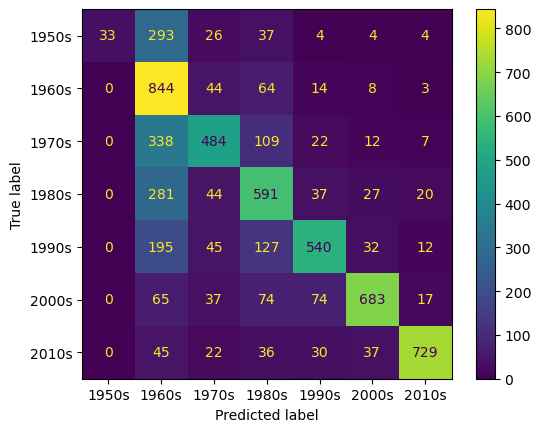

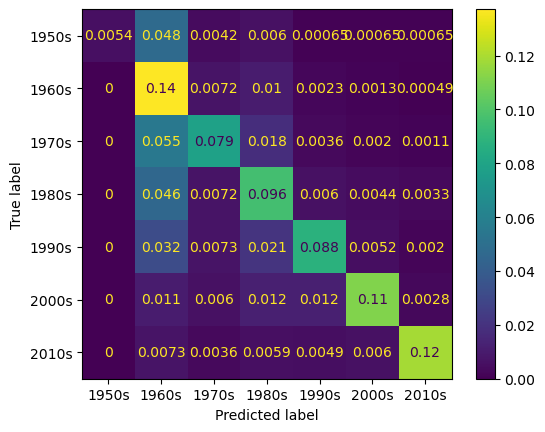

In [67]:
SVM_CM=svm_test.fit(LyrFreqDF_2.iloc[:,2:],LyrFreqDF_2['Decade'])
cm_sk=confusion_matrix(LyrFreqDF_2['Decade'],SVM_CM.predict(LyrFreqDF_2.iloc[:,2:]))
cm_sk_dsp=ConfusionMatrixDisplay(confusion_matrix=cm_sk,display_labels=SVM_CM.classes_)
cm_sk_dsp.plot()
plt.show()

cm_sk_n=confusion_matrix(LyrFreqDF_2['Decade'],SVM_CM.predict(LyrFreqDF_2.iloc[:,2:]),normalize='all')
cm_sk_dsp_n=ConfusionMatrixDisplay(confusion_matrix=cm_sk_n,display_labels=SVM_CM.classes_)
cm_sk_dsp_n.plot()
plt.show()

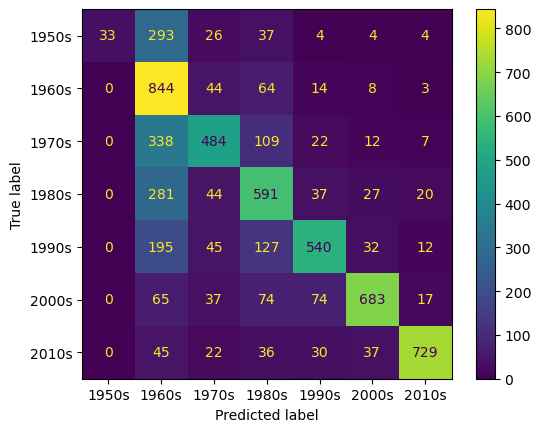

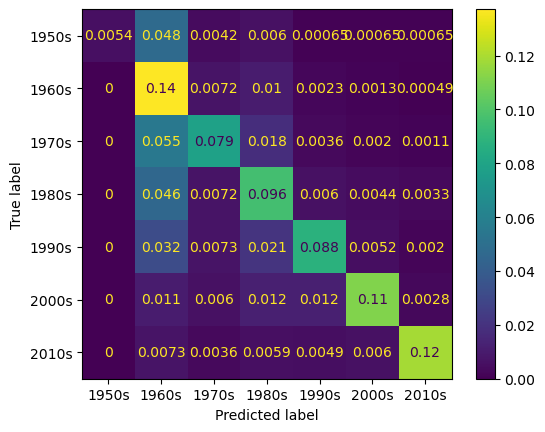

In [68]:
SVM_CM=svm_test2.fit(LyrFreqDF_2.iloc[:,2:],LyrFreqDF_2['Decade'])
cm_sk=confusion_matrix(LyrFreqDF_2['Decade'],SVM_CM.predict(LyrFreqDF_2.iloc[:,2:]))
cm_sk_dsp=ConfusionMatrixDisplay(confusion_matrix=cm_sk,display_labels=SVM_CM.classes_)
cm_sk_dsp.plot()
plt.show()

cm_sk_n=confusion_matrix(LyrFreqDF_2['Decade'],SVM_CM.predict(LyrFreqDF_2.iloc[:,2:]),normalize='all')
cm_sk_dsp_n=ConfusionMatrixDisplay(confusion_matrix=cm_sk_n,display_labels=SVM_CM.classes_)
cm_sk_dsp_n.plot()
plt.show()

In [19]:
SVM_DF=svm_test_model.decision_function(X_test)

In [20]:
SVM_DF[0]

array([-0.96059371, -0.90715006, -0.87232693, -0.25281931,  1.13205418,
        1.26795416,  0.76299189,  0.5039827 ,  1.01732053,  1.56969083,
        1.61869996, -0.03415705,  1.0591475 ,  1.48997575,  1.5143206 ,
        1.00635818,  1.35094618,  1.31686445,  1.19462724,  1.05602015,
        0.6901532 ])

In [21]:
SVM_DF2=svm_test_model2.decision_function(X_test)

In [29]:
SKSVM_topK=top_k_accuracy_score(y_test,SVM_DF,k=3)

ValueError: Number of classes in 'y_true' (7) not equal to the number of classes in 'y_score' (21).You can provide a list of all known classes by assigning it to the `labels` parameter.

In [22]:
SKSVM_topK=top_k_accuracy_score(y_test,SVM_DF2,k=3)

In [23]:
SKSVM_topK

0.723667100130039

################################################################################
### See if this works on the other frequency distribution ######################
################################################################################

0.4141742522756827


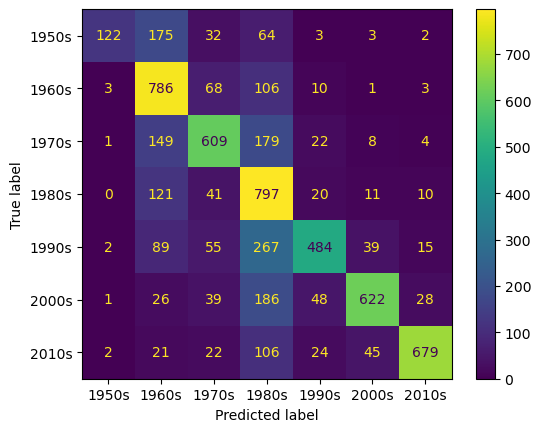

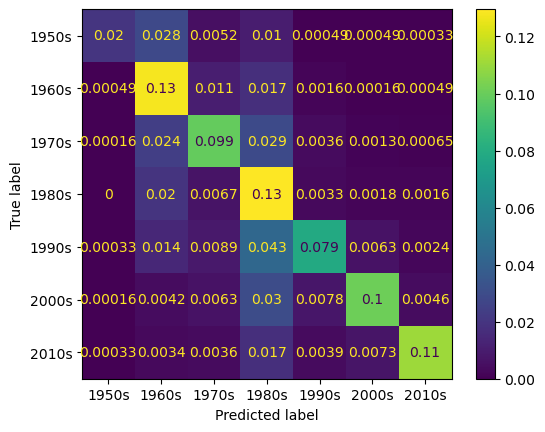

[2.39750836e-16 1.35847480e-01 4.98753644e-02 8.14277155e-01
 1.51350920e-10 3.29372323e-15 1.45306447e-18]


0.758777633289987

In [75]:
X_train, X_test, y_train, y_test = train_test_split(LyrFreqDF.iloc[:,2:], LyrFreqDF['Decade'])

SKNB_FreqDF=MultinomialNB()
SKNB_FreqDF.fit(X_train,y_train)

print(SKNB_FreqDF.score(X_test,y_test))

cm_sk=confusion_matrix(LyrFreqDF['Decade'],SKNB_FreqDF.predict(LyrFreqDF.iloc[:,2:]))
cm_sk_dsp=ConfusionMatrixDisplay(confusion_matrix=cm_sk,display_labels=SKNB_FreqDF.classes_)
cm_sk_dsp.plot()
plt.show()

cm_sk_n=confusion_matrix(LyrFreqDF['Decade'],SKNB_FreqDF.predict(LyrFreqDF.iloc[:,2:]),normalize='all')
cm_sk_dsp_n=ConfusionMatrixDisplay(confusion_matrix=cm_sk_n,display_labels=SKNB_FreqDF.classes_)
cm_sk_dsp_n.plot()
plt.show()

SKNB_estimator=SKNB_FreqDF.predict_proba(X_test)
print(SKNB_estimator[0])

SKNB_TopK=top_k_accuracy_score(y_test,SKNB_estimator,k=3)

SKNB_TopK

0.34070221066319895


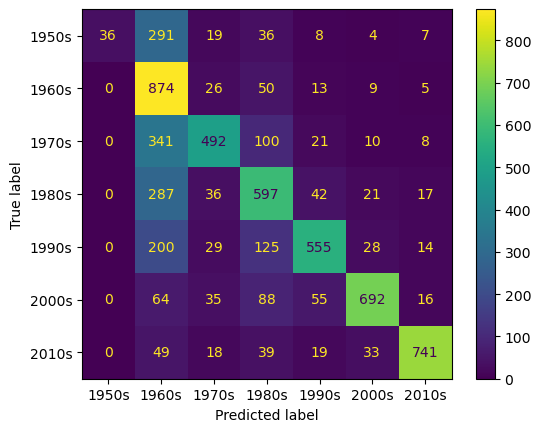

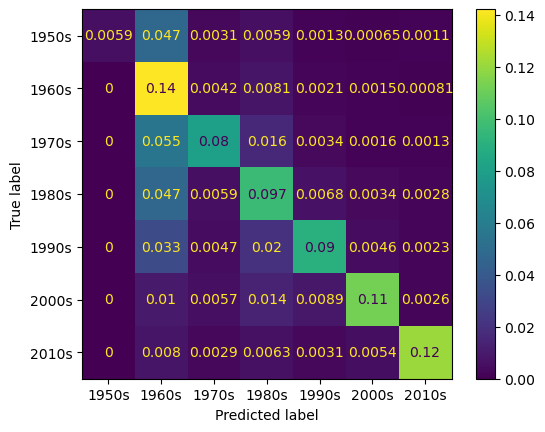

0.8693107932379714

In [76]:
svm_test=svm.SVC(decision_function_shape='ovr')
svm_test_model=svm_test.fit(X_train,y_train)

print(svm_test_model.score(X_test,y_test))

SVM_CM=svm_test.fit(LyrFreqDF.iloc[:,2:],LyrFreqDF['Decade'])
cm_sk=confusion_matrix(LyrFreqDF['Decade'],SVM_CM.predict(LyrFreqDF.iloc[:,2:]))
cm_sk_dsp=ConfusionMatrixDisplay(confusion_matrix=cm_sk,display_labels=SVM_CM.classes_)
cm_sk_dsp.plot()
plt.show()

cm_sk_n=confusion_matrix(LyrFreqDF['Decade'],SVM_CM.predict(LyrFreqDF.iloc[:,2:]),normalize='all')
cm_sk_dsp_n=ConfusionMatrixDisplay(confusion_matrix=cm_sk_n,display_labels=SVM_CM.classes_)
cm_sk_dsp_n.plot()
plt.show()

SVM_DF=svm_test_model.decision_function(X_test)

SVM_DF[0]

SKSVM_TopK=top_k_accuracy_score(y_test,SVM_DF,k=3)

SKSVM_TopK

In [85]:
## cross-validation ##
# this function takes the (number of folds, featureset_dataframe)
# it iterates over the folds, using random sections selected by train_test_split
#   it prints the top k accuracy for each fold (using multinomial naivebayes (MNB) model) and the average top k accuracy at the end
def cross_val_acc_topk_MNB(num_folds, feature_DF):
    subset_size = int(len(feature_DF)/num_folds)
    print('Each fold size:', subset_size)
    accuracy_list = []
    # iterate over the folds
    for i in range(num_folds):
        X_train, X_test, y_train, y_test = train_test_split(feature_DF.iloc[:,2:], feature_DF['Decade'],test_size=subset_size)
        # train using train_this_round
        classifier = SKNB_FreqDF.fit(X_train,y_train)
        # evaluate against test_this_round and save accuracy
        accuracy_this_round = top_k_accuracy_score(y_test,classifier.predict_proba(X_test),k=3)
        print (i, accuracy_this_round)
        accuracy_list.append(accuracy_this_round)
    # find mean accuracy over all rounds
    print ('mean accuracy', sum(accuracy_list) / num_folds)

In [86]:
cross_val_acc_topk_MNB(10,LyrFreqDF)

Each fold size: 615
0 0.7886178861788617
1 0.7658536585365854
2 0.7772357723577236
3 0.7853658536585366
4 0.7788617886178861
5 0.775609756097561
6 0.7609756097560976
7 0.7886178861788617
8 0.7642276422764228
9 0.7788617886178861
mean accuracy 0.7764227642276422


In [87]:
cross_val_acc_topk_MNB(10,LyrFreqDF_2)

Each fold size: 615
0 0.7642276422764228
1 0.7658536585365854
2 0.767479674796748
3 0.7463414634146341
4 0.7739837398373983
5 0.7723577235772358
6 0.767479674796748
7 0.751219512195122
8 0.7723577235772358
9 0.7691056910569106
mean accuracy 0.765040650406504


In [9]:
svm_test=svm.SVC(decision_function_shape='ovr')

In [10]:
## cross-validation ##
# this function takes the (number of folds, featureset_dataframe)
# it iterates over the folds, using random sections selected by train_test_split
#   it prints the top k accuracy for each fold using SVM and the average top k accuracy at the end
def cross_val_acc_topk_SVM(num_folds, feature_DF):
    subset_size = int(len(feature_DF)/num_folds)
    print('Each fold size:', subset_size)
    accuracy_list = []
    # iterate over the folds
    for i in range(num_folds):
        X_train, X_test, y_train, y_test = train_test_split(feature_DF.iloc[:,2:], feature_DF['Decade'],test_size=subset_size)
        # train using train_this_round
        classifier = svm_test.fit(X_train,y_train)
        # evaluate against test_this_round and save accuracy
        accuracy_this_round = top_k_accuracy_score(y_test,classifier.decision_function(X_test),k=3)
        print (i, accuracy_this_round)
        accuracy_list.append(accuracy_this_round)
    # find mean accuracy over all rounds
    print ('mean accuracy', sum(accuracy_list) / num_folds)

In [89]:
cross_val_acc_topk_SVM(10,LyrFreqDF)

Each fold size: 615
0 0.7528455284552845
1 0.71869918699187
2 0.734959349593496
3 0.7333333333333333
4 0.7528455284552845
5 0.7658536585365854
6 0.7333333333333333
7 0.7495934959349594
8 0.697560975609756
9 0.734959349593496
mean accuracy 0.73739837398374


In [11]:
cross_val_acc_topk_SVM(10,LyrFreqDF_2)

Each fold size: 615
0 0.71869918699187
1 0.7382113821138211
2 0.7219512195121951
3 0.7365853658536585
4 0.7658536585365854
5 0.7479674796747967
6 0.7268292682926829
7 0.7284552845528456
8 0.7235772357723578
9 0.7365853658536585
mean accuracy 0.7344715447154471


################################################################################
### Begin Feature Set and Modeling Work : POS Tagging ##########################
################################################################################

#LyrPOSDF || POS analysis with no stop words removed

#LyrPOSDF_NLTK || nltk stop words removed

#LyrPOSDF_SPC || spacey stop word removed

#LyrPOSDF_GM || gensim stop word removed

In [7]:
#collect feature set from POS analysis
feature_set_POS=[]
for i in LyrPOSDF.index:
    features_dict={}
    features_item=()
    for h in range(2,len(LyrPOSDF.columns)):
        features_dict[LyrPOSDF.columns[h]]=LyrPOSDF.loc[i,LyrPOSDF.columns[h]]
    features_item=(features_dict,LyrPOSDF.loc[i,'Decade'])
    feature_set_POS.append(features_item)

In [8]:
#now create the test and train set
random.shuffle(feature_set_POS)
cutoff=.80
split=round(len(feature_set_POS)*cutoff)
train_set=feature_set_POS[:split]
test_set=feature_set_POS[split:]

In [9]:
#create the model
POS_train_model=nltk.NaiveBayesClassifier.train(train_set)

In [432]:
#test for accuracy
nltk.classify.accuracy(POS_train_model, test_set)

0.3170731707317073

In [10]:
#collect feature set from POS_NLTK analysis
feature_set_NLTK=[]
for i in LyrPOSDF_NLTK.index:
    features_dict={}
    features_item=()
    for h in range(2,len(LyrPOSDF_NLTK.columns)):
        features_dict[LyrPOSDF_NLTK.columns[h]]=LyrPOSDF_NLTK.loc[i,LyrPOSDF_NLTK.columns[h]]
    features_item=(features_dict,LyrPOSDF_NLTK.loc[i,'Decade'])
    feature_set_NLTK.append(features_item)

In [11]:
#now create the test and train set
random.shuffle(feature_set_NLTK)
cutoff=.80
split=round(len(feature_set_NLTK)*cutoff)
train_set=feature_set_NLTK[:split]
test_set=feature_set_NLTK[split:]

In [12]:
#create the model
NLTK_train_model=nltk.NaiveBayesClassifier.train(train_set)

In [436]:
#test for accuracy
nltk.classify.accuracy(NLTK_train_model, test_set)

0.27967479674796747

In [13]:
#collect feature set from POS_SPC analysis
feature_set_SPC=[]
for i in LyrPOSDF_SPC.index:
    features_dict={}
    features_item=()
    for h in range(2,len(LyrPOSDF_SPC.columns)):
        features_dict[LyrPOSDF_SPC.columns[h]]=LyrPOSDF_SPC.loc[i,LyrPOSDF_SPC.columns[h]]
    features_item=(features_dict,LyrPOSDF_SPC.loc[i,'Decade'])
    feature_set_SPC.append(features_item)

In [14]:
#now create the test and train set
random.shuffle(feature_set_SPC)
cutoff=.80
split=round(len(feature_set_SPC)*cutoff)
train_set=feature_set_SPC[:split]
test_set=feature_set_SPC[split:]

In [15]:
#create the model
SPC_train_model=nltk.NaiveBayesClassifier.train(train_set)

In [440]:
#test for accuracy
nltk.classify.accuracy(SPC_train_model, test_set)

0.3130081300813008

In [16]:
#collect feature set from POS_GM analysis
feature_set_GM=[]
for i in LyrPOSDF_GM.index:
    features_dict={}
    features_item=()
    for h in range(2,len(LyrPOSDF_GM.columns)):
        features_dict[LyrPOSDF_GM.columns[h]]=LyrPOSDF_GM.loc[i,LyrPOSDF_GM.columns[h]]
    features_item=(features_dict,LyrPOSDF_GM.loc[i,'Decade'])
    feature_set_GM.append(features_item)

In [17]:
#now create the test and train set
random.shuffle(feature_set_GM)
cutoff=.80
split=round(len(feature_set_GM)*cutoff)
train_set=feature_set_GM[:split]
test_set=feature_set_GM[split:]

In [18]:
#create the model
GM_train_model=nltk.NaiveBayesClassifier.train(train_set)

In [444]:
#test for accuracy
nltk.classify.accuracy(GM_train_model, test_set)

0.3203252032520325

In [7]:
#perform cross validation 
def cross_validation_accuracy(num_folds, featuresets):
    subset_size = int(len(featuresets)/num_folds)
    print('Each fold size:', subset_size)
    accuracy_list = []
    # iterate over the folds
    for i in range(num_folds):
        test_this_round = featuresets[(i*subset_size):][:subset_size]
        train_this_round = featuresets[:(i*subset_size)] + featuresets[((i+1)*subset_size):]
        # train using train_this_round
        classifier = nltk.NaiveBayesClassifier.train(train_this_round)
        # evaluate against test_this_round and save accuracy
        accuracy_this_round = nltk.classify.accuracy(classifier, test_this_round)
        print (i, accuracy_this_round)
        accuracy_list.append(accuracy_this_round)
    # find mean accuracy over all rounds
    print ('mean accuracy', sum(accuracy_list) / num_folds)

In [12]:
cross_validation_accuracy(10, feature_set_POS)

Each fold size: 615
0 0.18699186991869918
1 0.14634146341463414
2 0.13658536585365855
3 0.12357723577235773
4 0.1040650406504065
5 0.0991869918699187
6 0.01951219512195122
7 0.04390243902439024
8 0.39186991869918697
9 0.024390243902439025
mean accuracy 0.1276422764227642


In [13]:
cross_validation_accuracy(10, feature_set_NLTK)

Each fold size: 615
0 0.17560975609756097
1 0.07317073170731707
2 0.13658536585365855
3 0.07642276422764227
4 0.024390243902439025
5 0.0910569105691057
6 0.030894308943089432
7 0.22439024390243903
8 0.3853658536585366
9 0.191869918699187
mean accuracy 0.14097560975609755


In [15]:
cross_validation_accuracy(10, feature_set_SPC)

Each fold size: 615
0 0.11544715447154472
1 0.06341463414634146
2 0.12682926829268293
3 0.08943089430894309
4 0.056910569105691054
5 0.13008130081300814
6 0.02113821138211382
7 0.22439024390243903
8 0.34471544715447155
9 0.2016260162601626
mean accuracy 0.13739837398373983


In [26]:
cross_validation_accuracy(10, feature_set_GM)

Each fold size: 615
0 0.13821138211382114
1 0.07479674796747968
2 0.12357723577235773
3 0.0991869918699187
4 0.05365853658536585
5 0.11056910569105691
6 0.02113821138211382
7 0.21951219512195122
8 0.3300813008130081
9 0.21138211382113822
mean accuracy 0.13821138211382114


################################################################################
### Now look at confusion matrix, precision, recall, F1 ########################
################################################################################

In [19]:
#####first looking at POS tag, no stop words#####
#now create the test and train set
random.shuffle(feature_set_POS)
cutoff=.80
split=round(len(feature_set_POS)*cutoff)
train_set=feature_set_POS[:split]
test_set=feature_set_POS[split:]

goldlist = []
predictedlist = []
for (features, label) in test_set:
    	goldlist.append(label)
    	predictedlist.append(POS_train_model.classify(features))

# look at the first 30 examples
print(goldlist[:30])
print(predictedlist[:30])

cm = nltk.ConfusionMatrix(goldlist, predictedlist)
print(cm.pretty_format(sort_by_count=True, truncate=9))

# or show the results as percentages
print(cm.pretty_format(sort_by_count=True, show_percents=True, truncate=9))

# Function to compute precision, recall and F1 for each label
#  and for any number of labels
# Input: list of gold labels, list of predicted labels (in same order)
# Output:  prints precision, recall and F1 for each label
def eval_measures(gold, predicted):
    # get a list of labels
    labels = list(set(gold))
    # these lists have values for each label 
    recall_list = []
    precision_list = []
    F1_list = []
    for lab in labels:
        # for each label, compare gold and predicted lists and compute values
        TP = FP = FN = TN = 0
        for i, val in enumerate(gold):
            if val == lab and predicted[i] == lab:  TP += 1
            if val == lab and predicted[i] != lab:  FN += 1
            if val != lab and predicted[i] == lab:  FP += 1
            if val != lab and predicted[i] != lab:  TN += 1
        # use these to compute recall, precision, F1
        recall = TP / (TP + FP)
        precision = TP / (TP + FN)
        recall_list.append(recall)
        precision_list.append(precision)
        F1_list.append( 2 * (recall * precision) / (recall + precision))

    # the evaluation measures in a table with one row per label
    print('\tPrecision\tRecall\t\tF1')
    # print measures for each label
    for i, lab in enumerate(labels):
        print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
          "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(F1_list[i]))

# call the function with our data
eval_measures(goldlist, predictedlist)

['1980s', '2010s', '1960s', '1980s', '1970s', '2010s', '2000s', '1980s', '2000s', '2010s', '1990s', '1960s', '2010s', '1970s', '2000s', '1980s', '1970s', '2000s', '1970s', '1980s', '2010s', '1980s', '2000s', '1970s', '1960s', '1960s', '1960s', '1970s', '1980s', '2010s']
['1970s', '2010s', '1960s', '1980s', '1960s', '2010s', '1960s', '1980s', '2000s', '1990s', '2000s', '1960s', '2010s', '1950s', '2000s', '2000s', '1970s', '2000s', '1970s', '1980s', '1970s', '1960s', '2000s', '2010s', '1960s', '1960s', '1960s', '1970s', '1980s', '2010s']
      |   1   1   1   2   1   2   1 |
      |   9   9   9   0   9   0   9 |
      |   8   7   9   0   6   1   5 |
      |   0   0   0   0   0   0   0 |
      |   s   s   s   s   s   s   s |
------+-----------------------------+
1980s |<111> 17   5  18  24  18  11 |
1970s |   4<123> 13  11  23   7  15 |
1990s |   8  16 <97> 24  28  10  13 |
2000s |   6   9   8<145> 11  15   2 |
1960s |   9  12  10   1<137>  8  13 |
2010s |   8   8   2  15   6<132>  5 |
19

In [20]:
#####looking at POS tag, NLTK stop words#####
#now create the test and train set
random.shuffle(feature_set_NLTK)
cutoff=.80
split=round(len(feature_set_NLTK)*cutoff)
train_set=feature_set_NLTK[:split]
test_set=feature_set_NLTK[split:]

goldlist = []
predictedlist = []
for (features, label) in test_set:
    	goldlist.append(label)
    	predictedlist.append(NLTK_train_model.classify(features))

# look at the first 30 examples
print(goldlist[:30])
print(predictedlist[:30])

cm = nltk.ConfusionMatrix(goldlist, predictedlist)
print(cm.pretty_format(sort_by_count=True, truncate=9))

# or show the results as percentages
print(cm.pretty_format(sort_by_count=True, show_percents=True, truncate=9))

# Function to compute precision, recall and F1 for each label
#  and for any number of labels
# Input: list of gold labels, list of predicted labels (in same order)
# Output:  prints precision, recall and F1 for each label
def eval_measures(gold, predicted):
    # get a list of labels
    labels = list(set(gold))
    # these lists have values for each label 
    recall_list = []
    precision_list = []
    F1_list = []
    for lab in labels:
        # for each label, compare gold and predicted lists and compute values
        TP = FP = FN = TN = 0
        for i, val in enumerate(gold):
            if val == lab and predicted[i] == lab:  TP += 1
            if val == lab and predicted[i] != lab:  FN += 1
            if val != lab and predicted[i] == lab:  FP += 1
            if val != lab and predicted[i] != lab:  TN += 1
        # use these to compute recall, precision, F1
        recall = TP / (TP + FP)
        precision = TP / (TP + FN)
        recall_list.append(recall)
        precision_list.append(precision)
        F1_list.append( 2 * (recall * precision) / (recall + precision))

    # the evaluation measures in a table with one row per label
    print('\tPrecision\tRecall\t\tF1')
    # print measures for each label
    for i, lab in enumerate(labels):
        print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
          "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(F1_list[i]))

# call the function with our data
eval_measures(goldlist, predictedlist)

['2000s', '1990s', '1970s', '1980s', '2010s', '1980s', '1980s', '1960s', '1980s', '1980s', '2000s', '1980s', '1970s', '1980s', '2000s', '2010s', '1970s', '1960s', '2000s', '1990s', '1970s', '1950s', '2010s', '1970s', '1990s', '1970s', '1970s', '1990s', '1970s', '1950s']
['2000s', '1990s', '2010s', '1980s', '2010s', '1980s', '1980s', '1960s', '2010s', '1980s', '2000s', '2000s', '1970s', '1980s', '2000s', '2010s', '1970s', '1960s', '2000s', '1990s', '2000s', '1950s', '2010s', '1950s', '1990s', '1950s', '1970s', '1960s', '1970s', '1990s']
      |   1   2   1   1   1   2   1 |
      |   9   0   9   9   9   0   9 |
      |   8   0   9   6   7   1   5 |
      |   0   0   0   0   0   0   0 |
      |   s   s   s   s   s   s   s |
------+-----------------------------+
1980s |<113> 16   8  27  19  10  15 |
2000s |   8<148> 13  11  13  12   1 |
1990s |  10  25<110> 26  13   7   5 |
1960s |   6   3   6<147>  9   6  13 |
1970s |  10  11   7  27<115>  4  11 |
2010s |   6  16   4   8  10<125>  4 |
19

In [21]:
#####looking at POS tag, spacey stop words#####
#now create the test and train set
random.shuffle(feature_set_SPC)
cutoff=.80
split=round(len(feature_set_SPC)*cutoff)
train_set=feature_set_SPC[:split]
test_set=feature_set_SPC[split:]

goldlist = []
predictedlist = []
for (features, label) in test_set:
    	goldlist.append(label)
    	predictedlist.append(SPC_train_model.classify(features))

# look at the first 30 examples
print(goldlist[:30])
print(predictedlist[:30])

cm = nltk.ConfusionMatrix(goldlist, predictedlist)
print(cm.pretty_format(sort_by_count=True, truncate=9))

# or show the results as percentages
print(cm.pretty_format(sort_by_count=True, show_percents=True, truncate=9))

# Function to compute precision, recall and F1 for each label
#  and for any number of labels
# Input: list of gold labels, list of predicted labels (in same order)
# Output:  prints precision, recall and F1 for each label
def eval_measures(gold, predicted):
    # get a list of labels
    labels = list(set(gold))
    # these lists have values for each label 
    recall_list = []
    precision_list = []
    F1_list = []
    for lab in labels:
        # for each label, compare gold and predicted lists and compute values
        TP = FP = FN = TN = 0
        for i, val in enumerate(gold):
            if val == lab and predicted[i] == lab:  TP += 1
            if val == lab and predicted[i] != lab:  FN += 1
            if val != lab and predicted[i] == lab:  FP += 1
            if val != lab and predicted[i] != lab:  TN += 1
        # use these to compute recall, precision, F1
        recall = TP / (TP + FP)
        precision = TP / (TP + FN)
        recall_list.append(recall)
        precision_list.append(precision)
        F1_list.append( 2 * (recall * precision) / (recall + precision))

    # the evaluation measures in a table with one row per label
    print('\tPrecision\tRecall\t\tF1')
    # print measures for each label
    for i, lab in enumerate(labels):
        print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
          "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(F1_list[i]))

# call the function with our data
eval_measures(goldlist, predictedlist)

['1980s', '2000s', '1970s', '1990s', '1960s', '2010s', '2000s', '2000s', '1970s', '1950s', '2000s', '2000s', '1990s', '1960s', '1950s', '1970s', '1970s', '1960s', '1990s', '1970s', '2010s', '1970s', '2000s', '1970s', '1990s', '1950s', '1990s', '1980s', '2010s', '1970s']
['1980s', '1980s', '1970s', '1990s', '1960s', '1980s', '2000s', '1970s', '1970s', '1980s', '2000s', '2000s', '1980s', '1960s', '1970s', '1970s', '1990s', '1960s', '1960s', '1970s', '1990s', '1970s', '2010s', '1970s', '1980s', '1950s', '1980s', '1970s', '2010s', '2010s']
      |   1   1   2   2   1   1   1 |
      |   9   9   0   0   9   9   9 |
      |   6   8   0   1   9   7   5 |
      |   0   0   0   0   0   0   0 |
      |   s   s   s   s   s   s   s |
------+-----------------------------+
1960s |<153> 12   2   6   8   9  17 |
1980s |  24<132>  8   7   9  14   3 |
2000s |  18  18<134> 10   7   9   1 |
2010s |   2  10   8<139> 15  10   5 |
1990s |  18  23  19  10 <96> 10  10 |
1970s |  19  10  12   9   7<115> 10 |
19

In [22]:
#####looking at POS tag, gensim stop words#####
#now create the test and train set
random.shuffle(feature_set_GM)
cutoff=.80
split=round(len(feature_set_GM)*cutoff)
train_set=feature_set_GM[:split]
test_set=feature_set_GM[split:]

goldlist = []
predictedlist = []
for (features, label) in test_set:
    	goldlist.append(label)
    	predictedlist.append(GM_train_model.classify(features))

# look at the first 30 examples
print(goldlist[:30])
print(predictedlist[:30])

cm = nltk.ConfusionMatrix(goldlist, predictedlist)
print(cm.pretty_format(sort_by_count=True, truncate=9))

# or show the results as percentages
print(cm.pretty_format(sort_by_count=True, show_percents=True, truncate=9))

# Function to compute precision, recall and F1 for each label
#  and for any number of labels
# Input: list of gold labels, list of predicted labels (in same order)
# Output:  prints precision, recall and F1 for each label
def eval_measures(gold, predicted):
    # get a list of labels
    labels = list(set(gold))
    # these lists have values for each label 
    recall_list = []
    precision_list = []
    F1_list = []
    for lab in labels:
        # for each label, compare gold and predicted lists and compute values
        TP = FP = FN = TN = 0
        for i, val in enumerate(gold):
            if val == lab and predicted[i] == lab:  TP += 1
            if val == lab and predicted[i] != lab:  FN += 1
            if val != lab and predicted[i] == lab:  FP += 1
            if val != lab and predicted[i] != lab:  TN += 1
        # use these to compute recall, precision, F1
        recall = TP / (TP + FP)
        precision = TP / (TP + FN)
        recall_list.append(recall)
        precision_list.append(precision)
        F1_list.append( 2 * (recall * precision) / (recall + precision))

    # the evaluation measures in a table with one row per label
    print('\tPrecision\tRecall\t\tF1')
    # print measures for each label
    for i, lab in enumerate(labels):
        print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
          "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(F1_list[i]))

# call the function with our data
eval_measures(goldlist, predictedlist)

['2000s', '2000s', '1960s', '1980s', '1970s', '2000s', '1960s', '2010s', '2000s', '1970s', '1990s', '1960s', '1960s', '2000s', '2000s', '2010s', '1950s', '2000s', '2000s', '2010s', '1960s', '1960s', '1970s', '1980s', '2010s', '1990s', '1950s', '1950s', '2010s', '2010s']
['1980s', '1970s', '1960s', '1980s', '1970s', '2000s', '1960s', '2010s', '2000s', '1970s', '1990s', '1960s', '1960s', '2000s', '1960s', '1980s', '1950s', '2000s', '2000s', '2010s', '1960s', '1960s', '2010s', '2010s', '1990s', '1990s', '1980s', '1950s', '2010s', '2010s']
      |   1   1   1   1   2   2   1 |
      |   9   9   9   9   0   0   9 |
      |   8   9   7   6   0   1   5 |
      |   0   0   0   0   0   0   0 |
      |   s   s   s   s   s   s   s |
------+-----------------------------+
1980s |<147>  9  10  23  10  14   8 |
1990s |  29 <98> 14  23  22  13   8 |
1970s |  22   5<127> 19  11  10   7 |
1960s |  15   5   8<149>  3   5   8 |
2000s |  13   5  15  11<126> 10   1 |
2010s |  13   6   4   9   5<125>  1 |
19

################################################################################
### Use sklearn and top n predictors instead ###################################
################################################################################

In [23]:
SKMNB=MultinomialNB()

In [24]:
svm_test=svm.SVC(decision_function_shape='ovr')

Multinomial Naivebayes Accuracy: 0.2834850455136541

Multinomial Confusion Matrix:


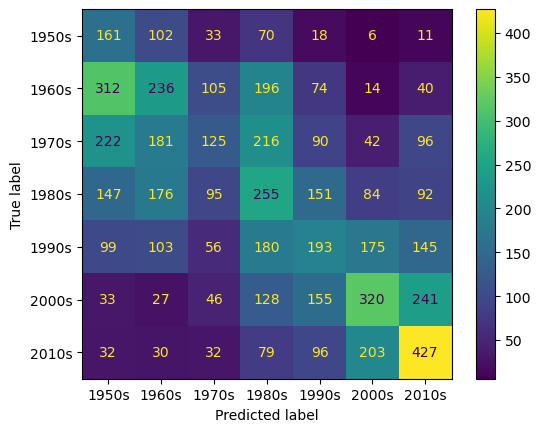


Normalized Multinomial Confusion Matrix:


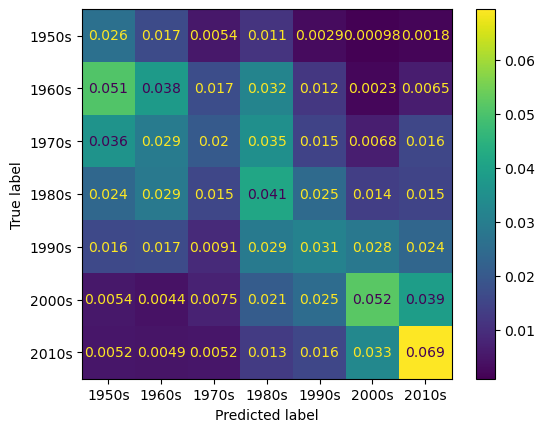

Multinomial TopK Accuracy: 0.6853055916775033


SVM Model Accuracy: 0.33224967490247076

SVM Confusion Matrix:


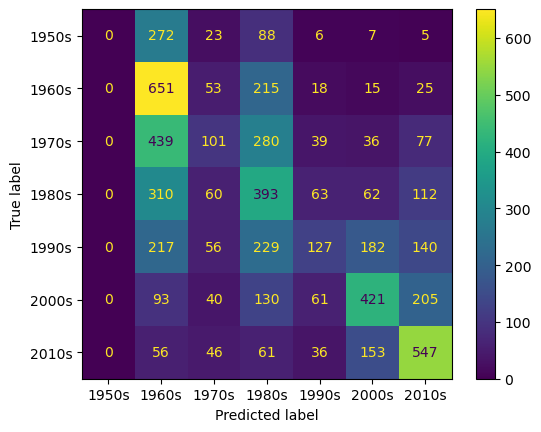


Normalized SVM Confusion Matrix:


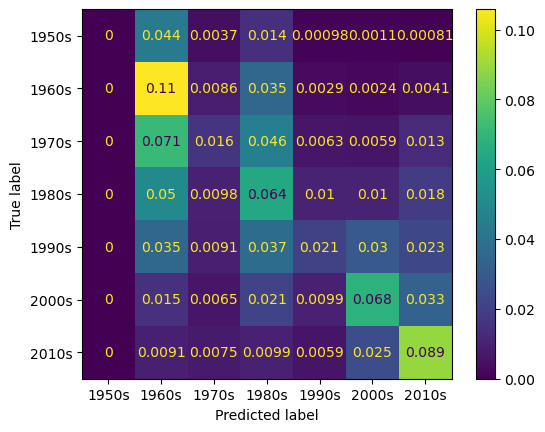

SVM TopK Accuracy: 0.7496749024707412


In [67]:
####first just POS tags
####Multinomial Naivebayes
X_train, X_test, y_train, y_test = train_test_split(LyrPOSDF.iloc[:,2:], LyrPOSDF['Decade'])

SKNB_POS=SKMNB.fit(X_train,y_train)

SKNB_POS_Score=SKNB_POS.score(X_test,y_test)
print('Multinomial Naivebayes Accuracy:', SKNB_POS_Score)

print('\nMultinomial Confusion Matrix:')
cm_sk=confusion_matrix(LyrPOSDF['Decade'],SKNB_POS.predict(LyrPOSDF.iloc[:,2:]))
cm_sk_dsp=ConfusionMatrixDisplay(confusion_matrix=cm_sk,display_labels=SKNB_POS.classes_)
cm_sk_dsp.plot()
plt.show()

print('\nNormalized Multinomial Confusion Matrix:')
cm_sk_n=confusion_matrix(LyrPOSDF['Decade'],SKNB_POS.predict(LyrPOSDF.iloc[:,2:]),normalize='all')
cm_sk_dsp_n=ConfusionMatrixDisplay(confusion_matrix=cm_sk_n,display_labels=SKNB_POS.classes_)
cm_sk_dsp_n.plot()
plt.show()

SKNB_estimatorPOS=SKNB_POS.predict_proba(X_test)

SKNB_POS_topK=top_k_accuracy_score(y_test,SKNB_estimatorPOS,k=3)
print('Multinomial TopK Accuracy:',SKNB_POS_topK)

#####Now SVM
print('\n')
svm_test_model=svm_test.fit(X_train,y_train)
print('SVM Model Accuracy:',svm_test_model.score(X_test,y_test))

print('\nSVM Confusion Matrix:')
SVM_CM=svm_test.fit(LyrPOSDF.iloc[:,2:],LyrPOSDF['Decade'])
cm_sk=confusion_matrix(LyrPOSDF['Decade'],SVM_CM.predict(LyrPOSDF.iloc[:,2:]))
cm_sk_dsp=ConfusionMatrixDisplay(confusion_matrix=cm_sk,display_labels=SVM_CM.classes_)
cm_sk_dsp.plot()
plt.show()

print('\nNormalized SVM Confusion Matrix:')
cm_sk_n=confusion_matrix(LyrPOSDF['Decade'],SVM_CM.predict(LyrPOSDF.iloc[:,2:]),normalize='all')
cm_sk_dsp_n=ConfusionMatrixDisplay(confusion_matrix=cm_sk_n,display_labels=SVM_CM.classes_)
cm_sk_dsp_n.plot()
plt.show()

SVM_DF=svm_test_model.decision_function(X_test)
SKSVM_topK=top_k_accuracy_score(y_test,SVM_DF,k=3)
print('SVM TopK Accuracy:', SKSVM_topK)

Multinomial Naivebayes Accuracy: 0.2516254876462939

Multinomial Confusion Matrix:


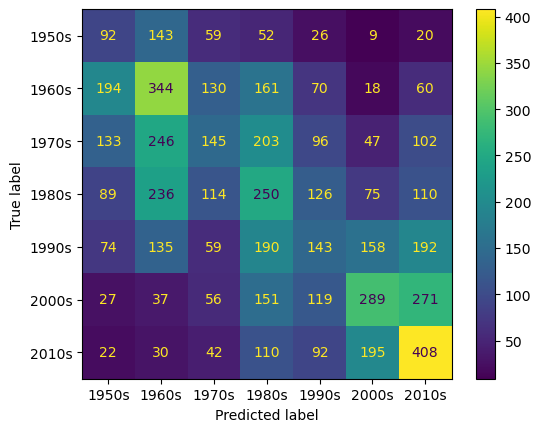


Normalized Multinomial Confusion Matrix:


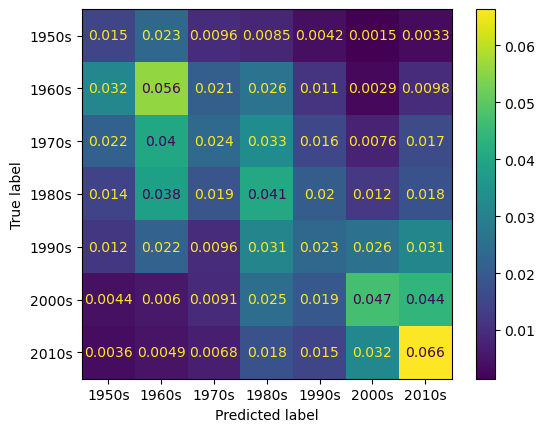

Multinomial TopK Accuracy: 0.6521456436931079


SVM Model Accuracy: 0.3127438231469441

SVM Confusion Matrix:


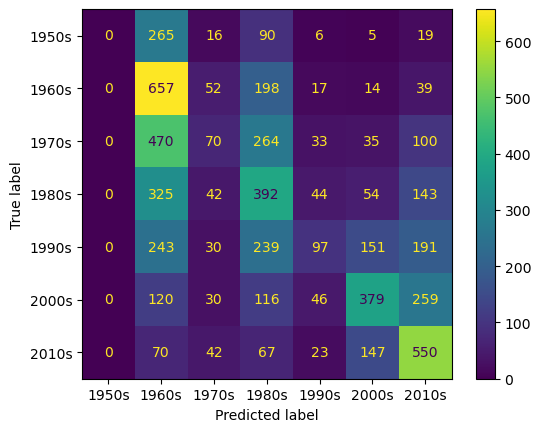


Normalized SVM Confusion Matrix:


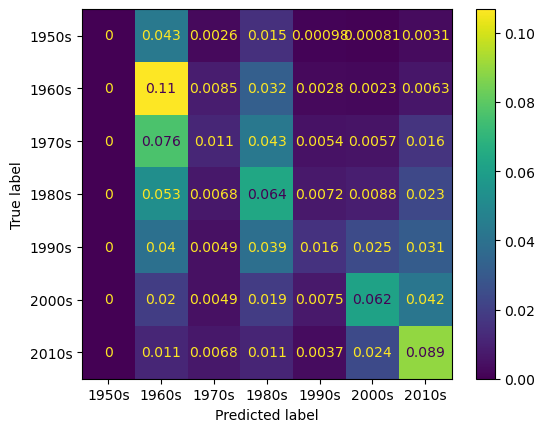

SVM TopK Accuracy: 0.7431729518855656


In [68]:
####now nltk stop words
####Multinomial Naivebayes
X_train, X_test, y_train, y_test = train_test_split(LyrPOSDF_NLTK.iloc[:,2:], LyrPOSDF_NLTK['Decade'])

SKNB_NLTK=SKMNB.fit(X_train,y_train)

SKNB_NLTK_Score=SKNB_NLTK.score(X_test,y_test)
print('Multinomial Naivebayes Accuracy:', SKNB_NLTK_Score)

print('\nMultinomial Confusion Matrix:')
cm_sk=confusion_matrix(LyrPOSDF_NLTK['Decade'],SKNB_NLTK.predict(LyrPOSDF_NLTK.iloc[:,2:]))
cm_sk_dsp=ConfusionMatrixDisplay(confusion_matrix=cm_sk,display_labels=SKNB_NLTK.classes_)
cm_sk_dsp.plot()
plt.show()

print('\nNormalized Multinomial Confusion Matrix:')
cm_sk_n=confusion_matrix(LyrPOSDF_NLTK['Decade'],SKNB_NLTK.predict(LyrPOSDF_NLTK.iloc[:,2:]),normalize='all')
cm_sk_dsp_n=ConfusionMatrixDisplay(confusion_matrix=cm_sk_n,display_labels=SKNB_NLTK.classes_)
cm_sk_dsp_n.plot()
plt.show()

SKNB_estimatorNLTK=SKNB_NLTK.predict_proba(X_test)

SKNB_NLTK_topK=top_k_accuracy_score(y_test,SKNB_estimatorNLTK,k=3)
print('Multinomial TopK Accuracy:',SKNB_NLTK_topK)

#####Now SVM
print('\n')
svm_test_model=svm_test.fit(X_train,y_train)
print('SVM Model Accuracy:',svm_test_model.score(X_test,y_test))

print('\nSVM Confusion Matrix:')
SVM_CM=svm_test.fit(LyrPOSDF_NLTK.iloc[:,2:],LyrPOSDF_NLTK['Decade'])
cm_sk=confusion_matrix(LyrPOSDF_NLTK['Decade'],SVM_CM.predict(LyrPOSDF_NLTK.iloc[:,2:]))
cm_sk_dsp=ConfusionMatrixDisplay(confusion_matrix=cm_sk,display_labels=SVM_CM.classes_)
cm_sk_dsp.plot()
plt.show()

print('\nNormalized SVM Confusion Matrix:')
cm_sk_n=confusion_matrix(LyrPOSDF_NLTK['Decade'],SVM_CM.predict(LyrPOSDF_NLTK.iloc[:,2:]),normalize='all')
cm_sk_dsp_n=ConfusionMatrixDisplay(confusion_matrix=cm_sk_n,display_labels=SVM_CM.classes_)
cm_sk_dsp_n.plot()
plt.show()

SVM_DF=svm_test_model.decision_function(X_test)
SKSVM_topK=top_k_accuracy_score(y_test,SVM_DF,k=3)
print('SVM TopK Accuracy:', SKSVM_topK)

Multinomial Naivebayes Accuracy: 0.2665799739921977

Multinomial Confusion Matrix:


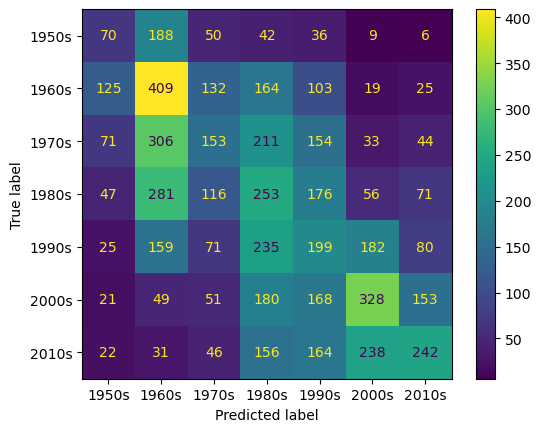


Normalized Multinomial Confusion Matrix:


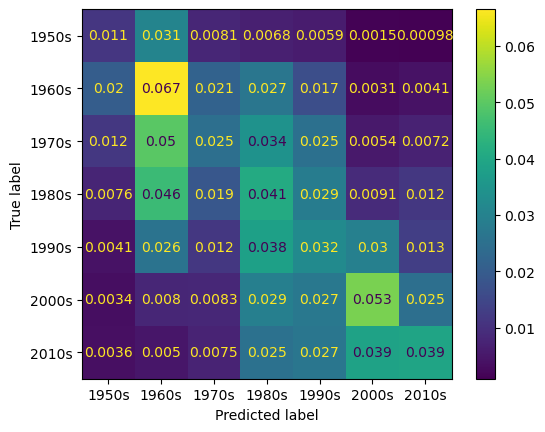

Multinomial TopK Accuracy: 0.6560468140442133


SVM Model Accuracy: 0.3088426527958388

SVM Confusion Matrix:


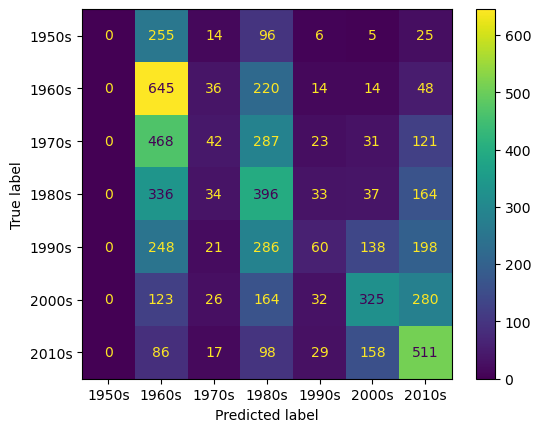


Normalized SVM Confusion Matrix:


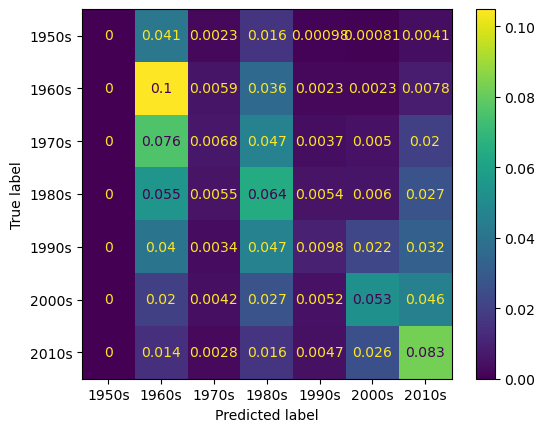

SVM TopK Accuracy: 0.7444733420026007


In [69]:
####now spacey stop words
####Multinomial Naivebayes
X_train, X_test, y_train, y_test = train_test_split(LyrPOSDF_SPC.iloc[:,2:], LyrPOSDF_SPC['Decade'])

SKNB_SPC=SKMNB.fit(X_train,y_train)

SKNB_SPC_Score=SKNB_SPC.score(X_test,y_test)
print('Multinomial Naivebayes Accuracy:', SKNB_SPC_Score)

print('\nMultinomial Confusion Matrix:')
cm_sk=confusion_matrix(LyrPOSDF_SPC['Decade'],SKNB_SPC.predict(LyrPOSDF_SPC.iloc[:,2:]))
cm_sk_dsp=ConfusionMatrixDisplay(confusion_matrix=cm_sk,display_labels=SKNB_SPC.classes_)
cm_sk_dsp.plot()
plt.show()

print('\nNormalized Multinomial Confusion Matrix:')
cm_sk_n=confusion_matrix(LyrPOSDF_SPC['Decade'],SKNB_SPC.predict(LyrPOSDF_SPC.iloc[:,2:]),normalize='all')
cm_sk_dsp_n=ConfusionMatrixDisplay(confusion_matrix=cm_sk_n,display_labels=SKNB_SPC.classes_)
cm_sk_dsp_n.plot()
plt.show()

SKNB_estimatorSPC=SKNB_SPC.predict_proba(X_test)

SKNB_SPC_topK=top_k_accuracy_score(y_test,SKNB_estimatorSPC,k=3)
print('Multinomial TopK Accuracy:',SKNB_SPC_topK)

#####Now SVM
print('\n')
svm_test_model=svm_test.fit(X_train,y_train)
print('SVM Model Accuracy:',svm_test_model.score(X_test,y_test))

print('\nSVM Confusion Matrix:')
SVM_CM=svm_test.fit(LyrPOSDF_SPC.iloc[:,2:],LyrPOSDF_SPC['Decade'])
cm_sk=confusion_matrix(LyrPOSDF_SPC['Decade'],SVM_CM.predict(LyrPOSDF_SPC.iloc[:,2:]))
cm_sk_dsp=ConfusionMatrixDisplay(confusion_matrix=cm_sk,display_labels=SVM_CM.classes_)
cm_sk_dsp.plot()
plt.show()

print('\nNormalized SVM Confusion Matrix:')
cm_sk_n=confusion_matrix(LyrPOSDF_SPC['Decade'],SVM_CM.predict(LyrPOSDF_SPC.iloc[:,2:]),normalize='all')
cm_sk_dsp_n=ConfusionMatrixDisplay(confusion_matrix=cm_sk_n,display_labels=SVM_CM.classes_)
cm_sk_dsp_n.plot()
plt.show()

SVM_DF=svm_test_model.decision_function(X_test)
SKSVM_topK=top_k_accuracy_score(y_test,SVM_DF,k=3)
print('SVM TopK Accuracy:', SKSVM_topK)

Multinomial Naivebayes Accuracy: 0.2626788036410923

Multinomial Confusion Matrix:


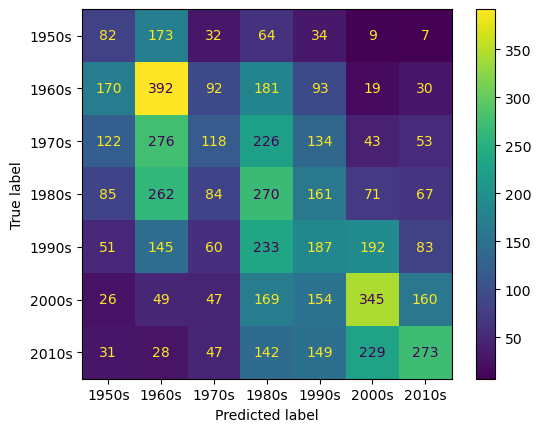


Normalized Multinomial Confusion Matrix:


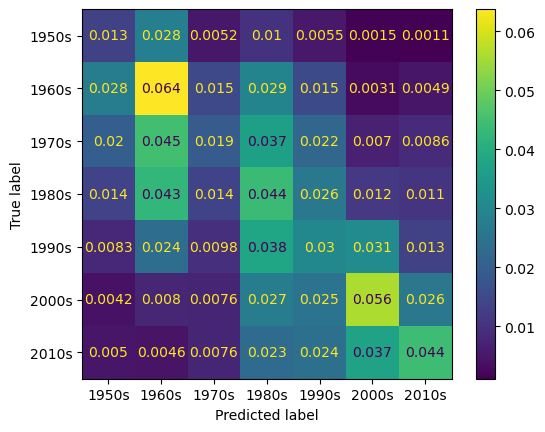

Multinomial TopK Accuracy: 0.6729518855656696


SVM Model Accuracy: 0.28608582574772434

SVM Confusion Matrix:


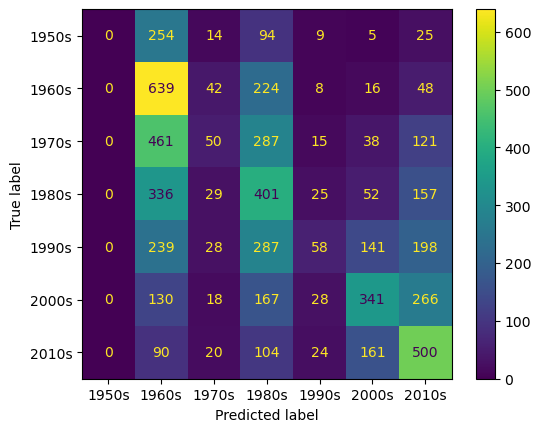


Normalized SVM Confusion Matrix:


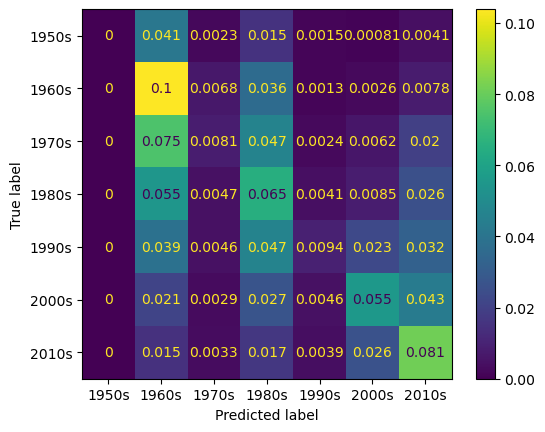

SVM TopK Accuracy: 0.7100130039011704


In [27]:
####now gensim stop words
####Multinomial Naivebayes
X_train, X_test, y_train, y_test = train_test_split(LyrPOSDF_GM.iloc[:,2:], LyrPOSDF_GM['Decade'])

SKNB_GM=SKMNB.fit(X_train,y_train)

SKNB_GM_Score=SKNB_GM.score(X_test,y_test)
print('Multinomial Naivebayes Accuracy:', SKNB_GM_Score)

print('\nMultinomial Confusion Matrix:')
cm_sk=confusion_matrix(LyrPOSDF_GM['Decade'],SKNB_GM.predict(LyrPOSDF_GM.iloc[:,2:]))
cm_sk_dsp=ConfusionMatrixDisplay(confusion_matrix=cm_sk,display_labels=SKNB_GM.classes_)
cm_sk_dsp.plot()
plt.show()

print('\nNormalized Multinomial Confusion Matrix:')
cm_sk_n=confusion_matrix(LyrPOSDF_GM['Decade'],SKNB_GM.predict(LyrPOSDF_GM.iloc[:,2:]),normalize='all')
cm_sk_dsp_n=ConfusionMatrixDisplay(confusion_matrix=cm_sk_n,display_labels=SKNB_GM.classes_)
cm_sk_dsp_n.plot()
plt.show()

SKNB_estimatorGM=SKNB_GM.predict_proba(X_test)

SKNB_GM_topK=top_k_accuracy_score(y_test,SKNB_estimatorGM,k=3)
print('Multinomial TopK Accuracy:',SKNB_GM_topK)

#####Now SVM
print('\n')
svm_test_model=svm_test.fit(X_train,y_train)
print('SVM Model Accuracy:',svm_test_model.score(X_test,y_test))

print('\nSVM Confusion Matrix:')
SVM_CM=svm_test.fit(LyrPOSDF_GM.iloc[:,2:],LyrPOSDF_GM['Decade'])
cm_sk=confusion_matrix(LyrPOSDF_GM['Decade'],SVM_CM.predict(LyrPOSDF_GM.iloc[:,2:]))
cm_sk_dsp=ConfusionMatrixDisplay(confusion_matrix=cm_sk,display_labels=SVM_CM.classes_)
cm_sk_dsp.plot()
plt.show()

print('\nNormalized SVM Confusion Matrix:')
cm_sk_n=confusion_matrix(LyrPOSDF_GM['Decade'],SVM_CM.predict(LyrPOSDF_GM.iloc[:,2:]),normalize='all')
cm_sk_dsp_n=ConfusionMatrixDisplay(confusion_matrix=cm_sk_n,display_labels=SVM_CM.classes_)
cm_sk_dsp_n.plot()
plt.show()

SVM_DF=svm_test_model.decision_function(X_test)
SKSVM_topK=top_k_accuracy_score(y_test,SVM_DF,k=3)
print('SVM TopK Accuracy:', SKSVM_topK)

In [71]:
##multinomial model cross-validation ##
# this function takes the (number of folds, featureset_dataframe)
# it iterates over the folds, using random sections selected by train_test_split
#   it prints the top k accuracy for each fold (using multinomial naivebayes (MNB) model) and the average top k accuracy at the end
def cross_val_acc_topk_MNB(num_folds, feature_DF):
    subset_size = int(len(feature_DF)/num_folds)
    print('Each fold size:', subset_size)
    accuracy_list = []
    # iterate over the folds
    for i in range(num_folds):
        X_train, X_test, y_train, y_test = train_test_split(feature_DF.iloc[:,2:], feature_DF['Decade'],test_size=subset_size)
        # train using train_this_round
        classifier = SKMNB.fit(X_train,y_train)
        # evaluate against test_this_round and save accuracy
        accuracy_this_round = top_k_accuracy_score(y_test,classifier.predict_proba(X_test),k=3)
        print (i, accuracy_this_round)
        accuracy_list.append(accuracy_this_round)
    # find mean accuracy over all rounds
    print ('mean accuracy', sum(accuracy_list) / num_folds)

In [73]:
#now MNB cross validation
print('POS MultiNB Cross Validation:')
cross_val_acc_topk_MNB(10,LyrPOSDF)

print('\nNLTK MultiNB Cross Validation:')
cross_val_acc_topk_MNB(10,LyrPOSDF_NLTK)

print('\nSPC MultiNB Cross Validation:')
cross_val_acc_topk_MNB(10,LyrPOSDF_SPC)

print('\nGM MultiNB Cross Validation:')
cross_val_acc_topk_MNB(10,LyrPOSDF_GM)

POS MultiNB Cross Validation:
Each fold size: 615
0 0.6959349593495935
1 0.6731707317073171
2 0.6764227642276422
3 0.6991869918699187
4 0.6634146341463415
5 0.7121951219512195
6 0.7073170731707317
7 0.6764227642276422
8 0.6991869918699187
9 0.6829268292682927
mean accuracy 0.6886178861788618

NLTK MultiNB Cross Validation:
Each fold size: 615
0 0.6504065040650406
1 0.6991869918699187
2 0.6747967479674797
3 0.6666666666666666
4 0.6845528455284553
5 0.6666666666666666
6 0.7008130081300813
7 0.6780487804878049
8 0.7073170731707317
9 0.6780487804878049
mean accuracy 0.6806504065040649

SPC MultiNB Cross Validation:
Each fold size: 615
0 0.640650406504065
1 0.6878048780487804
2 0.6341463414634146
3 0.6650406504065041
4 0.6585365853658537
5 0.6764227642276422
6 0.6422764227642277
7 0.6813008130081301
8 0.6601626016260163
9 0.640650406504065
mean accuracy 0.6586991869918699

GM MultiNB Cross Validation:
Each fold size: 615
0 0.6861788617886179
1 0.6390243902439025
2 0.6666666666666666
3 0.668

In [74]:
##SVM model cross-validation ##
# this function takes the (number of folds, featureset_dataframe)
# it iterates over the folds, using random sections selected by train_test_split
#   it prints the top k accuracy for each fold using SVM and the average top k accuracy at the end
def cross_val_acc_topk_SVM(num_folds, feature_DF):
    subset_size = int(len(feature_DF)/num_folds)
    print('Each fold size:', subset_size)
    accuracy_list = []
    # iterate over the folds
    for i in range(num_folds):
        X_train, X_test, y_train, y_test = train_test_split(feature_DF.iloc[:,2:], feature_DF['Decade'],test_size=subset_size)
        # train using train_this_round
        classifier = svm_test.fit(X_train,y_train)
        # evaluate against test_this_round and save accuracy
        accuracy_this_round = top_k_accuracy_score(y_test,classifier.decision_function(X_test),k=3)
        print (i, accuracy_this_round)
        accuracy_list.append(accuracy_this_round)
    # find mean accuracy over all rounds
    print ('mean accuracy', sum(accuracy_list) / num_folds)

In [75]:
#now svm cross validation
print('POS SVM Cross Validation:')
cross_val_acc_topk_SVM(10,LyrPOSDF)

print('\nNLTK SVM Cross Validation:')
cross_val_acc_topk_SVM(10,LyrPOSDF_NLTK)

print('\nSPC SVM Cross Validation:')
cross_val_acc_topk_SVM(10,LyrPOSDF_SPC)

print('\nGM SVM Cross Validation:')
cross_val_acc_topk_SVM(10,LyrPOSDF_GM)

POS SVM Cross Validation:
Each fold size: 615
0 0.7317073170731707
1 0.7121951219512195
2 0.7463414634146341
3 0.7121951219512195
4 0.7073170731707317
5 0.7398373983739838
6 0.7268292682926829
7 0.7219512195121951
8 0.7414634146341463
9 0.7414634146341463
mean accuracy 0.7281300813008129

NLTK SVM Cross Validation:
Each fold size: 615
0 0.7219512195121951
1 0.7089430894308943
2 0.7333333333333333
3 0.71869918699187
4 0.7463414634146341
5 0.6926829268292682
6 0.6959349593495935
7 0.7300813008130081
8 0.7544715447154472
9 0.697560975609756
mean accuracy 0.72

SPC SVM Cross Validation:
Each fold size: 615
0 0.7154471544715447
1 0.7008130081300813
2 0.71869918699187
3 0.71869918699187
4 0.7024390243902439
5 0.697560975609756
6 0.7105691056910569
7 0.6796747967479675
8 0.7024390243902439
9 0.7056910569105691
mean accuracy 0.7052032520325203

GM SVM Cross Validation:
Each fold size: 615
0 0.6926829268292682
1 0.7073170731707317
2 0.7284552845528456
3 0.6878048780487804
4 0.6943089430894309
5

################################################################################
### Begin Feature Set and Modeling Work : Sent/Lex Analysis ####################
################################################################################

#LyrSentDF || sent analysis

#LyrEmpDF || analysis using empath

#LyrLiwcDF || analysis usin liwc

In [3]:
#collect feature set from sentiment analysis
feature_set_sent=[]
for i in LyrSentDF.index:
    features_dict={}
    features_item=()
    for h in range(2,len(LyrSentDF.columns)):
        features_dict[LyrSentDF.columns[h]]=LyrSentDF.loc[i,LyrSentDF.columns[h]]
    features_item=(features_dict,LyrSentDF.loc[i,'Decade'])
    feature_set_sent.append(features_item)

In [ ]:
feature_set_sent

In [5]:
#now create the test and train set
random.shuffle(feature_set_sent)
cutoff=.80
split=round(len(feature_set_sent)*cutoff)
train_set=feature_set_sent[:split]
test_set=feature_set_sent[split:]

In [ ]:
train_set

In [6]:
#create the model
sent_train_model=nltk.NaiveBayesClassifier.train(train_set)

In [27]:
#test for accuracy
nltk.classify.accuracy(sent_train_model, test_set)

0.2008130081300813

In [7]:
#now collect feature set from emp analysis
feature_set_emp=[]
for i in LyrEmpDF.index:
    features_dict={}
    features_item=()
    for h in range(2,len(LyrEmpDF.columns)):
        features_dict[LyrEmpDF.columns[h]]=LyrEmpDF.loc[i,LyrEmpDF.columns[h]]
    features_item=(features_dict,LyrEmpDF.loc[i,'Decade'])
    feature_set_emp.append(features_item)

In [ ]:
feature_set_emp

In [7]:
#now create the test and train set
random.shuffle(feature_set_emp)
cutoff=.80
split=round(len(feature_set_emp)*cutoff)
train_set=feature_set_emp[:split]
test_set=feature_set_emp[split:]

In [8]:
#create the model
emp_train_model=nltk.NaiveBayesClassifier.train(train_set)

In [31]:
#test the accuracy
nltk.classify.accuracy(emp_train_model, test_set)

0.23658536585365852

In [9]:
#now collect feature set from liwc analysis
feature_set_liwc=[]
for i in LyrLiwcDF.index:
    features_dict={}
    features_item=()
    for h in range(2,len(LyrLiwcDF.columns)):
        features_dict[LyrLiwcDF.columns[h]]=LyrLiwcDF.loc[i,LyrLiwcDF.columns[h]]
    features_item=(features_dict,LyrLiwcDF.loc[i,'Decade'])
    feature_set_liwc.append(features_item)

In [ ]:
feature_set_liwc

In [10]:
#now create the test and train set
random.shuffle(feature_set_liwc)
cutoff=.80
split=round(len(feature_set_liwc)*cutoff)
train_set=feature_set_liwc[:split]
test_set=feature_set_liwc[split:]

In [11]:
#create the model
liwc_train_model=nltk.NaiveBayesClassifier.train(train_set)

In [35]:
#test the accuracy
nltk.classify.accuracy(liwc_train_model, test_set)

0.2951219512195122

In [12]:
#####try combining all three DFs into one, then create a model based on that
SentEmpDF=pd.merge(LyrSentDF,LyrEmpDF,on=['SongID','Decade'])

In [13]:
SentEmpDFLiwc=pd.merge(SentEmpDF,LyrLiwcDF,on=['SongID','Decade'])

In [14]:
SentEmpDFLiwc=SentEmpDFLiwc.fillna(0)

In [15]:
SentEmpDFLiwc

SongID Decade  Negative  Positive  Neutral  Compound      help  \
0        S_0  1950s     0.065     0.120    0.814    0.4767  0.000000   
1        S_1  1950s     0.255     0.336    0.409    0.8360  0.000000   
2        S_2  1950s     0.061     0.291    0.648    0.9961  0.000000   
3        S_3  1950s     0.094     0.474    0.433    0.9934  0.000000   
4        S_4  1950s     0.000     0.421    0.579    0.9612  0.000000   
...      ...    ...       ...       ...      ...       ...       ...   
6145  S_6145  2010s     0.310     0.159    0.531   -0.9992  0.001905   
6146  S_6146  2010s     0.074     0.327    0.599    0.9932  0.000000   
6147  S_6147  2010s     0.049     0.305    0.646    0.9774  0.008475   
6148  S_6148  2010s     0.182     0.223    0.596   -0.5764  0.000000   
6149  S_6149  2010s     0.107     0.308    0.584    0.9913  0.004386   

        office     dance     money  ...  incl@Inclusion  article@Articles  \
0     0.000000  0.081633  0.000000  ...             0.0               0.0   
1     0.000000  0.000000  0.000000  ...             0.0               0.0   
2     0.000000  0.018349  0.000000  ...             0.0               0.0   
3     0.000000  0.107527  0.032258  ...             0.0               0.0   
4     0.000000  0.325000  0.050000  ...             2.0               0.0   
...        ...       ...       ...  ...             ...               ...   
6145  0.000000  0.000000  0.000000  ...             0.0               4.0   
6146  0.000000  0.018293  0.000000  ...             1.0               0.0   
6147  0.016949  0.000000  0.000000  ...             2.0               0.0   
6148  0.000000  0.008333  0.000000  ...             0.0               0.0   
6149  0.000000  0.000000  0.000000  ...             2.0               0.0   

      conj@Conjunctions  work@Work  health@Health  we@1st person plural  \
0                   0.0        0.0            0.0                   0.0   
1                   0.0        0.0            0.0                   0.0   
2                   0.0        0.0            0.0                   0.0   
3                   0.0        0.0            0.0                   0.0   
4                   0.0        0.0            0.0                   0.0   
...                 ...        ...            ...                   ...   
6145                0.0        4.0            0.0                   0.0   
6146                0.0        0.0            0.0                   1.0   
6147                0.0        0.0            0.0                   0.0   
6148                0.0        0.0            0.0                   0.0   
6149                1.0        1.0            0.0                   0.0   

      you@Total 2nd person  swear@Swear words  shehe@3rd person singular  \
0                      0.0                0.0                        0.0   
1                      0.0                0.0                        0.0   
2                      0.0                0.0                        0.0   
3                      0.0                0.0                        0.0   
4                      0.0                0.0                        0.0   
...                    ...                ...                        ...   
6145                   4.0               61.0                        0.0   
6146                   0.0                2.0                        0.0   
6147                   0.0                1.0                        0.0   
6148                   0.0                0.0                        0.0   
6149                   0.0                2.0                        0.0   

      filler@Fillers  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  
...              ...  
6145             2.0  
6146             0.0  
6147             0.0  
6148             0.0  
6149             0.0  

[6150 rows x 263 columns]

In [16]:
#now collect feature set from all 3 combined
feature_set_3sent=[]
for i in SentEmpDFLiwc.index:
    features_dict={}
    features_item=()
    for h in range(2,len(SentEmpDFLiwc.columns)):
        features_dict[SentEmpDFLiwc.columns[h]]=SentEmpDFLiwc.loc[i,SentEmpDFLiwc.columns[h]]
    features_item=(features_dict,SentEmpDFLiwc.loc[i,'Decade'])
    feature_set_3sent.append(features_item)

In [17]:
#now create the test and train set
random.shuffle(feature_set_3sent)
cutoff=.80
split=round(len(feature_set_3sent)*cutoff)
train_set=feature_set_3sent[:split]
test_set=feature_set_3sent[split:]

In [18]:
#create the model
sent3_train_model=nltk.NaiveBayesClassifier.train(train_set)

In [43]:
#test the accuracy
nltk.classify.accuracy(sent3_train_model, test_set)

0.3008130081300813

In [44]:
SentEmpDFLiwc.to_csv(f'{default_directory}/datafiles/SentEmpDFLiwc.csv',index=False)

In [162]:
## cross-validation ##
# this function takes the number of folds, the feature sets
# it iterates over the folds, using different sections for training and testing in turn
#   it prints the accuracy for each fold and the average accuracy at the end
def cross_validation_accuracy(num_folds, featuresets):
    subset_size = int(len(featuresets)/num_folds)
    print('Each fold size:', subset_size)
    accuracy_list = []
    # iterate over the folds
    for i in range(num_folds):
        test_this_round = featuresets[(i*subset_size):][:subset_size]
        train_this_round = featuresets[:(i*subset_size)] + featuresets[((i+1)*subset_size):]
        # train using train_this_round
        classifier = nltk.NaiveBayesClassifier.train(train_this_round)
        # evaluate against test_this_round and save accuracy
        accuracy_this_round = nltk.classify.accuracy(classifier, test_this_round)
        print (i, accuracy_this_round)
        accuracy_list.append(accuracy_this_round)
    # find mean accuracy over all rounds
    print ('mean accuracy', sum(accuracy_list) / num_folds)

In [163]:
cross_validation_accuracy(10,feature_set_3sent)

Each fold size: 615
0 0.28780487804878047
1 0.2975609756097561
2 0.2813008130081301
3 0.2861788617886179
4 0.27154471544715447
5 0.28780487804878047
6 0.2975609756097561
7 0.2926829268292683
8 0.2975609756097561
9 0.2991869918699187
mean accuracy 0.28991869918699187


In [47]:
cross_validation_accuracy(10,feature_set_liwc)

Each fold size: 615
0 0.3089430894308943
1 0.2813008130081301
2 0.26666666666666666
3 0.31382113821138213
4 0.3040650406504065
5 0.2552845528455285
6 0.2845528455284553
7 0.2894308943089431
8 0.2845528455284553
9 0.3040650406504065
mean accuracy 0.2892682926829269


In [48]:
cross_validation_accuracy(10,feature_set_emp)

Each fold size: 615
0 0.26504065040650404
1 0.25853658536585367
2 0.25691056910569104
3 0.2682926829268293
4 0.23577235772357724
5 0.23739837398373984
6 0.22601626016260162
7 0.22926829268292684
8 0.24390243902439024
9 0.25691056910569104
mean accuracy 0.24780487804878049


In [49]:
cross_validation_accuracy(10,feature_set_sent)

Each fold size: 615
0 0.22276422764227644
1 0.21138211382113822
2 0.2016260162601626
3 0.19349593495934958
4 0.21138211382113822
5 0.22113821138211381
6 0.23739837398373984
7 0.22439024390243903
8 0.19349593495934958
9 0.2
mean accuracy 0.21170731707317075


################################################################################
### Now look at confusion matrix, precision, recall, F1 ########################
################################################################################

In [74]:
#####first looking at sent analysis#####
#now create the test and train set
random.shuffle(feature_set_sent)
cutoff=.80
split=round(len(feature_set_sent)*cutoff)
train_set=feature_set_sent[:split]
test_set=feature_set_sent[split:]

goldlist = []
predictedlist = []
for (features, label) in test_set:
    	goldlist.append(label)
    	predictedlist.append(sent_train_model.classify(features))

# look at the first 30 examples
print(goldlist[:30])
print(predictedlist[:30])

cm = nltk.ConfusionMatrix(goldlist, predictedlist)
print(cm.pretty_format(sort_by_count=True, truncate=9))

# or show the results as percentages
print(cm.pretty_format(sort_by_count=True, show_percents=True, truncate=9))

# Function to compute precision, recall and F1 for each label
#  and for any number of labels
# Input: list of gold labels, list of predicted labels (in same order)
# Output:  prints precision, recall and F1 for each label
def eval_measures(gold, predicted):
    # get a list of labels
    labels = list(set(gold))
    # these lists have values for each label 
    recall_list = []
    precision_list = []
    F1_list = []
    for lab in labels:
        # for each label, compare gold and predicted lists and compute values
        TP = FP = FN = TN = 0
        for i, val in enumerate(gold):
            if val == lab and predicted[i] == lab:  TP += 1
            if val == lab and predicted[i] != lab:  FN += 1
            if val != lab and predicted[i] == lab:  FP += 1
            if val != lab and predicted[i] != lab:  TN += 1
        # use these to compute recall, precision, F1
        recall = TP / (TP + FP)
        precision = TP / (TP + FN)
        recall_list.append(recall)
        precision_list.append(precision)
        F1_list.append( 2 * (recall * precision) / (recall + precision))

    # the evaluation measures in a table with one row per label
    print('\tPrecision\tRecall\t\tF1')
    # print measures for each label
    for i, lab in enumerate(labels):
        print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
          "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(F1_list[i]))

# call the function with our data
eval_measures(goldlist, predictedlist)

['2010s', '1980s', '2010s', '1950s', '2010s', '2010s', '1950s', '1950s', '1960s', '1950s', '2000s', '1990s', '1970s', '1980s', '1950s', '1960s', '1960s', '1950s', '2000s', '2000s', '1980s', '1990s', '1950s', '1970s', '1990s', '1950s', '1960s', '1960s', '2010s', '1980s']
['1980s', '1980s', '2010s', '1950s', '1980s', '2010s', '1960s', '1950s', '1980s', '1960s', '2000s', '1990s', '1970s', '1980s', '1950s', '1960s', '2010s', '1950s', '1990s', '1970s', '1970s', '2010s', '1960s', '2010s', '1980s', '1960s', '1960s', '1960s', '1960s', '1980s']
      |   1   1   1   2   1   2   1 |
      |   9   9   9   0   9   0   9 |
      |   9   6   7   0   8   1   5 |
      |   0   0   0   0   0   0   0 |
      |   s   s   s   s   s   s   s |
------+-----------------------------+
1990s |<119> 12  14  21  15  15   3 |
1960s |  14<128> 12  14  14  13   1 |
1970s |  13  14<122> 16  18  11   2 |
2000s |  13   9   9<127> 21  14   1 |
1980s |  12  26   8   9<118> 12   4 |
2010s |   9  12  10  11  11<125>  2 |
19

In [78]:
#####next looking at emp lexicaon analysis#####
#now create the test and train set
random.shuffle(feature_set_emp)
cutoff=.80
split=round(len(feature_set_emp)*cutoff)
train_set=feature_set_emp[:split]
test_set=feature_set_emp[split:]

goldlist = []
predictedlist = []
for (features, label) in test_set:
    	goldlist.append(label)
    	predictedlist.append(emp_train_model.classify(features))

# look at the first 30 examples
print(goldlist[:30])
print(predictedlist[:30])

cm = nltk.ConfusionMatrix(goldlist, predictedlist)
print(cm.pretty_format(sort_by_count=True, truncate=9))

# or show the results as percentages
print(cm.pretty_format(sort_by_count=True, show_percents=True, truncate=9))

# Function to compute precision, recall and F1 for each label
#  and for any number of labels
# Input: list of gold labels, list of predicted labels (in same order)
# Output:  prints precision, recall and F1 for each label
def eval_measures(gold, predicted):
    # get a list of labels
    labels = list(set(gold))
    # these lists have values for each label 
    recall_list = []
    precision_list = []
    F1_list = []
    for lab in labels:
        # for each label, compare gold and predicted lists and compute values
        TP = FP = FN = TN = 0
        for i, val in enumerate(gold):
            if val == lab and predicted[i] == lab:  TP += 1
            if val == lab and predicted[i] != lab:  FN += 1
            if val != lab and predicted[i] == lab:  FP += 1
            if val != lab and predicted[i] != lab:  TN += 1
        # use these to compute recall, precision, F1
        recall = TP / (TP + FP)
        precision = TP / (TP + FN)
        recall_list.append(recall)
        precision_list.append(precision)
        F1_list.append( 2 * (recall * precision) / (recall + precision))

    # the evaluation measures in a table with one row per label
    print('\tPrecision\tRecall\t\tF1')
    # print measures for each label
    for i, lab in enumerate(labels):
        print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
          "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(F1_list[i]))

# call the function with our data
eval_measures(goldlist, predictedlist)

['2000s', '1990s', '1960s', '2010s', '1960s', '2010s', '1990s', '1970s', '1990s', '1990s', '2000s', '1970s', '2000s', '2000s', '1970s', '1990s', '1990s', '1970s', '1950s', '1970s', '1950s', '1990s', '1990s', '1980s', '1990s', '1970s', '1970s', '1960s', '1980s', '1990s']
['1970s', '1960s', '1960s', '2010s', '1960s', '1960s', '1970s', '1960s', '1990s', '1960s', '2000s', '1970s', '2010s', '2000s', '1970s', '1990s', '1990s', '1970s', '1980s', '1970s', '1950s', '1960s', '1990s', '1960s', '1990s', '1960s', '1960s', '1960s', '1980s', '1990s']
      |   1   2   1   1   2   1   1 |
      |   9   0   9   9   0   9   9 |
      |   8   0   7   6   1   9   5 |
      |   0   0   0   0   0   0   0 |
      |   s   s   s   s   s   s   s |
------+-----------------------------+
1980s |<161>  .   8  39   .   1   . |
2000s |  12<129> 20  31   2   5   2 |
1970s |   6   .<159> 24   1   1   1 |
1960s |   8   .  11<168>  .   1   . |
2010s |  12   3   7  22<135>  2   1 |
1990s |   9   .  11  28   1<114>  4 |
19

In [79]:
#####now looking at liwc lexicaon analysis#####
#now create the test and train set
random.shuffle(feature_set_liwc)
cutoff=.80
split=round(len(feature_set_liwc)*cutoff)
train_set=feature_set_liwc[:split]
test_set=feature_set_liwc[split:]

goldlist = []
predictedlist = []
for (features, label) in test_set:
    	goldlist.append(label)
    	predictedlist.append(liwc_train_model.classify(features))

# look at the first 30 examples
print(goldlist[:30])
print(predictedlist[:30])

cm = nltk.ConfusionMatrix(goldlist, predictedlist)
print(cm.pretty_format(sort_by_count=True, truncate=9))

# or show the results as percentages
print(cm.pretty_format(sort_by_count=True, show_percents=True, truncate=9))

# Function to compute precision, recall and F1 for each label
#  and for any number of labels
# Input: list of gold labels, list of predicted labels (in same order)
# Output:  prints precision, recall and F1 for each label
def eval_measures(gold, predicted):
    # get a list of labels
    labels = list(set(gold))
    # these lists have values for each label 
    recall_list = []
    precision_list = []
    F1_list = []
    for lab in labels:
        # for each label, compare gold and predicted lists and compute values
        TP = FP = FN = TN = 0
        for i, val in enumerate(gold):
            if val == lab and predicted[i] == lab:  TP += 1
            if val == lab and predicted[i] != lab:  FN += 1
            if val != lab and predicted[i] == lab:  FP += 1
            if val != lab and predicted[i] != lab:  TN += 1
        # use these to compute recall, precision, F1
        recall = TP / (TP + FP)
        precision = TP / (TP + FN)
        recall_list.append(recall)
        precision_list.append(precision)
        F1_list.append( 2 * (recall * precision) / (recall + precision))

    # the evaluation measures in a table with one row per label
    print('\tPrecision\tRecall\t\tF1')
    # print measures for each label
    for i, lab in enumerate(labels):
        print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
          "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(F1_list[i]))

# call the function with our data
eval_measures(goldlist, predictedlist)

['2010s', '1990s', '2000s', '1960s', '1960s', '1950s', '1950s', '2000s', '1990s', '2000s', '1990s', '1970s', '2000s', '1990s', '1990s', '1990s', '1990s', '2010s', '1970s', '1980s', '2000s', '1950s', '1970s', '1990s', '1960s', '1980s', '1960s', '1960s', '1960s', '1960s']
['1950s', '1980s', '2000s', '1960s', '1960s', '1960s', '1970s', '1990s', '2000s', '1970s', '1960s', '1970s', '2000s', '2000s', '1960s', '1990s', '1990s', '2010s', '1950s', '1990s', '2000s', '1970s', '2000s', '1950s', '1960s', '1970s', '1960s', '1950s', '1950s', '1960s']
      |   1   1   1   2   1   2   1 |
      |   9   9   9   0   9   0   9 |
      |   6   8   7   0   9   1   5 |
      |   0   0   0   0   0   0   0 |
      |   s   s   s   s   s   s   s |
------+-----------------------------+
1960s |<122> 11  19   3  13   3  38 |
1980s |  23 <64> 16  20  22  14  41 |
1970s |  36  21 <61> 18  17  12  29 |
2000s |   9  26   9<113> 22  11   1 |
1990s |  24  22  11  35 <76>  5  16 |
2010s |   3   4   7  26  14<104>  8 |
19

In [19]:
#####now looking at all 3 combined#####
#now create the test and train set
random.shuffle(feature_set_3sent)
cutoff=.80
split=round(len(feature_set_3sent)*cutoff)
train_set=feature_set_3sent[:split]
test_set=feature_set_3sent[split:]

goldlist = []
predictedlist = []
for (features, label) in test_set:
    	goldlist.append(label)
    	predictedlist.append(sent3_train_model.classify(features))

# look at the first 30 examples
print(goldlist[:30])
print(predictedlist[:30])

cm = nltk.ConfusionMatrix(goldlist, predictedlist)
print(cm.pretty_format(sort_by_count=True, truncate=9))

# or show the results as percentages
print(cm.pretty_format(sort_by_count=True, show_percents=True, truncate=9))

# Function to compute precision, recall and F1 for each label
#  and for any number of labels
# Input: list of gold labels, list of predicted labels (in same order)
# Output:  prints precision, recall and F1 for each label
def eval_measures(gold, predicted):
    # get a list of labels
    labels = list(set(gold))
    # these lists have values for each label 
    recall_list = []
    precision_list = []
    F1_list = []
    for lab in labels:
        # for each label, compare gold and predicted lists and compute values
        TP = FP = FN = TN = 0
        for i, val in enumerate(gold):
            if val == lab and predicted[i] == lab:  TP += 1
            if val == lab and predicted[i] != lab:  FN += 1
            if val != lab and predicted[i] == lab:  FP += 1
            if val != lab and predicted[i] != lab:  TN += 1
        # use these to compute recall, precision, F1
        recall = TP / (TP + FP)
        precision = TP / (TP + FN)
        recall_list.append(recall)
        precision_list.append(precision)
        F1_list.append( 2 * (recall * precision) / (recall + precision))

    # the evaluation measures in a table with one row per label
    print('\tPrecision\tRecall\t\tF1')
    # print measures for each label
    for i, lab in enumerate(labels):
        print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
          "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(F1_list[i]))

# call the function with our data
eval_measures(goldlist, predictedlist)

['1960s', '1990s', '2010s', '2000s', '2010s', '1990s', '1990s', '1990s', '1980s', '2000s', '2010s', '1960s', '1950s', '2000s', '1990s', '2000s', '2000s', '1980s', '1980s', '2010s', '2010s', '1960s', '1990s', '1990s', '2000s', '1990s', '1980s', '1960s', '2010s', '2010s']
['1960s', '1990s', '2010s', '1960s', '2010s', '1960s', '1990s', '1980s', '1980s', '2000s', '2010s', '1960s', '1950s', '2000s', '1990s', '2000s', '2000s', '1980s', '1960s', '1960s', '2010s', '1960s', '1990s', '1960s', '2000s', '1990s', '1970s', '1960s', '1980s', '2010s']
      |   1   2   1   1   1   2   1 |
      |   9   0   9   9   9   0   9 |
      |   8   1   9   6   7   0   5 |
      |   0   0   0   0   0   0   0 |
      |   s   s   s   s   s   s   s |
------+-----------------------------+
1980s |<169>  1   3  34   5   1   . |
2010s |  10<148>  9  20   9   2   . |
1990s |  12   7<127> 31  13   3   1 |
1960s |   8   .   1<176>  4   1   . |
1970s |   8   1   1  35<141>  1   . |
2000s |   8   7   3  21   4<142>  . |
19

################################################################################
### Use sklearn and top n predictors instead ###################################
################################################################################

In [8]:
SKMNB=MultinomialNB()

In [9]:
svm_test=svm.SVC(decision_function_shape='ovr')

Multinomial Naivebayes Accuracy: 0.1625487646293888

Multinomial Confusion Matrix:


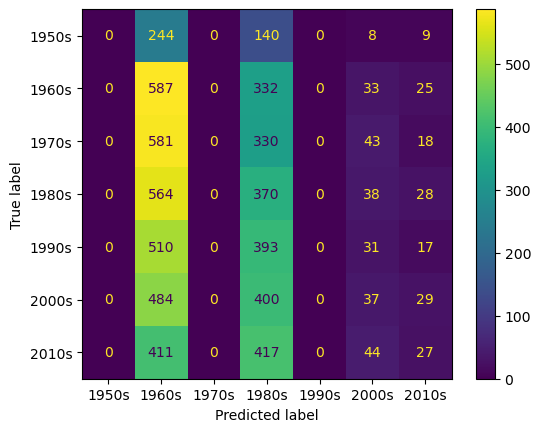


Normalized Multinomial Confusion Matrix:


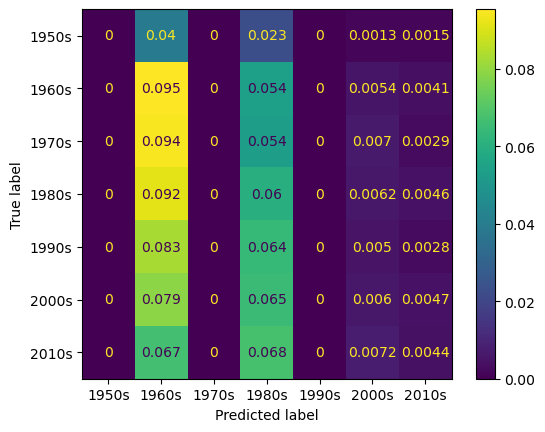

Multinomial TopK Accuracy: 0.4850455136540962


SVM Model Accuracy: 0.24187256176853056

SVM Confusion Matrix:


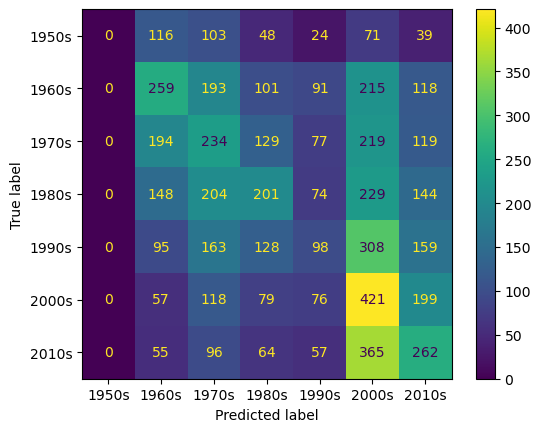


Normalized SVM Confusion Matrix:


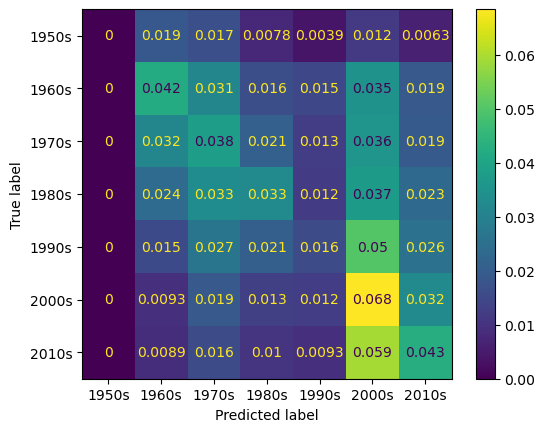

SVM TopK Accuracy: 0.6040312093628089


In [43]:
####first sent analysis
####Multinomial Naivebayes

#Multi NB can't take negative numbers, adding 1 to all values in Compound Row
LyrSentDFp1=LyrSentDF.copy(deep=True)
LyrSentDFp1['Compound']=LyrSentDFp1['Compound']+1

X_train, X_test, y_train, y_test = train_test_split(LyrSentDFp1.iloc[:,2:], LyrSentDFp1['Decade'])

SKNB_sent=SKMNB.fit(X_train,y_train)

SKNB_sent_Score=SKNB_sent.score(X_test,y_test)
print('Multinomial Naivebayes Accuracy:', SKNB_sent_Score)

print('\nMultinomial Confusion Matrix:')
cm_sk=confusion_matrix(LyrSentDFp1['Decade'],SKNB_sent.predict(LyrSentDFp1.iloc[:,2:]))
cm_sk_dsp=ConfusionMatrixDisplay(confusion_matrix=cm_sk,display_labels=SKNB_sent.classes_)
cm_sk_dsp.plot()
plt.show()

print('\nNormalized Multinomial Confusion Matrix:')
cm_sk_n=confusion_matrix(LyrSentDFp1['Decade'],SKNB_sent.predict(LyrSentDFp1.iloc[:,2:]),normalize='all')
cm_sk_dsp_n=ConfusionMatrixDisplay(confusion_matrix=cm_sk_n,display_labels=SKNB_sent.classes_)
cm_sk_dsp_n.plot()
plt.show()

SKNB_estimatorSent=SKNB_sent.predict_proba(X_test)

SKNB_Sent_topK=top_k_accuracy_score(y_test,SKNB_estimatorSent,k=3)
print('Multinomial TopK Accuracy:',SKNB_Sent_topK)

#####Now SVM
X_train, X_test, y_train, y_test = train_test_split(LyrSentDF.iloc[:,2:], LyrSentDF['Decade'])
print('\n')
svm_test_model=svm_test.fit(X_train,y_train)
print('SVM Model Accuracy:',svm_test_model.score(X_test,y_test))

print('\nSVM Confusion Matrix:')
SVM_CM=svm_test.fit(LyrSentDF.iloc[:,2:],LyrSentDF['Decade'])
cm_sk=confusion_matrix(LyrSentDF['Decade'],SVM_CM.predict(LyrSentDF.iloc[:,2:]))
cm_sk_dsp=ConfusionMatrixDisplay(confusion_matrix=cm_sk,display_labels=SVM_CM.classes_)
cm_sk_dsp.plot()
plt.show()

print('\nNormalized SVM Confusion Matrix:')
cm_sk_n=confusion_matrix(LyrSentDF['Decade'],SVM_CM.predict(LyrSentDF.iloc[:,2:]),normalize='all')
cm_sk_dsp_n=ConfusionMatrixDisplay(confusion_matrix=cm_sk_n,display_labels=SVM_CM.classes_)
cm_sk_dsp_n.plot()
plt.show()

SVM_DF=svm_test_model.decision_function(X_test)
SKSVM_topK=top_k_accuracy_score(y_test,SVM_DF,k=3)
print('SVM TopK Accuracy:', SKSVM_topK)

Multinomial Naivebayes Accuracy: 0.23276983094928477

Multinomial Confusion Matrix:


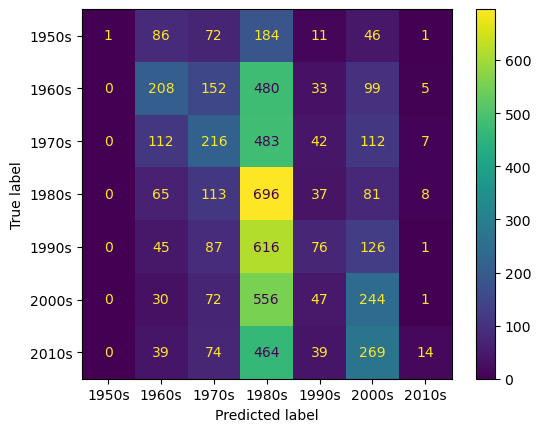


Normalized Multinomial Confusion Matrix:


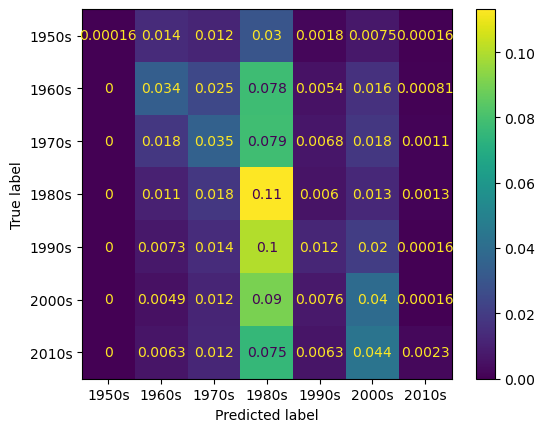

Multinomial TopK Accuracy: 0.5806241872561768


SVM Model Accuracy: 0.3088426527958388

SVM Confusion Matrix:


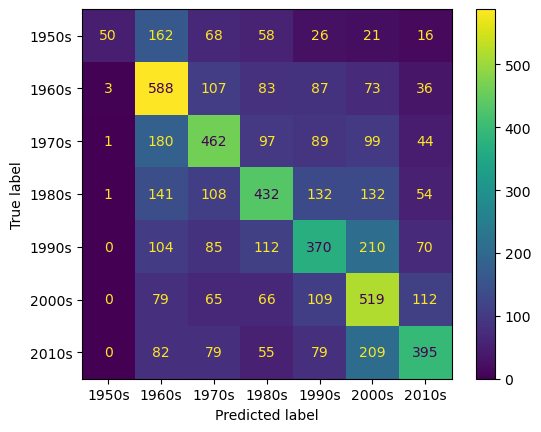


Normalized SVM Confusion Matrix:


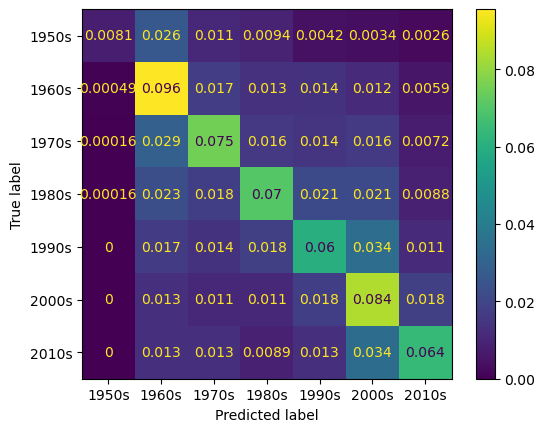

SVM TopK Accuracy: 0.7925877763328999


In [44]:
####now emp lexicon analysis
####Multinomial Naivebayes
X_train, X_test, y_train, y_test = train_test_split(LyrEmpDF.iloc[:,2:], LyrEmpDF['Decade'])

SKNB_emp=SKMNB.fit(X_train,y_train)

SKNB_emp_Score=SKNB_emp.score(X_test,y_test)
print('Multinomial Naivebayes Accuracy:', SKNB_emp_Score)

print('\nMultinomial Confusion Matrix:')
cm_sk=confusion_matrix(LyrEmpDF['Decade'],SKNB_emp.predict(LyrEmpDF.iloc[:,2:]))
cm_sk_dsp=ConfusionMatrixDisplay(confusion_matrix=cm_sk,display_labels=SKNB_emp.classes_)
cm_sk_dsp.plot()
plt.show()

print('\nNormalized Multinomial Confusion Matrix:')
cm_sk_n=confusion_matrix(LyrEmpDF['Decade'],SKNB_emp.predict(LyrEmpDF.iloc[:,2:]),normalize='all')
cm_sk_dsp_n=ConfusionMatrixDisplay(confusion_matrix=cm_sk_n,display_labels=SKNB_emp.classes_)
cm_sk_dsp_n.plot()
plt.show()

SKNB_estimatorEmp=SKNB_emp.predict_proba(X_test)

SKNB_Emp_topK=top_k_accuracy_score(y_test,SKNB_estimatorEmp,k=3)
print('Multinomial TopK Accuracy:',SKNB_Emp_topK)

#####Now SVM
X_train, X_test, y_train, y_test = train_test_split(LyrEmpDF.iloc[:,2:], LyrEmpDF['Decade'])
print('\n')
svm_test_model=svm_test.fit(X_train,y_train)
print('SVM Model Accuracy:',svm_test_model.score(X_test,y_test))

print('\nSVM Confusion Matrix:')
SVM_CM=svm_test.fit(LyrEmpDF.iloc[:,2:],LyrEmpDF['Decade'])
cm_sk=confusion_matrix(LyrEmpDF['Decade'],SVM_CM.predict(LyrEmpDF.iloc[:,2:]))
cm_sk_dsp=ConfusionMatrixDisplay(confusion_matrix=cm_sk,display_labels=SVM_CM.classes_)
cm_sk_dsp.plot()
plt.show()

print('\nNormalized SVM Confusion Matrix:')
cm_sk_n=confusion_matrix(LyrEmpDF['Decade'],SVM_CM.predict(LyrEmpDF.iloc[:,2:]),normalize='all')
cm_sk_dsp_n=ConfusionMatrixDisplay(confusion_matrix=cm_sk_n,display_labels=SVM_CM.classes_)
cm_sk_dsp_n.plot()
plt.show()

SVM_DF=svm_test_model.decision_function(X_test)
SKSVM_topK=top_k_accuracy_score(y_test,SVM_DF,k=3)
print('SVM TopK Accuracy:', SKSVM_topK)

Multinomial Naivebayes Accuracy: 0.2503250975292588

Multinomial Confusion Matrix:


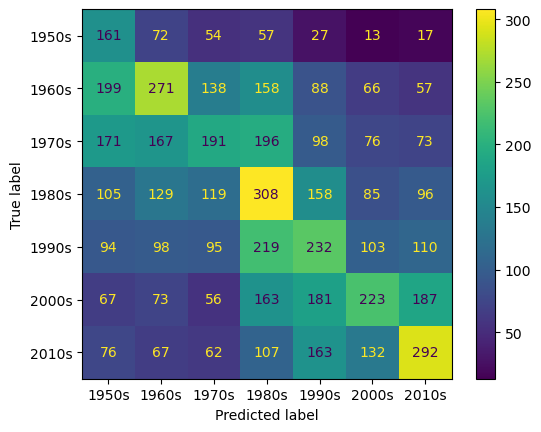


Normalized Multinomial Confusion Matrix:


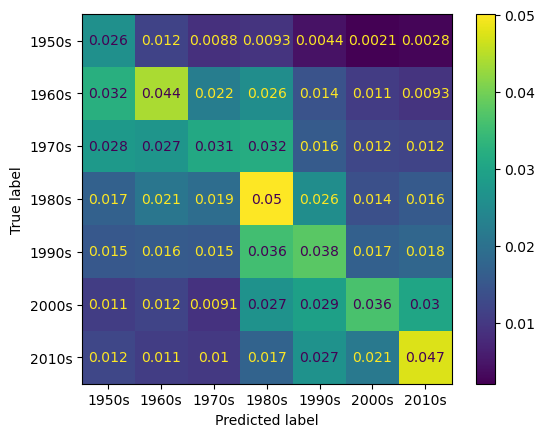

Multinomial TopK Accuracy: 0.6144343302990898


SVM Model Accuracy: 0.31144343302990896

SVM Confusion Matrix:


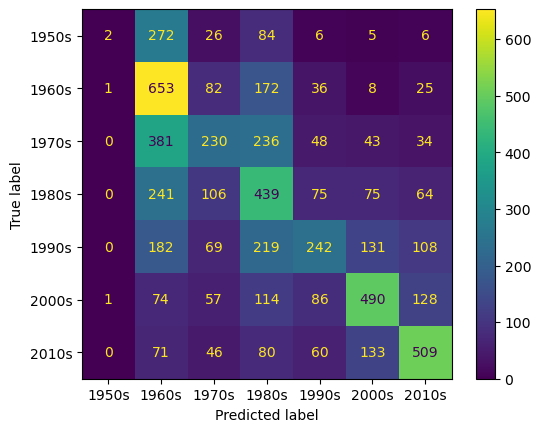


Normalized SVM Confusion Matrix:


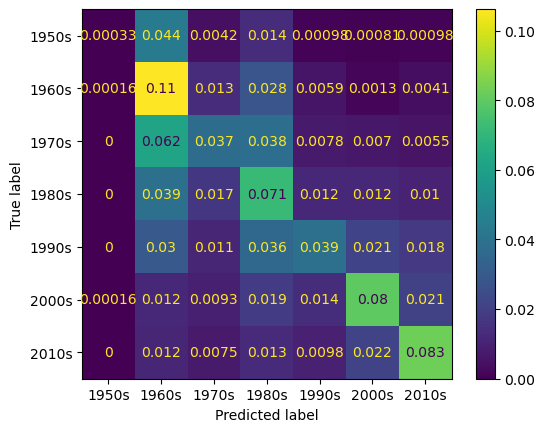

SVM TopK Accuracy: 0.7652795838751626


In [46]:
####now liwc lexicon analysis
####Multinomial Naivebayes
X_train, X_test, y_train, y_test = train_test_split(LyrLiwcDF.iloc[:,2:], LyrLiwcDF['Decade'])

SKNB_liwc=SKMNB.fit(X_train,y_train)

SKNB_liwc_Score=SKNB_liwc.score(X_test,y_test)
print('Multinomial Naivebayes Accuracy:', SKNB_liwc_Score)

print('\nMultinomial Confusion Matrix:')
cm_sk=confusion_matrix(LyrLiwcDF['Decade'],SKNB_liwc.predict(LyrLiwcDF.iloc[:,2:]))
cm_sk_dsp=ConfusionMatrixDisplay(confusion_matrix=cm_sk,display_labels=SKNB_liwc.classes_)
cm_sk_dsp.plot()
plt.show()

print('\nNormalized Multinomial Confusion Matrix:')
cm_sk_n=confusion_matrix(LyrLiwcDF['Decade'],SKNB_liwc.predict(LyrLiwcDF.iloc[:,2:]),normalize='all')
cm_sk_dsp_n=ConfusionMatrixDisplay(confusion_matrix=cm_sk_n,display_labels=SKNB_liwc.classes_)
cm_sk_dsp_n.plot()
plt.show()

SKNB_estimatorLiwc=SKNB_liwc.predict_proba(X_test)

SKNB_Liwc_topK=top_k_accuracy_score(y_test,SKNB_estimatorLiwc,k=3)
print('Multinomial TopK Accuracy:',SKNB_Liwc_topK)

#####Now SVM
X_train, X_test, y_train, y_test = train_test_split(LyrLiwcDF.iloc[:,2:], LyrLiwcDF['Decade'])
print('\n')
svm_test_model=svm_test.fit(X_train,y_train)
print('SVM Model Accuracy:',svm_test_model.score(X_test,y_test))

print('\nSVM Confusion Matrix:')
SVM_CM=svm_test.fit(LyrLiwcDF.iloc[:,2:],LyrLiwcDF['Decade'])
cm_sk=confusion_matrix(LyrLiwcDF['Decade'],SVM_CM.predict(LyrLiwcDF.iloc[:,2:]))
cm_sk_dsp=ConfusionMatrixDisplay(confusion_matrix=cm_sk,display_labels=SVM_CM.classes_)
cm_sk_dsp.plot()
plt.show()

print('\nNormalized SVM Confusion Matrix:')
cm_sk_n=confusion_matrix(LyrLiwcDF['Decade'],SVM_CM.predict(LyrLiwcDF.iloc[:,2:]),normalize='all')
cm_sk_dsp_n=ConfusionMatrixDisplay(confusion_matrix=cm_sk_n,display_labels=SVM_CM.classes_)
cm_sk_dsp_n.plot()
plt.show()

SVM_DF=svm_test_model.decision_function(X_test)
SKSVM_topK=top_k_accuracy_score(y_test,SVM_DF,k=3)
print('SVM TopK Accuracy:', SKSVM_topK)

Multinomial Naivebayes Accuracy: 0.26202860858257476

Multinomial Confusion Matrix:


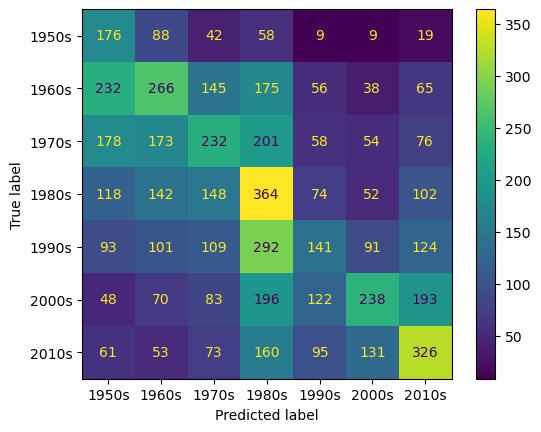


Normalized Multinomial Confusion Matrix:


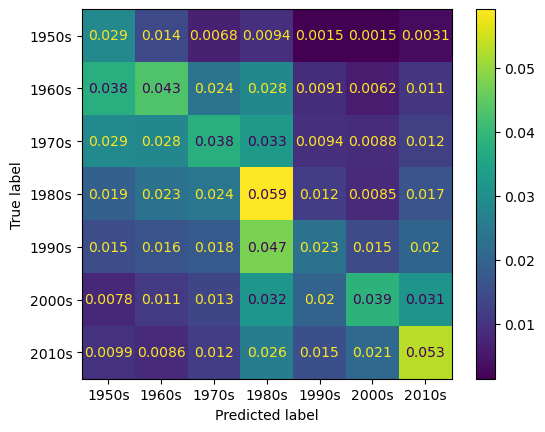

Multinomial TopK Accuracy: 0.6742522756827048


SVM Model Accuracy: 0.32249674902470743

SVM Confusion Matrix:


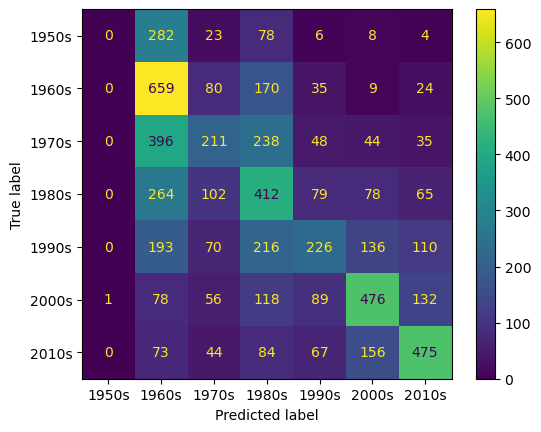


Normalized SVM Confusion Matrix:


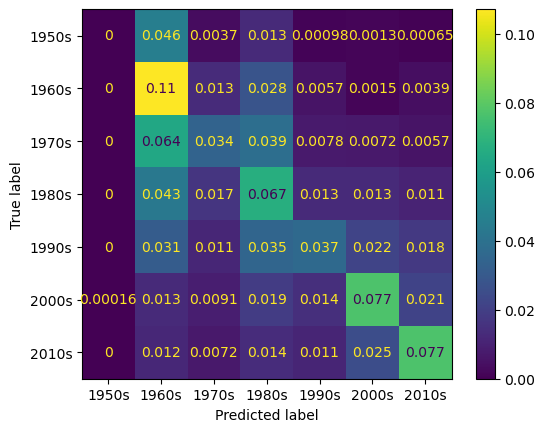

SVM TopK Accuracy: 0.770481144343303


In [48]:
####now 3sent lexicon analysis
####Multinomial Naivebayes

#adding 1 to compound value from 3 sent model so there are no negatives
SentEmpDFLiwcp1=SentEmpDFLiwc.copy(deep=True)
SentEmpDFLiwcp1['Compound']=SentEmpDFLiwcp1['Compound']+1
X_train, X_test, y_train, y_test = train_test_split(SentEmpDFLiwcp1.iloc[:,2:], SentEmpDFLiwcp1['Decade'])

SKNB_3sent=SKMNB.fit(X_train,y_train)

SKNB_3sent_Score=SKNB_3sent.score(X_test,y_test)
print('Multinomial Naivebayes Accuracy:', SKNB_3sent_Score)

print('\nMultinomial Confusion Matrix:')
cm_sk=confusion_matrix(SentEmpDFLiwcp1['Decade'],SKNB_3sent.predict(SentEmpDFLiwcp1.iloc[:,2:]))
cm_sk_dsp=ConfusionMatrixDisplay(confusion_matrix=cm_sk,display_labels=SKNB_3sent.classes_)
cm_sk_dsp.plot()
plt.show()

print('\nNormalized Multinomial Confusion Matrix:')
cm_sk_n=confusion_matrix(SentEmpDFLiwcp1['Decade'],SKNB_3sent.predict(SentEmpDFLiwcp1.iloc[:,2:]),normalize='all')
cm_sk_dsp_n=ConfusionMatrixDisplay(confusion_matrix=cm_sk_n,display_labels=SKNB_3sent.classes_)
cm_sk_dsp_n.plot()
plt.show()

SKNB_estimator3sent=SKNB_3sent.predict_proba(X_test)

SKNB_3sent_topK=top_k_accuracy_score(y_test,SKNB_estimator3sent,k=3)
print('Multinomial TopK Accuracy:',SKNB_3sent_topK)

#####Now SVM
X_train, X_test, y_train, y_test = train_test_split(SentEmpDFLiwc.iloc[:,2:], SentEmpDFLiwc['Decade'])
print('\n')
svm_test_model=svm_test.fit(X_train,y_train)
print('SVM Model Accuracy:',svm_test_model.score(X_test,y_test))

print('\nSVM Confusion Matrix:')
SVM_CM=svm_test.fit(SentEmpDFLiwc.iloc[:,2:],SentEmpDFLiwc['Decade'])
cm_sk=confusion_matrix(SentEmpDFLiwc['Decade'],SVM_CM.predict(SentEmpDFLiwc.iloc[:,2:]))
cm_sk_dsp=ConfusionMatrixDisplay(confusion_matrix=cm_sk,display_labels=SVM_CM.classes_)
cm_sk_dsp.plot()
plt.show()

print('\nNormalized SVM Confusion Matrix:')
cm_sk_n=confusion_matrix(SentEmpDFLiwc['Decade'],SVM_CM.predict(SentEmpDFLiwc.iloc[:,2:]),normalize='all')
cm_sk_dsp_n=ConfusionMatrixDisplay(confusion_matrix=cm_sk_n,display_labels=SVM_CM.classes_)
cm_sk_dsp_n.plot()
plt.show()

SVM_DF=svm_test_model.decision_function(X_test)
SKSVM_topK=top_k_accuracy_score(y_test,SVM_DF,k=3)
print('SVM TopK Accuracy:', SKSVM_topK)

In [49]:
##multinomial model cross-validation ##
# this function takes the (number of folds, featureset_dataframe)
# it iterates over the folds, using random sections selected by train_test_split
#   it prints the top k accuracy for each fold (using multinomial naivebayes (MNB) model) and the average top k accuracy at the end
def cross_val_acc_topk_MNB(num_folds, feature_DF):
    subset_size = int(len(feature_DF)/num_folds)
    print('Each fold size:', subset_size)
    accuracy_list = []
    # iterate over the folds
    for i in range(num_folds):
        X_train, X_test, y_train, y_test = train_test_split(feature_DF.iloc[:,2:], feature_DF['Decade'],test_size=subset_size)
        # train using train_this_round
        classifier = SKMNB.fit(X_train,y_train)
        # evaluate against test_this_round and save accuracy
        accuracy_this_round = top_k_accuracy_score(y_test,classifier.predict_proba(X_test),k=3)
        print (i, accuracy_this_round)
        accuracy_list.append(accuracy_this_round)
    # find mean accuracy over all rounds
    print ('mean accuracy', sum(accuracy_list) / num_folds)

In [51]:
#now MNB cross validation
print('sent MultiNB Cross Validation:')
cross_val_acc_topk_MNB(10,LyrSentDFp1)

print('\nemp MultiNB Cross Validation:')
cross_val_acc_topk_MNB(10,LyrEmpDF)

print('\nliwc MultiNB Cross Validation:')
cross_val_acc_topk_MNB(10,LyrLiwcDF)

print('\n3sent MultiNB Cross Validation:')
cross_val_acc_topk_MNB(10,SentEmpDFLiwcp1)

sent MultiNB Cross Validation:
Each fold size: 615
0 0.5447154471544715
1 0.5154471544715448
2 0.47317073170731705
3 0.5056910569105691
4 0.5138211382113821
5 0.4926829268292683
6 0.4666666666666667
7 0.510569105691057
8 0.49105691056910566
9 0.46991869918699186
mean accuracy 0.4983739837398374

emp MultiNB Cross Validation:
Each fold size: 615
0 0.6178861788617886
1 0.5772357723577236
2 0.6065040650406504
3 0.551219512195122
4 0.526829268292683
5 0.6
6 0.5756097560975609
7 0.6
8 0.5707317073170731
9 0.567479674796748
mean accuracy 0.579349593495935

liwc MultiNB Cross Validation:
Each fold size: 615
0 0.6308943089430894
1 0.608130081300813
2 0.6585365853658537
3 0.6373983739837399
4 0.6195121951219512
5 0.6601626016260163
6 0.6341463414634146
7 0.6325203252032521
8 0.608130081300813
9 0.6390243902439025
mean accuracy 0.6328455284552846

3sent MultiNB Cross Validation:
Each fold size: 615
0 0.6682926829268293
1 0.6829268292682927
2 0.6943089430894309
3 0.6373983739837399
4 0.6552845528

In [52]:
##SVM model cross-validation ##
# this function takes the (number of folds, featureset_dataframe)
# it iterates over the folds, using random sections selected by train_test_split
#   it prints the top k accuracy for each fold using SVM and the average top k accuracy at the end
def cross_val_acc_topk_SVM(num_folds, feature_DF):
    subset_size = int(len(feature_DF)/num_folds)
    print('Each fold size:', subset_size)
    accuracy_list = []
    # iterate over the folds
    for i in range(num_folds):
        X_train, X_test, y_train, y_test = train_test_split(feature_DF.iloc[:,2:], feature_DF['Decade'],test_size=subset_size)
        # train using train_this_round
        classifier = svm_test.fit(X_train,y_train)
        # evaluate against test_this_round and save accuracy
        accuracy_this_round = top_k_accuracy_score(y_test,classifier.decision_function(X_test),k=3)
        print (i, accuracy_this_round)
        accuracy_list.append(accuracy_this_round)
    # find mean accuracy over all rounds
    print ('mean accuracy', sum(accuracy_list) / num_folds)

In [53]:
#now SVM cross validation
print('sent SVM Cross Validation:')
cross_val_acc_topk_SVM(10,LyrSentDF)

print('\nemp SVM Cross Validation:')
cross_val_acc_topk_SVM(10,LyrEmpDF)

print('\nliwc SVM Cross Validation:')
cross_val_acc_topk_SVM(10,LyrLiwcDF)

print('\n3sent SVM Cross Validation:')
cross_val_acc_topk_SVM(10,SentEmpDFLiwc)

sent SVM Cross Validation:
Each fold size: 615
0 0.6016260162601627
1 0.5707317073170731
2 0.6130081300813008
3 0.5983739837398374
4 0.5593495934959349
5 0.5723577235772358
6 0.5788617886178862
7 0.583739837398374
8 0.6016260162601627
9 0.6065040650406504
mean accuracy 0.5886178861788618

emp SVM Cross Validation:
Each fold size: 615
0 0.6666666666666666
1 0.6813008130081301
2 0.6487804878048781
3 0.6894308943089431
4 0.6715447154471544
5 0.6829268292682927
6 0.6699186991869919
7 0.7170731707317073
8 0.6991869918699187
9 0.6634146341463415
mean accuracy 0.6790243902439024

liwc SVM Cross Validation:
Each fold size: 615
0 0.7089430894308943
1 0.7495934959349594
2 0.6991869918699187
3 0.7463414634146341
4 0.7154471544715447
5 0.7463414634146341
6 0.7398373983739838
7 0.7105691056910569
8 0.6943089430894309
9 0.7235772357723578
mean accuracy 0.7234146341463416

3sent SVM Cross Validation:
Each fold size: 615
0 0.7235772357723578
1 0.7056910569105691
2 0.7121951219512195
3 0.74796747967479

################################################################################
### Begin Feature Set and Modeling Work : 3 Feat Sets Combined #################
################################################################################

In [5]:
#####try combining all three DFs into one, then create a model based on that
SentPOSDF=pd.merge(SentEmpDFLiwc,LyrPOSDF_GM,on=['SongID','Decade'])

In [6]:
SentPOSFreqDF=pd.merge(SentPOSDF,LyrFreqDF_2,on=['SongID','Decade'])

In [7]:
SentPOSFreqDF

SongID Decade  Negative  Positive  Neutral  Compound    help_x  \
0        S_0  1950s     0.065     0.120    0.814    0.4767  0.000000   
1        S_1  1950s     0.255     0.336    0.409    0.8360  0.000000   
2        S_2  1950s     0.061     0.291    0.648    0.9961  0.000000   
3        S_3  1950s     0.094     0.474    0.433    0.9934  0.000000   
4        S_4  1950s     0.000     0.421    0.579    0.9612  0.000000   
...      ...    ...       ...       ...      ...       ...       ...   
6145  S_6145  2010s     0.310     0.159    0.531   -0.9992  0.001905   
6146  S_6146  2010s     0.074     0.327    0.599    0.9932  0.000000   
6147  S_6147  2010s     0.049     0.305    0.646    0.9774  0.008475   
6148  S_6148  2010s     0.182     0.223    0.596   -0.5764  0.000000   
6149  S_6149  2010s     0.107     0.308    0.584    0.9913  0.004386   

      office_x   dance_x   money_x  ...  9to5  mwah  unfollowed  rrr  vandros  \
0     0.000000  0.081633  0.000000  ...   0.0   0.0         0.0  0.0      0.0   
1     0.000000  0.000000  0.000000  ...   0.0   0.0         0.0  0.0      0.0   
2     0.000000  0.018349  0.000000  ...   0.0   0.0         0.0  0.0      0.0   
3     0.000000  0.107527  0.032258  ...   0.0   0.0         0.0  0.0      0.0   
4     0.000000  0.325000  0.050000  ...   0.0   0.0         0.0  0.0      0.0   
...        ...       ...       ...  ...   ...   ...         ...  ...      ...   
6145  0.000000  0.000000  0.000000  ...   1.0   1.0         1.0  2.0      0.0   
6146  0.000000  0.018293  0.000000  ...   0.0   0.0         0.0  0.0      3.0   
6147  0.016949  0.000000  0.000000  ...   0.0   0.0         0.0  0.0      0.0   
6148  0.000000  0.008333  0.000000  ...   0.0   0.0         0.0  0.0      0.0   
6149  0.000000  0.000000  0.000000  ...   0.0   0.0         0.0  0.0      0.0   

      driven  2000whatever  mikey  hmmhmm  scootie  
0        0.0           0.0    0.0     0.0      0.0  
1        0.0           0.0    0.0     0.0      0.0  
2        0.0           0.0    0.0     0.0      0.0  
3        0.0           0.0    0.0     0.0      0.0  
4        0.0           0.0    0.0     0.0      0.0  
...      ...           ...    ...     ...      ...  
6145     0.0           0.0    0.0     0.0      0.0  
6146     0.0           0.0    0.0     0.0      0.0  
6147     1.0           1.0    0.0     0.0      0.0  
6148     0.0           0.0    0.0     0.0      0.0  
6149     0.0           0.0    2.0     1.0      2.0  

[6150 rows x 25205 columns]

In [5]:
#IMPORTANT NOTE# This code once again took a while to run, so once it finished I 
# exported the JSON so that it can just be imported going forward. 
# There is code to import it at the top of the page already, the file is feature_set_ALL
''' 
#collect feature set from 3 types combined
feature_set_ALL=[]
for i in SentPOSFreqDF.index:
    features_dict={}
    features_item=()
    for h in range(2,len(SentPOSFreqDF.columns)):
        features_dict[SentPOSFreqDF.columns[h]]=SentPOSFreqDF.loc[i,SentPOSFreqDF.columns[h]]
    features_item=(features_dict,SentPOSFreqDF.loc[i,'Decade'])
    feature_set_ALL.append(features_item)
     '''

In [84]:
#####the column 'LinePerSong' was type numpy.int64, which json did not like, so converting them all to regular int
for i in range(0,len(feature_set_ALL)):
    feature_set_ALL[i][0]['LinePerSong']=feature_set_ALL[i][0]['LinePerSong'].item()

In [86]:
'''Exporting it also took a while.
#since it takes so long to create this feature set, export it and then import it
with open(f'{default_directory}/json_files/feature_set_ALL.json', 'w') as file:
    json.dump(feature_set_ALL, file)
    '''

In [89]:
#now create the test and train set
random.shuffle(feature_set_ALL)
cutoff=.80
split=round(len(feature_set_ALL)*cutoff)
train_set=feature_set_ALL[:split]
test_set=feature_set_ALL[split:]

In [90]:
#create the model
ALL_train_model=nltk.NaiveBayesClassifier.train(train_set)

In [12]:
#test for accuracy
nltk.classify.accuracy(ALL_train_model, test_set)

0.33170731707317075

In [91]:
def cross_validation_accuracy(num_folds, featuresets):
    subset_size = int(len(featuresets)/num_folds)
    print('Each fold size:', subset_size)
    accuracy_list = []
    # iterate over the folds
    for i in range(num_folds):
        test_this_round = featuresets[(i*subset_size):][:subset_size]
        train_this_round = featuresets[:(i*subset_size)] + featuresets[((i+1)*subset_size):]
        # train using train_this_round
        classifier = nltk.NaiveBayesClassifier.train(train_this_round)
        # evaluate against test_this_round and save accuracy
        accuracy_this_round = nltk.classify.accuracy(classifier, test_this_round)
        print (i, accuracy_this_round)
        accuracy_list.append(accuracy_this_round)
    # find mean accuracy over all rounds
    print ('mean accuracy', sum(accuracy_list) / num_folds)

In [92]:
cross_validation_accuracy(10, feature_set_ALL)

Each fold size: 615
0 0.3772357723577236
1 0.3333333333333333
2 0.375609756097561
3 0.3772357723577236
4 0.3723577235772358
5 0.35772357723577236
6 0.3642276422764228
7 0.3382113821138211
8 0.3203252032520325
9 0.3463414634146341
mean accuracy 0.356260162601626


################################################################################
### Now look at confusion matrix, precision, recall, F1 ########################
################################################################################

In [93]:
#now create the test and train set
random.shuffle(feature_set_ALL)
cutoff=.80
split=round(len(feature_set_ALL)*cutoff)
train_set=feature_set_ALL[:split]
test_set=feature_set_ALL[split:]

goldlist = []
predictedlist = []
for (features, label) in test_set:
    	goldlist.append(label)
    	predictedlist.append(ALL_train_model.classify(features))

# look at the first 30 examples
print(goldlist[:30])
print(predictedlist[:30])

cm = nltk.ConfusionMatrix(goldlist, predictedlist)
print(cm.pretty_format(sort_by_count=True, truncate=9))

# or show the results as percentages
print(cm.pretty_format(sort_by_count=True, show_percents=True, truncate=9))

# Function to compute precision, recall and F1 for each label
#  and for any number of labels
# Input: list of gold labels, list of predicted labels (in same order)
# Output:  prints precision, recall and F1 for each label
def eval_measures(gold, predicted):
    # get a list of labels
    labels = list(set(gold))
    # these lists have values for each label 
    recall_list = []
    precision_list = []
    F1_list = []
    for lab in labels:
        # for each label, compare gold and predicted lists and compute values
        TP = FP = FN = TN = 0
        for i, val in enumerate(gold):
            if val == lab and predicted[i] == lab:  TP += 1
            if val == lab and predicted[i] != lab:  FN += 1
            if val != lab and predicted[i] == lab:  FP += 1
            if val != lab and predicted[i] != lab:  TN += 1
        # use these to compute recall, precision, F1
        recall = TP / (TP + FP)
        precision = TP / (TP + FN)
        recall_list.append(recall)
        precision_list.append(precision)
        F1_list.append( 2 * (recall * precision) / (recall + precision))

    # the evaluation measures in a table with one row per label
    print('\tPrecision\tRecall\t\tF1')
    # print measures for each label
    for i, lab in enumerate(labels):
        print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
          "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(F1_list[i]))

# call the function with our data
eval_measures(goldlist, predictedlist)

['2000s', '1990s', '1980s', '1950s', '1980s', '1960s', '1980s', '2010s', '1970s', '1960s', '1960s', '1970s', '2000s', '1990s', '2000s', '1980s', '1990s', '1960s', '2000s', '1960s', '1970s', '2000s', '1960s', '1960s', '1960s', '1960s', '1950s', '1960s', '2010s', '2010s']
['1960s', '1960s', '1980s', '1960s', '1980s', '1960s', '1980s', '1980s', '1960s', '1960s', '1960s', '1980s', '2000s', '1980s', '1980s', '1980s', '1990s', '1980s', '1980s', '1960s', '1970s', '2000s', '1960s', '1960s', '1960s', '1960s', '1960s', '1960s', '2010s', '2010s']
      |   1   1   1   2   1   2   1 |
      |   9   9   9   0   9   0   9 |
      |   6   8   9   0   7   1   5 |
      |   0   0   0   0   0   0   0 |
      |   s   s   s   s   s   s   s |
------+-----------------------------+
1960s |<199>  2   .   .  13   1   . |
1980s |  27<160>  3   .  14   1   . |
1990s |  22  20<125>  7  12   1   . |
2000s |  19  22   3<123> 12   6   . |
1970s |  21   6   1   .<155>  1   . |
2010s |   8  13   3   9  11<130>  . |
19

################################################################################
### Use sklearn and top n predictors instead ###################################
################################################################################

In [8]:
SKMNB=MultinomialNB()

In [9]:
svm_test=svm.SVC(decision_function_shape='ovr')

Multinomial Naivebayes Accuracy: 0.37776332899869963

Multinomial Confusion Matrix:


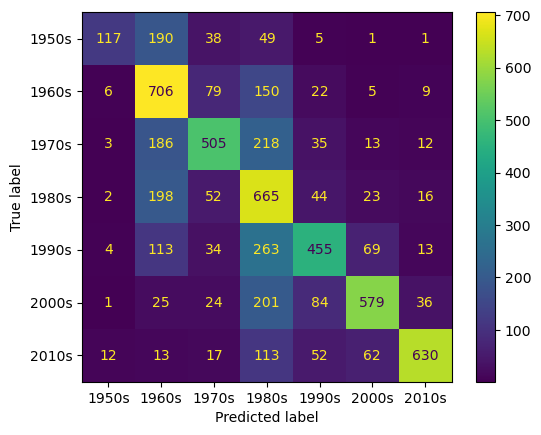


Normalized Multinomial Confusion Matrix:


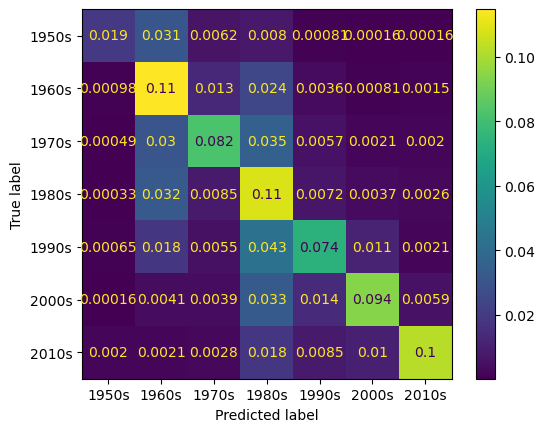

Multinomial TopK Accuracy: 0.7691807542262679


SVM Model Accuracy: 0.37386215864759426

SVM Confusion Matrix:


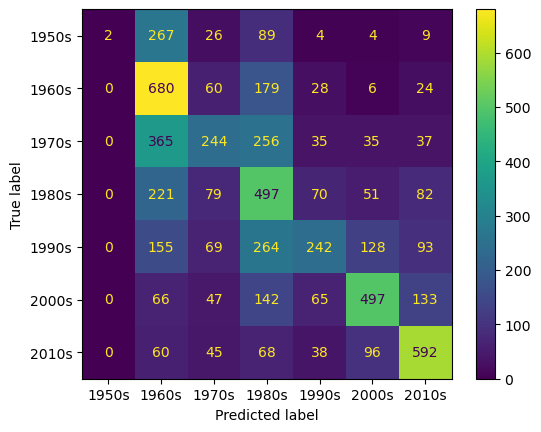


Normalized SVM Confusion Matrix:


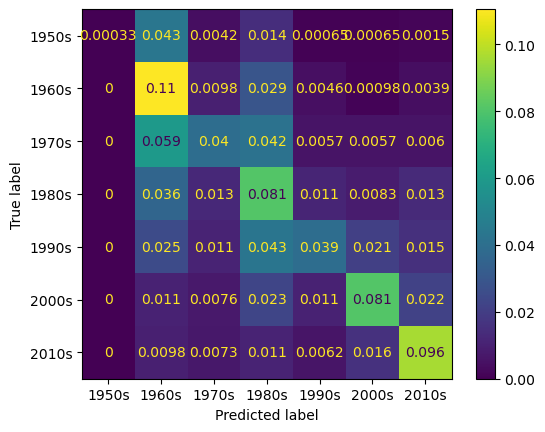

SVM TopK Accuracy: 0.8107932379713915


In [97]:
####first just POS tags
####Multinomial Naivebayes
#adding 1 to all compound values since MNB can't handle negative numbers
SentPOSFreqDFp1=SentPOSFreqDF.copy(deep=True)
SentPOSFreqDFp1['Compound']=SentPOSFreqDFp1['Compound']+1
X_train, X_test, y_train, y_test = train_test_split(SentPOSFreqDFp1.iloc[:,2:], SentPOSFreqDFp1['Decade'])

SKNB_ALL=SKMNB.fit(X_train,y_train)

SKNB_ALL_Score=SKNB_ALL.score(X_test,y_test)
print('Multinomial Naivebayes Accuracy:', SKNB_ALL_Score)

print('\nMultinomial Confusion Matrix:')
cm_sk=confusion_matrix(SentPOSFreqDFp1['Decade'],SKNB_ALL.predict(SentPOSFreqDFp1.iloc[:,2:]))
cm_sk_dsp=ConfusionMatrixDisplay(confusion_matrix=cm_sk,display_labels=SKNB_ALL.classes_)
cm_sk_dsp.plot()
plt.show()

print('\nNormalized Multinomial Confusion Matrix:')
cm_sk_n=confusion_matrix(SentPOSFreqDFp1['Decade'],SKNB_ALL.predict(SentPOSFreqDFp1.iloc[:,2:]),normalize='all')
cm_sk_dsp_n=ConfusionMatrixDisplay(confusion_matrix=cm_sk_n,display_labels=SKNB_ALL.classes_)
cm_sk_dsp_n.plot()
plt.show()

SKNB_estimatorALL=SKNB_ALL.predict_proba(X_test)

SKNB_ALL_topK=top_k_accuracy_score(y_test,SKNB_estimatorALL,k=3)
print('Multinomial TopK Accuracy:',SKNB_ALL_topK)

#####Now SVM
X_train, X_test, y_train, y_test = train_test_split(SentPOSFreqDF.iloc[:,2:], SentPOSFreqDF['Decade'])
print('\n')
svm_test_model=svm_test.fit(X_train,y_train)
print('SVM Model Accuracy:',svm_test_model.score(X_test,y_test))

print('\nSVM Confusion Matrix:')
SVM_CM=svm_test.fit(SentPOSFreqDF.iloc[:,2:],SentPOSFreqDF['Decade'])
cm_sk=confusion_matrix(SentPOSFreqDF['Decade'],SVM_CM.predict(SentPOSFreqDF.iloc[:,2:]))
cm_sk_dsp=ConfusionMatrixDisplay(confusion_matrix=cm_sk,display_labels=SVM_CM.classes_)
cm_sk_dsp.plot()
plt.show()

print('\nNormalized SVM Confusion Matrix:')
cm_sk_n=confusion_matrix(SentPOSFreqDF['Decade'],SVM_CM.predict(SentPOSFreqDF.iloc[:,2:]),normalize='all')
cm_sk_dsp_n=ConfusionMatrixDisplay(confusion_matrix=cm_sk_n,display_labels=SVM_CM.classes_)
cm_sk_dsp_n.plot()
plt.show()

SVM_DF=svm_test_model.decision_function(X_test)
SKSVM_topK=top_k_accuracy_score(y_test,SVM_DF,k=3)
print('SVM TopK Accuracy:', SKSVM_topK)

In [11]:
##multinomial model cross-validation ##
# this function takes the (number of folds, featureset_dataframe)
# it iterates over the folds, using random sections selected by train_test_split
#   it prints the top k accuracy for each fold (using multinomial naivebayes (MNB) model) and the average top k accuracy at the end
def cross_val_acc_topk_MNB(num_folds, feature_DF):
    subset_size = int(len(feature_DF)/num_folds)
    print('Each fold size:', subset_size)
    accuracy_list = []
    # iterate over the folds
    for i in range(num_folds):
        X_train, X_test, y_train, y_test = train_test_split(feature_DF.iloc[:,2:], feature_DF['Decade'],test_size=subset_size)
        # train using train_this_round
        classifier = SKMNB.fit(X_train,y_train)
        # evaluate against test_this_round and save accuracy
        accuracy_this_round = top_k_accuracy_score(y_test,classifier.predict_proba(X_test),k=3)
        print (i, accuracy_this_round)
        accuracy_list.append(accuracy_this_round)
    # find mean accuracy over all rounds
    print ('mean accuracy', sum(accuracy_list) / num_folds)

In [12]:
#now MNB cross validation
print('ALL MultiNB Cross Validation:')
cross_val_acc_topk_MNB(10,SentPOSFreqDFp1)

ALL MultiNB Cross Validation:
Each fold size: 615
0 0.7642276422764228
1 0.7788617886178861
2 0.759349593495935
3 0.7300813008130081
4 0.7853658536585366
5 0.791869918699187
6 0.7609756097560976
7 0.7934959349593496
8 0.759349593495935
9 0.7544715447154472
mean accuracy 0.7678048780487805


In [13]:
##SVM model cross-validation ##
# this function takes the (number of folds, featureset_dataframe)
# it iterates over the folds, using random sections selected by train_test_split
#   it prints the top k accuracy for each fold using SVM and the average top k accuracy at the end
def cross_val_acc_topk_SVM(num_folds, feature_DF):
    subset_size = int(len(feature_DF)/num_folds)
    print('Each fold size:', subset_size)
    accuracy_list = []
    # iterate over the folds
    for i in range(num_folds):
        X_train, X_test, y_train, y_test = train_test_split(feature_DF.iloc[:,2:], feature_DF['Decade'],test_size=subset_size)
        # train using train_this_round
        classifier = svm_test.fit(X_train,y_train)
        # evaluate against test_this_round and save accuracy
        accuracy_this_round = top_k_accuracy_score(y_test,classifier.decision_function(X_test),k=3)
        print (i, accuracy_this_round)
        accuracy_list.append(accuracy_this_round)
    # find mean accuracy over all rounds
    print ('mean accuracy', sum(accuracy_list) / num_folds)

In [14]:
#now svm cross validation
print('ALL SVM Cross Validation:')
cross_val_acc_topk_SVM(10,SentPOSFreqDF)

ALL SVM Cross Validation:
Each fold size: 615
0 0.7577235772357723
1 0.7707317073170732
2 0.7560975609756098
3 0.7642276422764228
4 0.7544715447154472
5 0.7333333333333333
6 0.7430894308943089
7 0.7658536585365854
8 0.7837398373983739
9 0.7772357723577236
mean accuracy 0.7606504065040649
